# Code embedding evaluation (315 repositories / train set)

## 1. Loading repository information

In [ ]:
!pip install gdown
!gdown 13Z-ReDj4QcwlfvIgUlL6MNE5W2dcPmLr

Downloading...
From: https://drive.google.com/uc?id=13Z-ReDj4QcwlfvIgUlL6MNE5W2dcPmLr
To: /content/repo_info_train.pkl
100% 202M/202M [00:04<00:00, 49.7MB/s]


In [ ]:
import pickle

with open("repo_info_train.pkl", "rb") as f:
    repo_info = pickle.load(f)
    f.close()

## 2. Download pre-trained model

In [ ]:
!pip3 install torch
!pip3 install transformers
!wget https://raw.githubusercontent.com/microsoft/CodeBERT/master/UniXcoder/unixcoder.py
# !curl -O https://raw.githubusercontent.com/microsoft/CodeBERT/master/UniXcoder/unixcoder.py

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 76.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 35.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 80.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 87.0 MB/s eta 0:00:00
--2023-07-07 15:34:22--  https://raw.githubusercontent.com/microsoft/CodeBERT/master/UniXcoder/unixcoder.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10352 (10K) [text/plain]
Saving to: ‘unixcoder.py’

unixcoder.py        100%[===================>]  10.11K  --.-KB/s    in 0s      

2023-07-07 15:34:22 (118 MB/s) - ‘unixcoder.py’ saved [10352/10352]



In [ ]:
import torch

device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(device)

cuda


In [ ]:
unixcoder_model_names = [
    "microsoft/unixcoder-base-nine",
    "microsoft/unixcoder-base",
    "microsoft/unixcoder-base-unimodal",
    "Lazyhope/unixcoder-nine-advtest",
    "Lazyhope/unixcoder-clone-detection",
    "Enoch/Unixcoder-Tuned-Code-Search-Py"
]

bert_model_names = [
    "Enoch/cocosoda-graphcodebert",
    "Enoch/graphcodebert-py"
]

In [ ]:
from unixcoder import UniXcoder
from transformers import AutoTokenizer, AutoModel

unixcoder_models = {}
# Initialise unixcoder model
for u_name in unixcoder_model_names:
    unixcoder_models[u_name] = UniXcoder(u_name)


bert_models = {}
# Initialise GraphCodeBERT model
for b_name in bert_model_names:
    bert_models[b_name] = {}
    bert_models[b_name]["tokenizer"] = AutoTokenizer.from_pretrained(b_name, device=device)
    bert_models[b_name]["model"] = AutoModel.from_pretrained(b_name)

## 3. Generating code embeddings

In [ ]:
# Getting code embeddings by UniXcoder
def get_unixcoder_embeddings(code, model):
    tokens_ids = model.tokenize([code], max_length=512, mode="<encoder-only>")
    source_ids = torch.tensor(tokens_ids).to(device)
    _, embeddings = model(source_ids)
    embeddings = embeddings.to("cpu")
    del source_ids
    return embeddings

# Getting code embeddings by GraphCodeBERT
def get_bert_embeddings(code, bert_dict):
    tokenizer = bert_dict["tokenizer"]
    model = bert_dict["model"].to(device)
    inputs = tokenizer(code, padding=True, truncation=True, max_length=512, return_tensors="pt",).to(device)
    outputs = model(**inputs)
    embeddings = torch.mean(outputs.last_hidden_state, dim=1).to("cpu")
    del model
    return embeddings

# Getting code list embeddings
def get_code_list_embeddings(data_list):
    codes_embeddings = {}
    # Using UniXcoder model
    for u_name, u_model in tqdm(unixcoder_models.items()):
        print(f" - Using {u_name} model - Running on", device)
        model = u_model.to(device)
        code_embeddings_list = torch.concat([get_unixcoder_embeddings(code, model) for code in data_list])
        codes_embeddings[u_name] = code_embeddings_list
        del model

    # Using GraphCodeBERT model
    for b_name, b_dict in tqdm(bert_models.items()):
        print(f" - Using {b_name} model - Running on", device)
        code_embeddings_list = torch.concat([get_bert_embeddings(code, b_dict) for code in data_list])
        codes_embeddings[b_name] = code_embeddings_list

    return codes_embeddings


# Getting embeddings
def get_embeddings(input_data=None, input_mode=None):
    if input_data is None or not input_data:
        return torch.zeros((768,), device=device)

    with torch.no_grad():
        if input_mode == "codes":
            return get_code_list_embeddings(input_data)


In [ ]:
from tqdm import tqdm

for repo_name, repo_dict in tqdm(repo_info.items()):
    print(f" - Generating code embeddings for {repo_name} - ")
    repo_dict["codes_embeddings"] = get_embeddings(input_data=repo_dict["codes"], input_mode="codes")

  0%|          | 0/315 [00:00<?, ?it/s]

 - Generating code embeddings for jet-admin/jet-bridge - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - Running on cuda



 17%|█▋        | 1/6 [00:12<01:01, 12.25s/it]

 - Using microsoft/unixcoder-base model - Running on cuda



 33%|███▎      | 2/6 [00:17<00:32,  8.12s/it]

 - Using microsoft/unixcoder-base-unimodal model - Running on cuda



 50%|█████     | 3/6 [00:22<00:20,  6.82s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - Running on cuda



 67%|██████▋   | 4/6 [00:28<00:12,  6.21s/it]

 - Using Lazyhope/unixcoder-clone-detection model - Running on cuda



 83%|████████▎ | 5/6 [00:33<00:05,  5.87s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - Running on cuda



100%|██████████| 6/6 [00:38<00:00,  6.43s/it]

  0%|          | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - Running on cuda



 50%|█████     | 1/2 [00:05<00:05,  5.72s/it]

 - Using Enoch/graphcodebert-py model - Running on cuda



  0%|          | 1/315 [00:50<4:22:04, 50.08s/it]

 - Generating code embeddings for patrys/httmock - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - Running on cuda



 17%|█▋        | 1/6 [00:00<00:03,  1.58it/s]

 - Using microsoft/unixcoder-base model - Running on cuda



 33%|███▎      | 2/6 [00:01<00:02,  1.58it/s]

 - Using microsoft/unixcoder-base-unimodal model - Running on cuda



 50%|█████     | 3/6 [00:01<00:01,  1.57it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - Running on cuda



 67%|██████▋   | 4/6 [00:02<00:01,  1.56it/s]

 - Using Lazyhope/unixcoder-clone-detection model - Running on cuda



 83%|████████▎ | 5/6 [00:03<00:00,  1.57it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - Running on cuda



100%|██████████| 6/6 [00:03<00:00,  1.57it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - Running on cuda



 50%|█████     | 1/2 [00:00<00:00,  1.43it/s]

 - Using Enoch/graphcodebert-py model - Running on cuda



  1%|          | 2/315 [00:55<2:03:38, 23.70s/it]

 - Generating code embeddings for pytransitions/transitions - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - Running on cuda



 17%|█▋        | 1/6 [00:09<00:46,  9.23s/it]

 - Using microsoft/unixcoder-base model - Running on cuda



 33%|███▎      | 2/6 [00:18<00:37,  9.36s/it]

 - Using microsoft/unixcoder-base-unimodal model - Running on cuda



 50%|█████     | 3/6 [00:28<00:28,  9.37s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - Running on cuda



 67%|██████▋   | 4/6 [00:37<00:18,  9.32s/it]

 - Using Lazyhope/unixcoder-clone-detection model - Running on cuda



 83%|████████▎ | 5/6 [00:46<00:09,  9.32s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - Running on cuda



100%|██████████| 6/6 [00:55<00:00,  9.30s/it]

  0%|          | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - Running on cuda



 50%|█████     | 1/2 [00:10<00:10, 10.04s/it]

 - Using Enoch/graphcodebert-py model - Running on cuda



  1%|          | 3/315 [02:11<4:07:22, 47.57s/it]

 - Generating code embeddings for keleshev/schema - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - Running on cuda



 17%|█▋        | 1/6 [00:01<00:09,  1.89s/it]

 - Using microsoft/unixcoder-base model - Running on cuda



 33%|███▎      | 2/6 [00:03<00:07,  1.90s/it]

 - Using microsoft/unixcoder-base-unimodal model - Running on cuda



 50%|█████     | 3/6 [00:05<00:05,  1.91s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - Running on cuda



 67%|██████▋   | 4/6 [00:07<00:03,  1.90s/it]

 - Using Lazyhope/unixcoder-clone-detection model - Running on cuda



 83%|████████▎ | 5/6 [00:09<00:01,  1.90s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - Running on cuda



100%|██████████| 6/6 [00:11<00:00,  1.90s/it]

  0%|          | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - Running on cuda



 50%|█████     | 1/2 [00:02<00:02,  2.07s/it]

 - Using Enoch/graphcodebert-py model - Running on cuda



  1%|▏         | 4/315 [02:26<3:01:05, 34.94s/it]

 - Generating code embeddings for dylanaraps/pywal - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - Running on cuda



 17%|█▋        | 1/6 [00:01<00:08,  1.63s/it]

 - Using microsoft/unixcoder-base model - Running on cuda



 33%|███▎      | 2/6 [00:03<00:06,  1.65s/it]

 - Using microsoft/unixcoder-base-unimodal model - Running on cuda



 50%|█████     | 3/6 [00:04<00:04,  1.65s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - Running on cuda



 67%|██████▋   | 4/6 [00:06<00:03,  1.65s/it]

 - Using Lazyhope/unixcoder-clone-detection model - Running on cuda



 83%|████████▎ | 5/6 [00:08<00:01,  1.65s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - Running on cuda



100%|██████████| 6/6 [00:09<00:00,  1.65s/it]

  0%|          | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - Running on cuda



 50%|█████     | 1/2 [00:01<00:01,  1.85s/it]

 - Using Enoch/graphcodebert-py model - Running on cuda



  2%|▏         | 5/315 [02:40<2:20:43, 27.24s/it]

 - Generating code embeddings for PyCQA/modernize - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - Running on cuda



 17%|█▋        | 1/6 [00:01<00:08,  1.71s/it]

 - Using microsoft/unixcoder-base model - Running on cuda



 33%|███▎      | 2/6 [00:03<00:06,  1.71s/it]

 - Using microsoft/unixcoder-base-unimodal model - Running on cuda



 50%|█████     | 3/6 [00:05<00:05,  1.71s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - Running on cuda



 67%|██████▋   | 4/6 [00:06<00:03,  1.71s/it]

 - Using Lazyhope/unixcoder-clone-detection model - Running on cuda



 83%|████████▎ | 5/6 [00:08<00:01,  1.71s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - Running on cuda



100%|██████████| 6/6 [00:10<00:00,  1.72s/it]

  0%|          | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - Running on cuda



 50%|█████     | 1/2 [00:01<00:01,  1.90s/it]

 - Using Enoch/graphcodebert-py model - Running on cuda



  2%|▏         | 6/315 [02:54<1:57:14, 22.77s/it]

 - Generating code embeddings for jaraco/path.py - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - Running on cuda



 17%|█▋        | 1/6 [00:02<00:10,  2.02s/it]

 - Using microsoft/unixcoder-base model - Running on cuda



 33%|███▎      | 2/6 [00:04<00:08,  2.01s/it]

 - Using microsoft/unixcoder-base-unimodal model - Running on cuda



 50%|█████     | 3/6 [00:06<00:06,  2.02s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - Running on cuda



 67%|██████▋   | 4/6 [00:08<00:04,  2.03s/it]

 - Using Lazyhope/unixcoder-clone-detection model - Running on cuda



 83%|████████▎ | 5/6 [00:10<00:02,  2.05s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - Running on cuda



100%|██████████| 6/6 [00:12<00:00,  2.03s/it]

  0%|          | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - Running on cuda



 50%|█████     | 1/2 [00:02<00:02,  2.23s/it]

 - Using Enoch/graphcodebert-py model - Running on cuda



  2%|▏         | 7/315 [03:11<1:46:38, 20.78s/it]

 - Generating code embeddings for xonsh/xonsh - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - Running on cuda



 17%|█▋        | 1/6 [00:22<01:50, 22.03s/it]

 - Using microsoft/unixcoder-base model - Running on cuda



 33%|███▎      | 2/6 [00:44<01:28, 22.01s/it]

 - Using microsoft/unixcoder-base-unimodal model - Running on cuda



 50%|█████     | 3/6 [01:05<01:05, 21.96s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - Running on cuda



 67%|██████▋   | 4/6 [01:28<00:44, 22.07s/it]

 - Using Lazyhope/unixcoder-clone-detection model - Running on cuda



 83%|████████▎ | 5/6 [01:49<00:21, 21.99s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - Running on cuda



100%|██████████| 6/6 [02:11<00:00, 21.96s/it]

  0%|          | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - Running on cuda



 50%|█████     | 1/2 [00:23<00:23, 23.84s/it]

 - Using Enoch/graphcodebert-py model - Running on cuda



  3%|▎         | 8/315 [06:10<6:04:43, 71.28s/it]

 - Generating code embeddings for python-excel/xlrd - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - Running on cuda



 17%|█▋        | 1/6 [00:01<00:07,  1.56s/it]

 - Using microsoft/unixcoder-base model - Running on cuda



 33%|███▎      | 2/6 [00:03<00:06,  1.55s/it]

 - Using microsoft/unixcoder-base-unimodal model - Running on cuda



 50%|█████     | 3/6 [00:04<00:04,  1.54s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - Running on cuda



 67%|██████▋   | 4/6 [00:06<00:03,  1.55s/it]

 - Using Lazyhope/unixcoder-clone-detection model - Running on cuda



 83%|████████▎ | 5/6 [00:07<00:01,  1.55s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - Running on cuda



100%|██████████| 6/6 [00:09<00:00,  1.55s/it]

  0%|          | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - Running on cuda



 50%|█████     | 1/2 [00:01<00:01,  1.70s/it]

 - Using Enoch/graphcodebert-py model - Running on cuda



  3%|▎         | 9/315 [06:23<4:30:08, 52.97s/it]

 - Generating code embeddings for cloudnativelabs/kube-shell - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - Running on cuda



 17%|█▋        | 1/6 [00:00<00:01,  2.57it/s]

 - Using microsoft/unixcoder-base model - Running on cuda



 33%|███▎      | 2/6 [00:00<00:01,  2.79it/s]

 - Using microsoft/unixcoder-base-unimodal model - Running on cuda



 50%|█████     | 3/6 [00:01<00:01,  2.89it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - Running on cuda



 67%|██████▋   | 4/6 [00:01<00:00,  2.93it/s]

 - Using Lazyhope/unixcoder-clone-detection model - Running on cuda



 83%|████████▎ | 5/6 [00:01<00:00,  2.97it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - Running on cuda



100%|██████████| 6/6 [00:02<00:00,  2.93it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - Running on cuda



 50%|█████     | 1/2 [00:00<00:00,  2.85it/s]

 - Using Enoch/graphcodebert-py model - Running on cuda



  3%|▎         | 10/315 [06:26<3:10:28, 37.47s/it]

 - Generating code embeddings for ironmussa/Optimus - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - Running on cuda



 17%|█▋        | 1/6 [00:38<03:13, 38.73s/it]

 - Using microsoft/unixcoder-base model - Running on cuda



 33%|███▎      | 2/6 [01:17<02:34, 38.63s/it]

 - Using microsoft/unixcoder-base-unimodal model - Running on cuda



 50%|█████     | 3/6 [01:55<01:55, 38.55s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - Running on cuda



 67%|██████▋   | 4/6 [02:34<01:17, 38.53s/it]

 - Using Lazyhope/unixcoder-clone-detection model - Running on cuda



 83%|████████▎ | 5/6 [03:12<00:38, 38.53s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - Running on cuda



100%|██████████| 6/6 [03:51<00:00, 38.54s/it]

  0%|          | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - Running on cuda



 50%|█████     | 1/2 [00:42<00:42, 42.61s/it]

 - Using Enoch/graphcodebert-py model - Running on cuda



  3%|▎         | 11/315 [11:42<10:22:26, 122.85s/it]

 - Generating code embeddings for jazzband/django-taggit - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - Running on cuda



 17%|█▋        | 1/6 [00:02<00:10,  2.10s/it]

 - Using microsoft/unixcoder-base model - Running on cuda



 33%|███▎      | 2/6 [00:04<00:08,  2.10s/it]

 - Using microsoft/unixcoder-base-unimodal model - Running on cuda



 50%|█████     | 3/6 [00:06<00:06,  2.10s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - Running on cuda



 67%|██████▋   | 4/6 [00:08<00:04,  2.10s/it]

 - Using Lazyhope/unixcoder-clone-detection model - Running on cuda



 83%|████████▎ | 5/6 [00:10<00:02,  2.09s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - Running on cuda



100%|██████████| 6/6 [00:12<00:00,  2.09s/it]

  0%|          | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - Running on cuda



 50%|█████     | 1/2 [00:02<00:02,  2.27s/it]

 - Using Enoch/graphcodebert-py model - Running on cuda



  4%|▍         | 12/315 [11:59<7:38:00, 90.70s/it]  

 - Generating code embeddings for moggers87/salmon - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - Running on cuda



 17%|█▋        | 1/6 [00:05<00:26,  5.28s/it]

 - Using microsoft/unixcoder-base model - Running on cuda



 33%|███▎      | 2/6 [00:10<00:21,  5.27s/it]

 - Using microsoft/unixcoder-base-unimodal model - Running on cuda



 50%|█████     | 3/6 [00:15<00:15,  5.27s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - Running on cuda



 67%|██████▋   | 4/6 [00:21<00:10,  5.29s/it]

 - Using Lazyhope/unixcoder-clone-detection model - Running on cuda



 83%|████████▎ | 5/6 [00:26<00:05,  5.30s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - Running on cuda



100%|██████████| 6/6 [00:31<00:00,  5.30s/it]

  0%|          | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - Running on cuda



 50%|█████     | 1/2 [00:05<00:05,  5.80s/it]

 - Using Enoch/graphcodebert-py model - Running on cuda



  4%|▍         | 13/315 [12:42<6:24:14, 76.34s/it]

 - Generating code embeddings for glamp/bashplotlib - 



 17%|█▋        | 1/6 [00:00<00:00,  5.37it/s]

 - Using microsoft/unixcoder-base-nine model - Running on cuda
 - Using microsoft/unixcoder-base model - Running on cuda



 50%|█████     | 3/6 [00:00<00:00,  5.27it/s]

 - Using microsoft/unixcoder-base-unimodal model - Running on cuda
 - Using Lazyhope/unixcoder-nine-advtest model - Running on cuda



 83%|████████▎ | 5/6 [00:00<00:00,  5.22it/s]

 - Using Lazyhope/unixcoder-clone-detection model - Running on cuda
 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - Running on cuda



100%|██████████| 6/6 [00:01<00:00,  5.24it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - Running on cuda



 50%|█████     | 1/2 [00:00<00:00,  4.99it/s]

 - Using Enoch/graphcodebert-py model - Running on cuda



  4%|▍         | 14/315 [12:44<4:29:40, 53.75s/it]

 - Generating code embeddings for PyCQA/prospector - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - Running on cuda



 17%|█▋        | 1/6 [00:04<00:21,  4.26s/it]

 - Using microsoft/unixcoder-base model - Running on cuda



 33%|███▎      | 2/6 [00:08<00:17,  4.26s/it]

 - Using microsoft/unixcoder-base-unimodal model - Running on cuda



 50%|█████     | 3/6 [00:12<00:12,  4.24s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - Running on cuda



 67%|██████▋   | 4/6 [00:16<00:08,  4.24s/it]

 - Using Lazyhope/unixcoder-clone-detection model - Running on cuda



 83%|████████▎ | 5/6 [00:21<00:04,  4.26s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - Running on cuda



100%|██████████| 6/6 [00:25<00:00,  4.25s/it]

  0%|          | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - Running on cuda



 50%|█████     | 1/2 [00:04<00:04,  4.70s/it]

 - Using Enoch/graphcodebert-py model - Running on cuda



  5%|▍         | 15/315 [13:19<4:00:21, 48.07s/it]

 - Generating code embeddings for twisted/treq - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - Running on cuda



 17%|█▋        | 1/6 [00:04<00:21,  4.36s/it]

 - Using microsoft/unixcoder-base model - Running on cuda



 33%|███▎      | 2/6 [00:08<00:17,  4.36s/it]

 - Using microsoft/unixcoder-base-unimodal model - Running on cuda



 50%|█████     | 3/6 [00:13<00:13,  4.37s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - Running on cuda



 67%|██████▋   | 4/6 [00:17<00:08,  4.36s/it]

 - Using Lazyhope/unixcoder-clone-detection model - Running on cuda



 83%|████████▎ | 5/6 [00:21<00:04,  4.36s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - Running on cuda



100%|██████████| 6/6 [00:26<00:00,  4.36s/it]

  0%|          | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - Running on cuda



 50%|█████     | 1/2 [00:04<00:04,  4.81s/it]

 - Using Enoch/graphcodebert-py model - Running on cuda



  5%|▌         | 16/315 [13:55<3:41:02, 44.36s/it]

 - Generating code embeddings for bbangert/beaker - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - Running on cuda



 17%|█▋        | 1/6 [00:06<00:32,  6.40s/it]

 - Using microsoft/unixcoder-base model - Running on cuda



 33%|███▎      | 2/6 [00:12<00:25,  6.42s/it]

 - Using microsoft/unixcoder-base-unimodal model - Running on cuda



 50%|█████     | 3/6 [00:19<00:19,  6.41s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - Running on cuda



 67%|██████▋   | 4/6 [00:25<00:12,  6.42s/it]

 - Using Lazyhope/unixcoder-clone-detection model - Running on cuda



 83%|████████▎ | 5/6 [00:32<00:06,  6.44s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - Running on cuda



100%|██████████| 6/6 [00:38<00:00,  6.43s/it]

  0%|          | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - Running on cuda



 50%|█████     | 1/2 [00:07<00:07,  7.09s/it]

 - Using Enoch/graphcodebert-py model - Running on cuda



  5%|▌         | 17/315 [14:48<3:52:54, 46.90s/it]

 - Generating code embeddings for pypa/bandersnatch - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - Running on cuda



 17%|█▋        | 1/6 [00:03<00:17,  3.58s/it]

 - Using microsoft/unixcoder-base model - Running on cuda



 33%|███▎      | 2/6 [00:07<00:14,  3.59s/it]

 - Using microsoft/unixcoder-base-unimodal model - Running on cuda



 50%|█████     | 3/6 [00:10<00:10,  3.59s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - Running on cuda



 67%|██████▋   | 4/6 [00:14<00:07,  3.59s/it]

 - Using Lazyhope/unixcoder-clone-detection model - Running on cuda



 83%|████████▎ | 5/6 [00:17<00:03,  3.61s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - Running on cuda



100%|██████████| 6/6 [00:21<00:00,  3.60s/it]

  0%|          | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - Running on cuda



 50%|█████     | 1/2 [00:03<00:03,  3.94s/it]

 - Using Enoch/graphcodebert-py model - Running on cuda



  6%|▌         | 18/315 [15:17<3:26:14, 41.67s/it]

 - Generating code embeddings for zachwill/moment - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - Running on cuda



 17%|█▋        | 1/6 [00:01<00:06,  1.23s/it]

 - Using microsoft/unixcoder-base model - Running on cuda



 33%|███▎      | 2/6 [00:02<00:05,  1.30s/it]

 - Using microsoft/unixcoder-base-unimodal model - Running on cuda



 50%|█████     | 3/6 [00:03<00:03,  1.28s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - Running on cuda



 67%|██████▋   | 4/6 [00:05<00:02,  1.26s/it]

 - Using Lazyhope/unixcoder-clone-detection model - Running on cuda



 83%|████████▎ | 5/6 [00:06<00:01,  1.25s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - Running on cuda



100%|██████████| 6/6 [00:07<00:00,  1.26s/it]

  0%|          | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - Running on cuda



 50%|█████     | 1/2 [00:01<00:01,  1.37s/it]

 - Using Enoch/graphcodebert-py model - Running on cuda



  6%|▌         | 19/315 [15:27<2:39:05, 32.25s/it]

 - Generating code embeddings for encode/apistar - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - Running on cuda



 17%|█▋        | 1/6 [00:01<00:08,  1.75s/it]

 - Using microsoft/unixcoder-base model - Running on cuda



 33%|███▎      | 2/6 [00:03<00:07,  1.77s/it]

 - Using microsoft/unixcoder-base-unimodal model - Running on cuda



 50%|█████     | 3/6 [00:05<00:05,  1.81s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - Running on cuda



 67%|██████▋   | 4/6 [00:07<00:03,  1.80s/it]

 - Using Lazyhope/unixcoder-clone-detection model - Running on cuda



 83%|████████▎ | 5/6 [00:08<00:01,  1.80s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - Running on cuda



100%|██████████| 6/6 [00:10<00:00,  1.79s/it]

  0%|          | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - Running on cuda



 50%|█████     | 1/2 [00:01<00:01,  1.94s/it]

 - Using Enoch/graphcodebert-py model - Running on cuda



  6%|▋         | 20/315 [15:42<2:12:33, 26.96s/it]

 - Generating code embeddings for pyinvoke/invoke - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - Running on cuda



 17%|█▋        | 1/6 [00:09<00:45,  9.19s/it]

 - Using microsoft/unixcoder-base model - Running on cuda



 33%|███▎      | 2/6 [00:18<00:36,  9.19s/it]

 - Using microsoft/unixcoder-base-unimodal model - Running on cuda



 50%|█████     | 3/6 [00:27<00:27,  9.18s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - Running on cuda



 67%|██████▋   | 4/6 [00:36<00:18,  9.16s/it]

 - Using Lazyhope/unixcoder-clone-detection model - Running on cuda



 83%|████████▎ | 5/6 [00:45<00:09,  9.17s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - Running on cuda



100%|██████████| 6/6 [00:55<00:00,  9.17s/it]

  0%|          | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - Running on cuda



 50%|█████     | 1/2 [00:10<00:10, 10.10s/it]

 - Using Enoch/graphcodebert-py model - Running on cuda



  7%|▋         | 21/315 [16:57<3:23:06, 41.45s/it]

 - Generating code embeddings for skorokithakis/shortuuid - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - Running on cuda



 17%|█▋        | 1/6 [00:00<00:02,  2.18it/s]

 - Using microsoft/unixcoder-base model - Running on cuda



 33%|███▎      | 2/6 [00:00<00:01,  2.16it/s]

 - Using microsoft/unixcoder-base-unimodal model - Running on cuda



 50%|█████     | 3/6 [00:01<00:01,  2.13it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - Running on cuda



 67%|██████▋   | 4/6 [00:01<00:00,  2.13it/s]

 - Using Lazyhope/unixcoder-clone-detection model - Running on cuda



 83%|████████▎ | 5/6 [00:02<00:00,  2.15it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - Running on cuda



100%|██████████| 6/6 [00:02<00:00,  2.13it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - Running on cuda



 50%|█████     | 1/2 [00:00<00:00,  1.97it/s]

 - Using Enoch/graphcodebert-py model - Running on cuda



  7%|▋         | 22/315 [17:01<2:27:18, 30.17s/it]

 - Generating code embeddings for s3tools/s3cmd - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - Running on cuda



 17%|█▋        | 1/6 [00:02<00:11,  2.32s/it]

 - Using microsoft/unixcoder-base model - Running on cuda



 33%|███▎      | 2/6 [00:04<00:09,  2.30s/it]

 - Using microsoft/unixcoder-base-unimodal model - Running on cuda



 50%|█████     | 3/6 [00:06<00:06,  2.30s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - Running on cuda



 67%|██████▋   | 4/6 [00:09<00:04,  2.30s/it]

 - Using Lazyhope/unixcoder-clone-detection model - Running on cuda



 83%|████████▎ | 5/6 [00:11<00:02,  2.31s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - Running on cuda



100%|██████████| 6/6 [00:13<00:00,  2.31s/it]

  0%|          | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - Running on cuda



 50%|█████     | 1/2 [00:02<00:02,  2.55s/it]

 - Using Enoch/graphcodebert-py model - Running on cuda



  7%|▋         | 23/315 [17:20<2:10:21, 26.79s/it]

 - Generating code embeddings for pyenv/pyenv - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - Running on cuda



 17%|█▋        | 1/6 [00:00<00:01,  3.35it/s]

 - Using microsoft/unixcoder-base model - Running on cuda



 33%|███▎      | 2/6 [00:00<00:01,  3.38it/s]

 - Using microsoft/unixcoder-base-unimodal model - Running on cuda



 50%|█████     | 3/6 [00:00<00:00,  3.38it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - Running on cuda



 67%|██████▋   | 4/6 [00:01<00:00,  3.36it/s]

 - Using Lazyhope/unixcoder-clone-detection model - Running on cuda



 83%|████████▎ | 5/6 [00:01<00:00,  3.37it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - Running on cuda



100%|██████████| 6/6 [00:01<00:00,  3.36it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - Running on cuda



 50%|█████     | 1/2 [00:00<00:00,  3.09it/s]

 - Using Enoch/graphcodebert-py model - Running on cuda



  8%|▊         | 24/315 [17:22<1:34:30, 19.49s/it]

 - Generating code embeddings for stchris/untangle - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - Running on cuda



 17%|█▋        | 1/6 [00:00<00:04,  1.25it/s]

 - Using microsoft/unixcoder-base model - Running on cuda



 33%|███▎      | 2/6 [00:01<00:03,  1.22it/s]

 - Using microsoft/unixcoder-base-unimodal model - Running on cuda



 50%|█████     | 3/6 [00:02<00:02,  1.24it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - Running on cuda



 67%|██████▋   | 4/6 [00:03<00:01,  1.25it/s]

 - Using Lazyhope/unixcoder-clone-detection model - Running on cuda



 83%|████████▎ | 5/6 [00:04<00:00,  1.24it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - Running on cuda



100%|██████████| 6/6 [00:04<00:00,  1.24it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - Running on cuda



 50%|█████     | 1/2 [00:00<00:00,  1.15it/s]

 - Using Enoch/graphcodebert-py model - Running on cuda



  8%|▊         | 25/315 [17:29<1:15:28, 15.62s/it]

 - Generating code embeddings for nvdv/vprof - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - Running on cuda



 17%|█▋        | 1/6 [00:02<00:11,  2.34s/it]

 - Using microsoft/unixcoder-base model - Running on cuda



 33%|███▎      | 2/6 [00:04<00:09,  2.34s/it]

 - Using microsoft/unixcoder-base-unimodal model - Running on cuda



 50%|█████     | 3/6 [00:07<00:07,  2.34s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - Running on cuda



 67%|██████▋   | 4/6 [00:09<00:04,  2.35s/it]

 - Using Lazyhope/unixcoder-clone-detection model - Running on cuda



 83%|████████▎ | 5/6 [00:11<00:02,  2.35s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - Running on cuda



100%|██████████| 6/6 [00:14<00:00,  2.35s/it]

  0%|          | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - Running on cuda



 50%|█████     | 1/2 [00:02<00:02,  2.58s/it]

 - Using Enoch/graphcodebert-py model - Running on cuda



  8%|▊         | 26/315 [17:48<1:20:31, 16.72s/it]

 - Generating code embeddings for h2oai/h2o-3 - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - Running on cuda



 17%|█▋        | 1/6 [01:01<05:08, 61.76s/it]

 - Using microsoft/unixcoder-base model - Running on cuda



 33%|███▎      | 2/6 [02:04<04:08, 62.05s/it]

 - Using microsoft/unixcoder-base-unimodal model - Running on cuda



 50%|█████     | 3/6 [03:05<03:05, 61.95s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - Running on cuda



 67%|██████▋   | 4/6 [04:07<02:04, 62.02s/it]

 - Using Lazyhope/unixcoder-clone-detection model - Running on cuda



 83%|████████▎ | 5/6 [05:09<01:01, 61.94s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - Running on cuda



100%|██████████| 6/6 [06:11<00:00, 61.95s/it]

  0%|          | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - Running on cuda



 50%|█████     | 1/2 [01:07<01:07, 67.34s/it]

 - Using Enoch/graphcodebert-py model - Running on cuda



  9%|▊         | 27/315 [26:14<13:05:10, 163.58s/it]

 - Generating code embeddings for benhamner/Metrics - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - Running on cuda



 17%|█▋        | 1/6 [00:00<00:02,  1.67it/s]

 - Using microsoft/unixcoder-base model - Running on cuda



 33%|███▎      | 2/6 [00:01<00:02,  1.67it/s]

 - Using microsoft/unixcoder-base-unimodal model - Running on cuda



 50%|█████     | 3/6 [00:01<00:01,  1.67it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - Running on cuda



 67%|██████▋   | 4/6 [00:02<00:01,  1.67it/s]

 - Using Lazyhope/unixcoder-clone-detection model - Running on cuda



 83%|████████▎ | 5/6 [00:03<00:00,  1.66it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - Running on cuda



100%|██████████| 6/6 [00:03<00:00,  1.66it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - Running on cuda



 50%|█████     | 1/2 [00:00<00:00,  1.52it/s]

 - Using Enoch/graphcodebert-py model - Running on cuda



  9%|▉         | 28/315 [26:19<9:14:47, 115.98s/it] 

 - Generating code embeddings for jmcarp/robobrowser - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - Running on cuda



 17%|█▋        | 1/6 [00:03<00:16,  3.22s/it]

 - Using microsoft/unixcoder-base model - Running on cuda



 33%|███▎      | 2/6 [00:06<00:12,  3.21s/it]

 - Using microsoft/unixcoder-base-unimodal model - Running on cuda



 50%|█████     | 3/6 [00:09<00:09,  3.20s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - Running on cuda



 67%|██████▋   | 4/6 [00:12<00:06,  3.20s/it]

 - Using Lazyhope/unixcoder-clone-detection model - Running on cuda



 83%|████████▎ | 5/6 [00:16<00:03,  3.20s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - Running on cuda



100%|██████████| 6/6 [00:19<00:00,  3.20s/it]

  0%|          | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - Running on cuda



 50%|█████     | 1/2 [00:03<00:03,  3.54s/it]

 - Using Enoch/graphcodebert-py model - Running on cuda



  9%|▉         | 29/315 [26:46<7:04:36, 89.08s/it] 

 - Generating code embeddings for WiserTogether/django-remote-forms - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - Running on cuda



 17%|█▋        | 1/6 [00:00<00:01,  2.83it/s]

 - Using microsoft/unixcoder-base model - Running on cuda



 33%|███▎      | 2/6 [00:00<00:01,  2.81it/s]

 - Using microsoft/unixcoder-base-unimodal model - Running on cuda



 50%|█████     | 3/6 [00:01<00:01,  2.81it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - Running on cuda



 67%|██████▋   | 4/6 [00:01<00:00,  2.81it/s]

 - Using Lazyhope/unixcoder-clone-detection model - Running on cuda



 83%|████████▎ | 5/6 [00:01<00:00,  2.80it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - Running on cuda



100%|██████████| 6/6 [00:02<00:00,  2.80it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - Running on cuda



 50%|█████     | 1/2 [00:00<00:00,  2.56it/s]

 - Using Enoch/graphcodebert-py model - Running on cuda



 10%|▉         | 30/315 [26:49<5:00:21, 63.23s/it]

 - Generating code embeddings for mahmoud/boltons - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - Running on cuda



 17%|█▋        | 1/6 [00:03<00:18,  3.78s/it]

 - Using microsoft/unixcoder-base model - Running on cuda



 33%|███▎      | 2/6 [00:07<00:15,  3.78s/it]

 - Using microsoft/unixcoder-base-unimodal model - Running on cuda



 50%|█████     | 3/6 [00:11<00:11,  3.77s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - Running on cuda



 67%|██████▋   | 4/6 [00:15<00:07,  3.77s/it]

 - Using Lazyhope/unixcoder-clone-detection model - Running on cuda



 83%|████████▎ | 5/6 [00:18<00:03,  3.78s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - Running on cuda



100%|██████████| 6/6 [00:22<00:00,  3.78s/it]

  0%|          | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - Running on cuda



 50%|█████     | 1/2 [00:04<00:04,  4.19s/it]

 - Using Enoch/graphcodebert-py model - Running on cuda



 10%|▉         | 31/315 [27:20<4:13:37, 53.58s/it]

 - Generating code embeddings for stanfordnlp/stanza - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - Running on cuda



 17%|█▋        | 1/6 [00:25<02:07, 25.44s/it]

 - Using microsoft/unixcoder-base model - Running on cuda



 33%|███▎      | 2/6 [00:50<01:41, 25.45s/it]

 - Using microsoft/unixcoder-base-unimodal model - Running on cuda



 50%|█████     | 3/6 [01:16<01:16, 25.46s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - Running on cuda



 67%|██████▋   | 4/6 [01:42<00:51, 25.55s/it]

 - Using Lazyhope/unixcoder-clone-detection model - Running on cuda



 83%|████████▎ | 5/6 [02:07<00:25, 25.52s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - Running on cuda



100%|██████████| 6/6 [02:33<00:00, 25.52s/it]

  0%|          | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - Running on cuda



 50%|█████     | 1/2 [00:27<00:27, 27.81s/it]

 - Using Enoch/graphcodebert-py model - Running on cuda



 10%|█         | 32/315 [30:48<7:52:06, 100.09s/it]

 - Generating code embeddings for keon/algorithms - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - Running on cuda



 17%|█▋        | 1/6 [00:14<01:13, 14.76s/it]

 - Using microsoft/unixcoder-base model - Running on cuda



 33%|███▎      | 2/6 [00:29<00:59, 14.76s/it]

 - Using microsoft/unixcoder-base-unimodal model - Running on cuda



 50%|█████     | 3/6 [00:44<00:44, 14.72s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - Running on cuda



 67%|██████▋   | 4/6 [00:58<00:29, 14.67s/it]

 - Using Lazyhope/unixcoder-clone-detection model - Running on cuda



 83%|████████▎ | 5/6 [01:13<00:14, 14.67s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - Running on cuda



100%|██████████| 6/6 [01:28<00:00, 14.69s/it]

  0%|          | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - Running on cuda



 50%|█████     | 1/2 [00:16<00:16, 16.20s/it]

 - Using Enoch/graphcodebert-py model - Running on cuda



 10%|█         | 33/315 [32:49<8:19:15, 106.23s/it]

 - Generating code embeddings for esnme/ultrajson - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - Running on cuda



 17%|█▋        | 1/6 [00:01<00:07,  1.40s/it]

 - Using microsoft/unixcoder-base model - Running on cuda



 33%|███▎      | 2/6 [00:02<00:05,  1.40s/it]

 - Using microsoft/unixcoder-base-unimodal model - Running on cuda



 50%|█████     | 3/6 [00:04<00:04,  1.40s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - Running on cuda



 67%|██████▋   | 4/6 [00:05<00:02,  1.40s/it]

 - Using Lazyhope/unixcoder-clone-detection model - Running on cuda



 83%|████████▎ | 5/6 [00:07<00:01,  1.40s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - Running on cuda



100%|██████████| 6/6 [00:08<00:00,  1.40s/it]

  0%|          | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - Running on cuda



 50%|█████     | 1/2 [00:01<00:01,  1.53s/it]

 - Using Enoch/graphcodebert-py model - Running on cuda



 11%|█         | 34/315 [33:00<6:04:23, 77.81s/it] 

 - Generating code embeddings for boto/boto3 - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - Running on cuda



 17%|█▋        | 1/6 [00:12<01:01, 12.30s/it]

 - Using microsoft/unixcoder-base model - Running on cuda



 33%|███▎      | 2/6 [00:24<00:49, 12.28s/it]

 - Using microsoft/unixcoder-base-unimodal model - Running on cuda



 50%|█████     | 3/6 [00:36<00:36, 12.29s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - Running on cuda



 67%|██████▋   | 4/6 [00:49<00:24, 12.27s/it]

 - Using Lazyhope/unixcoder-clone-detection model - Running on cuda



 83%|████████▎ | 5/6 [01:01<00:12, 12.29s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - Running on cuda



100%|██████████| 6/6 [01:13<00:00, 12.31s/it]

  0%|          | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - Running on cuda



 50%|█████     | 1/2 [00:13<00:13, 13.61s/it]

 - Using Enoch/graphcodebert-py model - Running on cuda



 11%|█         | 35/315 [34:42<6:35:50, 84.82s/it]

 - Generating code embeddings for geopy/geopy - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - Running on cuda



 17%|█▋        | 1/6 [00:05<00:28,  5.72s/it]

 - Using microsoft/unixcoder-base model - Running on cuda



 33%|███▎      | 2/6 [00:11<00:23,  5.77s/it]

 - Using microsoft/unixcoder-base-unimodal model - Running on cuda



 50%|█████     | 3/6 [00:17<00:17,  5.77s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - Running on cuda



 67%|██████▋   | 4/6 [00:23<00:11,  5.78s/it]

 - Using Lazyhope/unixcoder-clone-detection model - Running on cuda



 83%|████████▎ | 5/6 [00:28<00:05,  5.79s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - Running on cuda



100%|██████████| 6/6 [00:34<00:00,  5.79s/it]

  0%|          | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - Running on cuda



 50%|█████     | 1/2 [00:06<00:06,  6.37s/it]

 - Using Enoch/graphcodebert-py model - Running on cuda



 11%|█▏        | 36/315 [35:29<5:42:20, 73.62s/it]

 - Generating code embeddings for sdispater/pendulum - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - Running on cuda



 17%|█▋        | 1/6 [00:18<01:33, 18.66s/it]

 - Using microsoft/unixcoder-base model - Running on cuda



 33%|███▎      | 2/6 [00:37<01:15, 18.81s/it]

 - Using microsoft/unixcoder-base-unimodal model - Running on cuda



 50%|█████     | 3/6 [00:56<00:56, 18.78s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - Running on cuda



 67%|██████▋   | 4/6 [01:15<00:37, 18.76s/it]

 - Using Lazyhope/unixcoder-clone-detection model - Running on cuda



 83%|████████▎ | 5/6 [01:33<00:18, 18.73s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - Running on cuda



100%|██████████| 6/6 [01:52<00:00, 18.73s/it]

  0%|          | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - Running on cuda



 50%|█████     | 1/2 [00:20<00:20, 20.64s/it]

 - Using Enoch/graphcodebert-py model - Running on cuda



 12%|█▏        | 37/315 [38:03<7:32:32, 97.67s/it]

 - Generating code embeddings for omab/python-social-auth - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - Running on cuda



 17%|█▋        | 1/6 [00:05<00:29,  5.87s/it]

 - Using microsoft/unixcoder-base model - Running on cuda



 33%|███▎      | 2/6 [00:11<00:23,  5.87s/it]

 - Using microsoft/unixcoder-base-unimodal model - Running on cuda



 50%|█████     | 3/6 [00:17<00:17,  5.85s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - Running on cuda



 67%|██████▋   | 4/6 [00:23<00:11,  5.85s/it]

 - Using Lazyhope/unixcoder-clone-detection model - Running on cuda



 83%|████████▎ | 5/6 [00:29<00:05,  5.86s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - Running on cuda



100%|██████████| 6/6 [00:35<00:00,  5.86s/it]

  0%|          | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - Running on cuda



 50%|█████     | 1/2 [00:06<00:06,  6.53s/it]

 - Using Enoch/graphcodebert-py model - Running on cuda



 12%|█▏        | 38/315 [38:51<6:22:25, 82.83s/it]

 - Generating code embeddings for django-guardian/django-guardian - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - Running on cuda



 17%|█▋        | 1/6 [00:05<00:29,  5.92s/it]

 - Using microsoft/unixcoder-base model - Running on cuda



 33%|███▎      | 2/6 [00:11<00:23,  5.95s/it]

 - Using microsoft/unixcoder-base-unimodal model - Running on cuda



 50%|█████     | 3/6 [00:17<00:17,  5.94s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - Running on cuda



 67%|██████▋   | 4/6 [00:23<00:11,  5.94s/it]

 - Using Lazyhope/unixcoder-clone-detection model - Running on cuda



 83%|████████▎ | 5/6 [00:29<00:05,  5.93s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - Running on cuda



100%|██████████| 6/6 [00:35<00:00,  5.94s/it]

  0%|          | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - Running on cuda



 50%|█████     | 1/2 [00:06<00:06,  6.49s/it]

 - Using Enoch/graphcodebert-py model - Running on cuda



 12%|█▏        | 39/315 [39:40<5:33:48, 72.57s/it]

 - Generating code embeddings for mongodb/motor - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - Running on cuda



 17%|█▋        | 1/6 [00:04<00:23,  4.62s/it]

 - Using microsoft/unixcoder-base model - Running on cuda



 33%|███▎      | 2/6 [00:09<00:18,  4.65s/it]

 - Using microsoft/unixcoder-base-unimodal model - Running on cuda



 50%|█████     | 3/6 [00:13<00:13,  4.65s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - Running on cuda



 67%|██████▋   | 4/6 [00:18<00:09,  4.65s/it]

 - Using Lazyhope/unixcoder-clone-detection model - Running on cuda



 83%|████████▎ | 5/6 [00:23<00:04,  4.67s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - Running on cuda



100%|██████████| 6/6 [00:27<00:00,  4.66s/it]

  0%|          | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - Running on cuda



 50%|█████     | 1/2 [00:05<00:05,  5.13s/it]

 - Using Enoch/graphcodebert-py model - Running on cuda



 13%|█▎        | 40/315 [40:18<4:45:25, 62.27s/it]

 - Generating code embeddings for napalm-automation/napalm - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - Running on cuda



 17%|█▋        | 1/6 [00:10<00:50, 10.06s/it]

 - Using microsoft/unixcoder-base model - Running on cuda



 33%|███▎      | 2/6 [00:20<00:40, 10.10s/it]

 - Using microsoft/unixcoder-base-unimodal model - Running on cuda



 50%|█████     | 3/6 [00:30<00:30, 10.09s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - Running on cuda



 67%|██████▋   | 4/6 [00:40<00:20, 10.09s/it]

 - Using Lazyhope/unixcoder-clone-detection model - Running on cuda



 83%|████████▎ | 5/6 [00:50<00:10, 10.08s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - Running on cuda



100%|██████████| 6/6 [01:00<00:00, 10.10s/it]

  0%|          | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - Running on cuda



 50%|█████     | 1/2 [00:11<00:11, 11.04s/it]

 - Using Enoch/graphcodebert-py model - Running on cuda



 13%|█▎        | 41/315 [41:41<5:12:19, 68.39s/it]

 - Generating code embeddings for django-crispy-forms/django-crispy-forms - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - Running on cuda



 17%|█▋        | 1/6 [00:03<00:15,  3.11s/it]

 - Using microsoft/unixcoder-base model - Running on cuda



 33%|███▎      | 2/6 [00:06<00:12,  3.11s/it]

 - Using microsoft/unixcoder-base-unimodal model - Running on cuda



 50%|█████     | 3/6 [00:09<00:09,  3.13s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - Running on cuda



 67%|██████▋   | 4/6 [00:12<00:06,  3.13s/it]

 - Using Lazyhope/unixcoder-clone-detection model - Running on cuda



 83%|████████▎ | 5/6 [00:15<00:03,  3.12s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - Running on cuda



100%|██████████| 6/6 [00:18<00:00,  3.12s/it]

  0%|          | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - Running on cuda



 50%|█████     | 1/2 [00:03<00:03,  3.36s/it]

 - Using Enoch/graphcodebert-py model - Running on cuda



 13%|█▎        | 42/315 [42:06<4:12:39, 55.53s/it]

 - Generating code embeddings for mymarilyn/clickhouse-driver - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - Running on cuda



 17%|█▋        | 1/6 [00:09<00:49,  9.97s/it]

 - Using microsoft/unixcoder-base model - Running on cuda



 33%|███▎      | 2/6 [00:19<00:39,  9.92s/it]

 - Using microsoft/unixcoder-base-unimodal model - Running on cuda



 50%|█████     | 3/6 [00:29<00:29,  9.91s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - Running on cuda



 67%|██████▋   | 4/6 [00:39<00:19,  9.91s/it]

 - Using Lazyhope/unixcoder-clone-detection model - Running on cuda



 83%|████████▎ | 5/6 [00:49<00:09,  9.90s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - Running on cuda



100%|██████████| 6/6 [00:59<00:00,  9.91s/it]

  0%|          | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - Running on cuda



 50%|█████     | 1/2 [00:10<00:10, 10.94s/it]

 - Using Enoch/graphcodebert-py model - Running on cuda



 14%|█▎        | 43/315 [43:27<4:46:45, 63.26s/it]

 - Generating code embeddings for sdispater/orator - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - Running on cuda



 17%|█▋        | 1/6 [00:22<01:54, 22.94s/it]

 - Using microsoft/unixcoder-base model - Running on cuda



 33%|███▎      | 2/6 [00:45<01:31, 22.89s/it]

 - Using microsoft/unixcoder-base-unimodal model - Running on cuda



 50%|█████     | 3/6 [01:08<01:08, 22.90s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - Running on cuda



 67%|██████▋   | 4/6 [01:31<00:45, 22.89s/it]

 - Using Lazyhope/unixcoder-clone-detection model - Running on cuda



 83%|████████▎ | 5/6 [01:54<00:22, 22.85s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - Running on cuda



100%|██████████| 6/6 [02:17<00:00, 22.85s/it]

  0%|          | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - Running on cuda



 50%|█████     | 1/2 [00:25<00:25, 25.19s/it]

 - Using Enoch/graphcodebert-py model - Running on cuda



 14%|█▍        | 44/315 [46:35<7:33:58, 100.51s/it]

 - Generating code embeddings for codelucas/newspaper - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - Running on cuda



 17%|█▋        | 1/6 [00:03<00:15,  3.07s/it]

 - Using microsoft/unixcoder-base model - Running on cuda



 33%|███▎      | 2/6 [00:06<00:12,  3.09s/it]

 - Using microsoft/unixcoder-base-unimodal model - Running on cuda



 50%|█████     | 3/6 [00:09<00:09,  3.08s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - Running on cuda



 67%|██████▋   | 4/6 [00:12<00:06,  3.08s/it]

 - Using Lazyhope/unixcoder-clone-detection model - Running on cuda



 83%|████████▎ | 5/6 [00:15<00:03,  3.09s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - Running on cuda



100%|██████████| 6/6 [00:18<00:00,  3.08s/it]

  0%|          | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - Running on cuda



 50%|█████     | 1/2 [00:03<00:03,  3.38s/it]

 - Using Enoch/graphcodebert-py model - Running on cuda



 14%|█▍        | 45/315 [47:00<5:50:43, 77.94s/it] 

 - Generating code embeddings for coleifer/huey - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - Running on cuda



 17%|█▋        | 1/6 [00:03<00:15,  3.19s/it]

 - Using microsoft/unixcoder-base model - Running on cuda



 33%|███▎      | 2/6 [00:06<00:12,  3.18s/it]

 - Using microsoft/unixcoder-base-unimodal model - Running on cuda



 50%|█████     | 3/6 [00:09<00:09,  3.17s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - Running on cuda



 67%|██████▋   | 4/6 [00:12<00:06,  3.17s/it]

 - Using Lazyhope/unixcoder-clone-detection model - Running on cuda



 83%|████████▎ | 5/6 [00:15<00:03,  3.18s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - Running on cuda



100%|██████████| 6/6 [00:19<00:00,  3.18s/it]

  0%|          | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - Running on cuda



 50%|█████     | 1/2 [00:03<00:03,  3.48s/it]

 - Using Enoch/graphcodebert-py model - Running on cuda



 15%|█▍        | 46/315 [47:26<4:39:36, 62.36s/it]

 - Generating code embeddings for sympy/sympy - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - Running on cuda



 17%|█▋        | 1/6 [05:07<25:36, 307.37s/it]

 - Using microsoft/unixcoder-base model - Running on cuda



 33%|███▎      | 2/6 [10:16<20:32, 308.24s/it]

 - Using microsoft/unixcoder-base-unimodal model - Running on cuda



 50%|█████     | 3/6 [15:23<15:23, 307.94s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - Running on cuda



 67%|██████▋   | 4/6 [20:31<10:15, 307.90s/it]

 - Using Lazyhope/unixcoder-clone-detection model - Running on cuda



 83%|████████▎ | 5/6 [25:39<05:07, 307.71s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - Running on cuda



100%|██████████| 6/6 [30:46<00:00, 307.75s/it]

  0%|          | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - Running on cuda



 50%|█████     | 1/2 [05:39<05:39, 339.05s/it]

 - Using Enoch/graphcodebert-py model - Running on cuda



 15%|█▍        | 47/315 [1:29:29<59:35:36, 800.51s/it]

 - Generating code embeddings for gabrielfalcao/HTTPretty - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - Running on cuda



 17%|█▋        | 1/6 [00:02<00:13,  2.68s/it]

 - Using microsoft/unixcoder-base model - Running on cuda



 33%|███▎      | 2/6 [00:05<00:10,  2.68s/it]

 - Using microsoft/unixcoder-base-unimodal model - Running on cuda



 50%|█████     | 3/6 [00:08<00:08,  2.68s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - Running on cuda



 67%|██████▋   | 4/6 [00:10<00:05,  2.68s/it]

 - Using Lazyhope/unixcoder-clone-detection model - Running on cuda



 83%|████████▎ | 5/6 [00:13<00:02,  2.68s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - Running on cuda



100%|██████████| 6/6 [00:16<00:00,  2.68s/it]

  0%|          | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - Running on cuda



 50%|█████     | 1/2 [00:02<00:02,  2.94s/it]

 - Using Enoch/graphcodebert-py model - Running on cuda



 15%|█▌        | 48/315 [1:29:51<42:02:54, 566.95s/it]

 - Generating code embeddings for elapouya/python-docx-template - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - Running on cuda



 17%|█▋        | 1/6 [00:00<00:03,  1.33it/s]

 - Using microsoft/unixcoder-base model - Running on cuda



 33%|███▎      | 2/6 [00:01<00:02,  1.33it/s]

 - Using microsoft/unixcoder-base-unimodal model - Running on cuda



 50%|█████     | 3/6 [00:02<00:02,  1.33it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - Running on cuda



 67%|██████▋   | 4/6 [00:03<00:01,  1.33it/s]

 - Using Lazyhope/unixcoder-clone-detection model - Running on cuda



 83%|████████▎ | 5/6 [00:03<00:00,  1.33it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - Running on cuda



100%|██████████| 6/6 [00:04<00:00,  1.33it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - Running on cuda



 50%|█████     | 1/2 [00:00<00:00,  1.24it/s]

 - Using Enoch/graphcodebert-py model - Running on cuda



 16%|█▌        | 49/315 [1:29:57<29:27:35, 398.70s/it]

 - Generating code embeddings for dahlia/wand - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - Running on cuda



 17%|█▋        | 1/6 [00:08<00:39,  8.00s/it]

 - Using microsoft/unixcoder-base model - Running on cuda



 33%|███▎      | 2/6 [00:16<00:32,  8.00s/it]

 - Using microsoft/unixcoder-base-unimodal model - Running on cuda



 50%|█████     | 3/6 [00:23<00:23,  7.99s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - Running on cuda



 67%|██████▋   | 4/6 [00:32<00:16,  8.04s/it]

 - Using Lazyhope/unixcoder-clone-detection model - Running on cuda



 83%|████████▎ | 5/6 [00:40<00:08,  8.04s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - Running on cuda



100%|██████████| 6/6 [00:48<00:00,  8.02s/it]

  0%|          | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - Running on cuda



 50%|█████     | 1/2 [00:08<00:08,  8.77s/it]

 - Using Enoch/graphcodebert-py model - Running on cuda



 16%|█▌        | 50/315 [1:31:03<21:59:35, 298.77s/it]

 - Generating code embeddings for mpdavis/python-jose - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - Running on cuda



 17%|█▋        | 1/6 [00:03<00:17,  3.56s/it]

 - Using microsoft/unixcoder-base model - Running on cuda



 33%|███▎      | 2/6 [00:06<00:13,  3.48s/it]

 - Using microsoft/unixcoder-base-unimodal model - Running on cuda



 50%|█████     | 3/6 [00:10<00:10,  3.46s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - Running on cuda



 67%|██████▋   | 4/6 [00:13<00:06,  3.47s/it]

 - Using Lazyhope/unixcoder-clone-detection model - Running on cuda



 83%|████████▎ | 5/6 [00:17<00:03,  3.47s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - Running on cuda



100%|██████████| 6/6 [00:20<00:00,  3.47s/it]

  0%|          | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - Running on cuda



 50%|█████     | 1/2 [00:03<00:03,  3.73s/it]

 - Using Enoch/graphcodebert-py model - Running on cuda



 16%|█▌        | 51/315 [1:31:31<15:57:34, 217.63s/it]

 - Generating code embeddings for shinux/PyTime - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - Running on cuda



 17%|█▋        | 1/6 [00:00<00:03,  1.52it/s]

 - Using microsoft/unixcoder-base model - Running on cuda



 33%|███▎      | 2/6 [00:01<00:02,  1.51it/s]

 - Using microsoft/unixcoder-base-unimodal model - Running on cuda



 50%|█████     | 3/6 [00:01<00:01,  1.52it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - Running on cuda



 67%|██████▋   | 4/6 [00:02<00:01,  1.52it/s]

 - Using Lazyhope/unixcoder-clone-detection model - Running on cuda



 83%|████████▎ | 5/6 [00:03<00:00,  1.51it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - Running on cuda



100%|██████████| 6/6 [00:03<00:00,  1.51it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - Running on cuda



 50%|█████     | 1/2 [00:00<00:00,  1.39it/s]

 - Using Enoch/graphcodebert-py model - Running on cuda



 17%|█▋        | 52/315 [1:31:36<11:14:53, 153.97s/it]

 - Generating code embeddings for pymc-devs/pymc3 - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - Running on cuda



 17%|█▋        | 1/6 [00:35<02:56, 35.29s/it]

 - Using microsoft/unixcoder-base model - Running on cuda



 33%|███▎      | 2/6 [01:10<02:21, 35.32s/it]

 - Using microsoft/unixcoder-base-unimodal model - Running on cuda



 50%|█████     | 3/6 [01:45<01:45, 35.27s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - Running on cuda



 67%|██████▋   | 4/6 [02:20<01:10, 35.22s/it]

 - Using Lazyhope/unixcoder-clone-detection model - Running on cuda



 83%|████████▎ | 5/6 [02:56<00:35, 35.23s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - Running on cuda



100%|██████████| 6/6 [03:31<00:00, 35.22s/it]

  0%|          | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - Running on cuda



 50%|█████     | 1/2 [00:38<00:38, 38.77s/it]

 - Using Enoch/graphcodebert-py model - Running on cuda



 17%|█▋        | 53/315 [1:36:25<14:08:57, 194.42s/it]

 - Generating code embeddings for TheAlgorithms/Python - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - Running on cuda



 17%|█▋        | 1/6 [00:37<03:09, 37.84s/it]

 - Using microsoft/unixcoder-base model - Running on cuda



 33%|███▎      | 2/6 [01:15<02:31, 37.83s/it]

 - Using microsoft/unixcoder-base-unimodal model - Running on cuda



 50%|█████     | 3/6 [01:53<01:53, 37.84s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - Running on cuda



 67%|██████▋   | 4/6 [02:31<01:15, 37.80s/it]

 - Using Lazyhope/unixcoder-clone-detection model - Running on cuda



 83%|████████▎ | 5/6 [03:09<00:37, 37.84s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - Running on cuda



100%|██████████| 6/6 [03:47<00:00, 37.86s/it]

  0%|          | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - Running on cuda



 50%|█████     | 1/2 [00:41<00:41, 41.37s/it]

 - Using Enoch/graphcodebert-py model - Running on cuda



 17%|█▋        | 54/315 [1:41:35<16:36:33, 229.09s/it]

 - Generating code embeddings for fabric/fabric - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - Running on cuda



 17%|█▋        | 1/6 [00:02<00:11,  2.34s/it]

 - Using microsoft/unixcoder-base model - Running on cuda



 33%|███▎      | 2/6 [00:04<00:09,  2.36s/it]

 - Using microsoft/unixcoder-base-unimodal model - Running on cuda



 50%|█████     | 3/6 [00:07<00:07,  2.36s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - Running on cuda



 67%|██████▋   | 4/6 [00:09<00:04,  2.36s/it]

 - Using Lazyhope/unixcoder-clone-detection model - Running on cuda



 83%|████████▎ | 5/6 [00:11<00:02,  2.36s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - Running on cuda



100%|██████████| 6/6 [00:14<00:00,  2.36s/it]

  0%|          | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - Running on cuda



 50%|█████     | 1/2 [00:02<00:02,  2.66s/it]

 - Using Enoch/graphcodebert-py model - Running on cuda



 17%|█▋        | 55/315 [1:41:55<12:00:08, 166.19s/it]

 - Generating code embeddings for mindflayer/python-mocket - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - Running on cuda



 17%|█▋        | 1/6 [00:02<00:14,  2.96s/it]

 - Using microsoft/unixcoder-base model - Running on cuda



 33%|███▎      | 2/6 [00:05<00:11,  2.98s/it]

 - Using microsoft/unixcoder-base-unimodal model - Running on cuda



 50%|█████     | 3/6 [00:08<00:08,  2.98s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - Running on cuda



 67%|██████▋   | 4/6 [00:11<00:05,  2.99s/it]

 - Using Lazyhope/unixcoder-clone-detection model - Running on cuda



 83%|████████▎ | 5/6 [00:14<00:02,  2.99s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - Running on cuda



100%|██████████| 6/6 [00:17<00:00,  2.99s/it]

  0%|          | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - Running on cuda



 50%|█████     | 1/2 [00:03<00:03,  3.30s/it]

 - Using Enoch/graphcodebert-py model - Running on cuda



 18%|█▊        | 56/315 [1:42:19<8:53:59, 123.71s/it] 

 - Generating code embeddings for benfred/py-spy - 



 17%|█▋        | 1/6 [00:00<00:00,  7.01it/s]

 - Using microsoft/unixcoder-base-nine model - Running on cuda
 - Using microsoft/unixcoder-base model - Running on cuda



 50%|█████     | 3/6 [00:00<00:00,  6.89it/s]

 - Using microsoft/unixcoder-base-unimodal model - Running on cuda
 - Using Lazyhope/unixcoder-nine-advtest model - Running on cuda



 83%|████████▎ | 5/6 [00:00<00:00,  6.91it/s]

 - Using Lazyhope/unixcoder-clone-detection model - Running on cuda
 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - Running on cuda



100%|██████████| 6/6 [00:00<00:00,  6.89it/s]

 50%|█████     | 1/2 [00:00<00:00,  6.22it/s]

 - Using Enoch/cocosoda-graphcodebert model - Running on cuda
 - Using Enoch/graphcodebert-py model - Running on cuda



 18%|█▊        | 57/315 [1:42:20<6:13:54, 86.96s/it] 

 - Generating code embeddings for mikeorr/Unipath - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - Running on cuda



 17%|█▋        | 1/6 [00:00<00:01,  2.96it/s]

 - Using microsoft/unixcoder-base model - Running on cuda



 33%|███▎      | 2/6 [00:00<00:01,  2.93it/s]

 - Using microsoft/unixcoder-base-unimodal model - Running on cuda



 50%|█████     | 3/6 [00:01<00:01,  2.94it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - Running on cuda



 67%|██████▋   | 4/6 [00:01<00:00,  2.96it/s]

 - Using Lazyhope/unixcoder-clone-detection model - Running on cuda



 83%|████████▎ | 5/6 [00:01<00:00,  2.96it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - Running on cuda



100%|██████████| 6/6 [00:02<00:00,  2.95it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - Running on cuda



 50%|█████     | 1/2 [00:00<00:00,  2.72it/s]

 - Using Enoch/graphcodebert-py model - Running on cuda



 18%|█▊        | 58/315 [1:42:23<4:24:18, 61.71s/it]

 - Generating code embeddings for unoconv/unoconv - 



100%|██████████| 6/6 [00:00<00:00, 54.58it/s]


 - Using microsoft/unixcoder-base-nine model - Running on cuda
 - Using microsoft/unixcoder-base model - Running on cuda
 - Using microsoft/unixcoder-base-unimodal model - Running on cuda
 - Using Lazyhope/unixcoder-nine-advtest model - Running on cuda
 - Using Lazyhope/unixcoder-clone-detection model - Running on cuda
 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - Running on cuda



 19%|█▊        | 59/315 [1:42:23<3:04:30, 43.24s/it]

 - Using Enoch/cocosoda-graphcodebert model - Running on cuda
 - Using Enoch/graphcodebert-py model - Running on cuda
 - Generating code embeddings for google/google-api-python-client - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - Running on cuda



 17%|█▋        | 1/6 [00:07<00:38,  7.62s/it]

 - Using microsoft/unixcoder-base model - Running on cuda



 33%|███▎      | 2/6 [00:15<00:30,  7.62s/it]

 - Using microsoft/unixcoder-base-unimodal model - Running on cuda



 50%|█████     | 3/6 [00:22<00:22,  7.62s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - Running on cuda



 67%|██████▋   | 4/6 [00:30<00:15,  7.64s/it]

 - Using Lazyhope/unixcoder-clone-detection model - Running on cuda



 83%|████████▎ | 5/6 [00:38<00:07,  7.64s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - Running on cuda



100%|██████████| 6/6 [00:45<00:00,  7.64s/it]

  0%|          | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - Running on cuda



 50%|█████     | 1/2 [00:08<00:08,  8.35s/it]

 - Using Enoch/graphcodebert-py model - Running on cuda



 19%|█▉        | 60/315 [1:43:26<3:28:19, 49.02s/it]

 - Generating code embeddings for sdispater/poetry - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - Running on cuda



 17%|█▋        | 1/6 [00:25<02:08, 25.76s/it]

 - Using microsoft/unixcoder-base model - Running on cuda



 33%|███▎      | 2/6 [00:51<01:43, 25.80s/it]

 - Using microsoft/unixcoder-base-unimodal model - Running on cuda



 50%|█████     | 3/6 [01:17<01:17, 25.84s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - Running on cuda



 67%|██████▋   | 4/6 [01:43<00:51, 25.85s/it]

 - Using Lazyhope/unixcoder-clone-detection model - Running on cuda



 83%|████████▎ | 5/6 [02:09<00:25, 25.87s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - Running on cuda



100%|██████████| 6/6 [02:35<00:00, 25.86s/it]

  0%|          | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - Running on cuda



 50%|█████     | 1/2 [00:28<00:28, 28.49s/it]

 - Using Enoch/graphcodebert-py model - Running on cuda



 19%|█▉        | 61/315 [1:46:58<6:54:54, 98.01s/it]

 - Generating code embeddings for dbader/schedule - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - Running on cuda



 17%|█▋        | 1/6 [00:00<00:03,  1.53it/s]

 - Using microsoft/unixcoder-base model - Running on cuda



 33%|███▎      | 2/6 [00:01<00:02,  1.53it/s]

 - Using microsoft/unixcoder-base-unimodal model - Running on cuda



 50%|█████     | 3/6 [00:01<00:01,  1.53it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - Running on cuda



 67%|██████▋   | 4/6 [00:02<00:01,  1.52it/s]

 - Using Lazyhope/unixcoder-clone-detection model - Running on cuda



 83%|████████▎ | 5/6 [00:03<00:00,  1.51it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - Running on cuda



100%|██████████| 6/6 [00:03<00:00,  1.52it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - Running on cuda



 50%|█████     | 1/2 [00:00<00:00,  1.39it/s]

 - Using Enoch/graphcodebert-py model - Running on cuda



 20%|█▉        | 62/315 [1:47:04<4:56:09, 70.23s/it]

 - Generating code embeddings for dimka665/awesome-slugify - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - Running on cuda



 17%|█▋        | 1/6 [00:00<00:04,  1.18it/s]

 - Using microsoft/unixcoder-base model - Running on cuda



 33%|███▎      | 2/6 [00:01<00:03,  1.19it/s]

 - Using microsoft/unixcoder-base-unimodal model - Running on cuda



 50%|█████     | 3/6 [00:02<00:02,  1.18it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - Running on cuda



 67%|██████▋   | 4/6 [00:03<00:01,  1.18it/s]

 - Using Lazyhope/unixcoder-clone-detection model - Running on cuda



 83%|████████▎ | 5/6 [00:04<00:00,  1.18it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - Running on cuda



100%|██████████| 6/6 [00:05<00:00,  1.18it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - Running on cuda



 50%|█████     | 1/2 [00:00<00:00,  1.09it/s]

 - Using Enoch/graphcodebert-py model - Running on cuda



 20%|██        | 63/315 [1:47:11<3:35:14, 51.25s/it]

 - Generating code embeddings for timothycrosley/isort - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - Running on cuda



 17%|█▋        | 1/6 [00:06<00:32,  6.48s/it]

 - Using microsoft/unixcoder-base model - Running on cuda



 33%|███▎      | 2/6 [00:12<00:25,  6.46s/it]

 - Using microsoft/unixcoder-base-unimodal model - Running on cuda



 50%|█████     | 3/6 [00:19<00:19,  6.46s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - Running on cuda



 67%|██████▋   | 4/6 [00:25<00:12,  6.46s/it]

 - Using Lazyhope/unixcoder-clone-detection model - Running on cuda



 83%|████████▎ | 5/6 [00:32<00:06,  6.48s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - Running on cuda



100%|██████████| 6/6 [00:38<00:00,  6.47s/it]

  0%|          | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - Running on cuda



 50%|█████     | 1/2 [00:07<00:07,  7.07s/it]

 - Using Enoch/graphcodebert-py model - Running on cuda



 20%|██        | 64/315 [1:48:03<3:36:27, 51.74s/it]

 - Generating code embeddings for mobolic/facebook-sdk - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - Running on cuda



 17%|█▋        | 1/6 [00:00<00:02,  2.14it/s]

 - Using microsoft/unixcoder-base model - Running on cuda



 33%|███▎      | 2/6 [00:00<00:01,  2.11it/s]

 - Using microsoft/unixcoder-base-unimodal model - Running on cuda



 50%|█████     | 3/6 [00:01<00:01,  2.12it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - Running on cuda



 67%|██████▋   | 4/6 [00:01<00:00,  2.11it/s]

 - Using Lazyhope/unixcoder-clone-detection model - Running on cuda



 83%|████████▎ | 5/6 [00:02<00:00,  2.10it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - Running on cuda



100%|██████████| 6/6 [00:02<00:00,  2.10it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - Running on cuda



 50%|█████     | 1/2 [00:00<00:00,  1.92it/s]

 - Using Enoch/graphcodebert-py model - Running on cuda



 21%|██        | 65/315 [1:48:07<2:35:48, 37.39s/it]

 - Generating code embeddings for wemake-services/wemake-python-styleguide - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - Running on cuda



 17%|█▋        | 1/6 [00:14<01:13, 14.74s/it]

 - Using microsoft/unixcoder-base model - Running on cuda



 33%|███▎      | 2/6 [00:29<00:59, 14.78s/it]

 - Using microsoft/unixcoder-base-unimodal model - Running on cuda



 50%|█████     | 3/6 [00:44<00:44, 14.79s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - Running on cuda



 67%|██████▋   | 4/6 [00:59<00:29, 14.81s/it]

 - Using Lazyhope/unixcoder-clone-detection model - Running on cuda



 83%|████████▎ | 5/6 [01:14<00:14, 14.81s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - Running on cuda



100%|██████████| 6/6 [01:28<00:00, 14.80s/it]

  0%|          | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - Running on cuda



 50%|█████     | 1/2 [00:16<00:16, 16.32s/it]

 - Using Enoch/graphcodebert-py model - Running on cuda



 21%|██        | 66/315 [1:50:09<4:19:41, 62.58s/it]

 - Generating code embeddings for dirn/When.py - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - Running on cuda



 17%|█▋        | 1/6 [00:00<00:03,  1.30it/s]

 - Using microsoft/unixcoder-base model - Running on cuda



 33%|███▎      | 2/6 [00:01<00:03,  1.24it/s]

 - Using microsoft/unixcoder-base-unimodal model - Running on cuda



 50%|█████     | 3/6 [00:02<00:02,  1.23it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - Running on cuda



 67%|██████▋   | 4/6 [00:03<00:01,  1.23it/s]

 - Using Lazyhope/unixcoder-clone-detection model - Running on cuda



 83%|████████▎ | 5/6 [00:04<00:00,  1.25it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - Running on cuda



100%|██████████| 6/6 [00:04<00:00,  1.25it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - Running on cuda



 50%|█████     | 1/2 [00:00<00:00,  1.16it/s]

 - Using Enoch/graphcodebert-py model - Running on cuda



 21%|██▏       | 67/315 [1:50:15<3:09:09, 45.77s/it]

 - Generating code embeddings for miso-belica/sumy - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - Running on cuda



 17%|█▋        | 1/6 [00:05<00:29,  5.96s/it]

 - Using microsoft/unixcoder-base model - Running on cuda



 33%|███▎      | 2/6 [00:12<00:24,  6.01s/it]

 - Using microsoft/unixcoder-base-unimodal model - Running on cuda



 50%|█████     | 3/6 [00:17<00:17,  6.00s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - Running on cuda



 67%|██████▋   | 4/6 [00:24<00:12,  6.02s/it]

 - Using Lazyhope/unixcoder-clone-detection model - Running on cuda



 83%|████████▎ | 5/6 [00:30<00:06,  6.03s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - Running on cuda



100%|██████████| 6/6 [00:36<00:00,  6.02s/it]

  0%|          | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - Running on cuda



 50%|█████     | 1/2 [00:06<00:06,  6.58s/it]

 - Using Enoch/graphcodebert-py model - Running on cuda



 22%|██▏       | 68/315 [1:51:05<3:12:50, 46.84s/it]

 - Generating code embeddings for davidaurelio/hashids-python - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - Running on cuda



 17%|█▋        | 1/6 [00:00<00:03,  1.32it/s]

 - Using microsoft/unixcoder-base model - Running on cuda



 33%|███▎      | 2/6 [00:01<00:03,  1.32it/s]

 - Using microsoft/unixcoder-base-unimodal model - Running on cuda



 50%|█████     | 3/6 [00:02<00:02,  1.32it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - Running on cuda



 67%|██████▋   | 4/6 [00:03<00:01,  1.30it/s]

 - Using Lazyhope/unixcoder-clone-detection model - Running on cuda



 83%|████████▎ | 5/6 [00:03<00:00,  1.31it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - Running on cuda



100%|██████████| 6/6 [00:04<00:00,  1.31it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - Running on cuda



 50%|█████     | 1/2 [00:00<00:00,  1.18it/s]

 - Using Enoch/graphcodebert-py model - Running on cuda



 22%|██▏       | 69/315 [1:51:11<2:22:09, 34.67s/it]

 - Generating code embeddings for noxrepo/pox - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - Running on cuda



 17%|█▋        | 1/6 [00:06<00:34,  7.00s/it]

 - Using microsoft/unixcoder-base model - Running on cuda



 33%|███▎      | 2/6 [00:14<00:28,  7.02s/it]

 - Using microsoft/unixcoder-base-unimodal model - Running on cuda



 50%|█████     | 3/6 [00:21<00:21,  7.02s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - Running on cuda



 67%|██████▋   | 4/6 [00:28<00:14,  7.04s/it]

 - Using Lazyhope/unixcoder-clone-detection model - Running on cuda



 83%|████████▎ | 5/6 [00:35<00:07,  7.03s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - Running on cuda



100%|██████████| 6/6 [00:42<00:00,  7.03s/it]

  0%|          | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - Running on cuda



 50%|█████     | 1/2 [00:07<00:07,  7.80s/it]

 - Using Enoch/graphcodebert-py model - Running on cuda



 22%|██▏       | 70/315 [1:52:09<2:49:45, 41.57s/it]

 - Generating code embeddings for sqlmapproject/sqlmap - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - Running on cuda



 17%|█▋        | 1/6 [00:15<01:19, 15.97s/it]

 - Using microsoft/unixcoder-base model - Running on cuda



 33%|███▎      | 2/6 [00:31<01:04, 16.00s/it]

 - Using microsoft/unixcoder-base-unimodal model - Running on cuda



 50%|█████     | 3/6 [00:47<00:47, 15.96s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - Running on cuda



 67%|██████▋   | 4/6 [01:03<00:31, 15.91s/it]

 - Using Lazyhope/unixcoder-clone-detection model - Running on cuda



 83%|████████▎ | 5/6 [01:19<00:15, 15.94s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - Running on cuda



100%|██████████| 6/6 [01:35<00:00, 15.93s/it]

  0%|          | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - Running on cuda



 50%|█████     | 1/2 [00:17<00:17, 17.75s/it]

 - Using Enoch/graphcodebert-py model - Running on cuda



 23%|██▎       | 71/315 [1:54:20<4:38:12, 68.41s/it]

 - Generating code embeddings for errbotio/errbot - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - Running on cuda



 17%|█▋        | 1/6 [00:07<00:37,  7.49s/it]

 - Using microsoft/unixcoder-base model - Running on cuda



 33%|███▎      | 2/6 [00:14<00:29,  7.50s/it]

 - Using microsoft/unixcoder-base-unimodal model - Running on cuda



 50%|█████     | 3/6 [00:22<00:22,  7.52s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - Running on cuda



 67%|██████▋   | 4/6 [00:30<00:14,  7.50s/it]

 - Using Lazyhope/unixcoder-clone-detection model - Running on cuda



 83%|████████▎ | 5/6 [00:37<00:07,  7.47s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - Running on cuda



100%|██████████| 6/6 [00:44<00:00,  7.47s/it]

  0%|          | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - Running on cuda



 50%|█████     | 1/2 [00:08<00:08,  8.31s/it]

 - Using Enoch/graphcodebert-py model - Running on cuda



 23%|██▎       | 72/315 [1:55:21<4:28:29, 66.29s/it]

 - Generating code embeddings for jonathanslenders/python-prompt-toolkit - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - Running on cuda



 17%|█▋        | 1/6 [00:16<01:22, 16.56s/it]

 - Using microsoft/unixcoder-base model - Running on cuda



 33%|███▎      | 2/6 [00:33<01:06, 16.60s/it]

 - Using microsoft/unixcoder-base-unimodal model - Running on cuda



 50%|█████     | 3/6 [00:49<00:49, 16.58s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - Running on cuda



 67%|██████▋   | 4/6 [01:06<00:33, 16.55s/it]

 - Using Lazyhope/unixcoder-clone-detection model - Running on cuda



 83%|████████▎ | 5/6 [01:22<00:16, 16.55s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - Running on cuda



100%|██████████| 6/6 [01:39<00:00, 16.58s/it]

  0%|          | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - Running on cuda



 50%|█████     | 1/2 [00:18<00:18, 18.38s/it]

 - Using Enoch/graphcodebert-py model - Running on cuda



 23%|██▎       | 73/315 [1:57:37<5:51:57, 87.26s/it]

 - Generating code embeddings for jakubroztocil/httpie - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - Running on cuda



 17%|█▋        | 1/6 [00:11<00:59, 11.81s/it]

 - Using microsoft/unixcoder-base model - Running on cuda



 33%|███▎      | 2/6 [00:23<00:47, 11.86s/it]

 - Using microsoft/unixcoder-base-unimodal model - Running on cuda



 50%|█████     | 3/6 [00:35<00:35, 11.84s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - Running on cuda



 67%|██████▋   | 4/6 [00:47<00:23, 11.86s/it]

 - Using Lazyhope/unixcoder-clone-detection model - Running on cuda



 83%|████████▎ | 5/6 [00:59<00:11, 11.89s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - Running on cuda



100%|██████████| 6/6 [01:11<00:00, 11.91s/it]

  0%|          | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - Running on cuda



 50%|█████     | 1/2 [00:13<00:13, 13.06s/it]

 - Using Enoch/graphcodebert-py model - Running on cuda



 23%|██▎       | 74/315 [1:59:15<6:03:02, 90.38s/it]

 - Generating code embeddings for cdgriffith/Box - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - Running on cuda



 17%|█▋        | 1/6 [00:03<00:19,  3.82s/it]

 - Using microsoft/unixcoder-base model - Running on cuda



 33%|███▎      | 2/6 [00:07<00:15,  3.80s/it]

 - Using microsoft/unixcoder-base-unimodal model - Running on cuda



 50%|█████     | 3/6 [00:11<00:11,  3.80s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - Running on cuda



 67%|██████▋   | 4/6 [00:15<00:07,  3.79s/it]

 - Using Lazyhope/unixcoder-clone-detection model - Running on cuda



 83%|████████▎ | 5/6 [00:19<00:03,  3.80s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - Running on cuda



100%|██████████| 6/6 [00:22<00:00,  3.80s/it]

  0%|          | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - Running on cuda



 50%|█████     | 1/2 [00:04<00:04,  4.24s/it]

 - Using Enoch/graphcodebert-py model - Running on cuda



 24%|██▍       | 75/315 [1:59:46<4:50:41, 72.67s/it]

 - Generating code embeddings for python-openxml/python-docx - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - Running on cuda



 17%|█▋        | 1/6 [00:33<02:47, 33.41s/it]

 - Using microsoft/unixcoder-base model - Running on cuda



 33%|███▎      | 2/6 [01:06<02:13, 33.41s/it]

 - Using microsoft/unixcoder-base-unimodal model - Running on cuda



 50%|█████     | 3/6 [01:40<01:40, 33.55s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - Running on cuda



 67%|██████▋   | 4/6 [02:14<01:07, 33.62s/it]

 - Using Lazyhope/unixcoder-clone-detection model - Running on cuda



 83%|████████▎ | 5/6 [02:47<00:33, 33.60s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - Running on cuda



100%|██████████| 6/6 [03:21<00:00, 33.53s/it]

  0%|          | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - Running on cuda



 50%|█████     | 1/2 [00:37<00:37, 37.31s/it]

 - Using Enoch/graphcodebert-py model - Running on cuda



 24%|██▍       | 76/315 [2:04:22<8:52:11, 133.60s/it]

 - Generating code embeddings for gleitz/howdoi - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - Running on cuda



 17%|█▋        | 1/6 [00:00<00:02,  1.78it/s]

 - Using microsoft/unixcoder-base model - Running on cuda



 33%|███▎      | 2/6 [00:01<00:02,  1.84it/s]

 - Using microsoft/unixcoder-base-unimodal model - Running on cuda



 50%|█████     | 3/6 [00:01<00:01,  1.81it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - Running on cuda



 67%|██████▋   | 4/6 [00:02<00:01,  1.80it/s]

 - Using Lazyhope/unixcoder-clone-detection model - Running on cuda



 83%|████████▎ | 5/6 [00:02<00:00,  1.83it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - Running on cuda



100%|██████████| 6/6 [00:03<00:00,  1.83it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - Running on cuda



 50%|█████     | 1/2 [00:00<00:00,  1.71it/s]

 - Using Enoch/graphcodebert-py model - Running on cuda



 24%|██▍       | 77/315 [2:04:26<6:16:19, 94.87s/it] 

 - Generating code embeddings for vinta/pangu.py - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - Running on cuda



 17%|█▋        | 1/6 [00:00<00:04,  1.24it/s]

 - Using microsoft/unixcoder-base model - Running on cuda



 33%|███▎      | 2/6 [00:01<00:03,  1.24it/s]

 - Using microsoft/unixcoder-base-unimodal model - Running on cuda



 50%|█████     | 3/6 [00:02<00:02,  1.23it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - Running on cuda



 67%|██████▋   | 4/6 [00:03<00:01,  1.24it/s]

 - Using Lazyhope/unixcoder-clone-detection model - Running on cuda



 83%|████████▎ | 5/6 [00:04<00:00,  1.22it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - Running on cuda



100%|██████████| 6/6 [00:04<00:00,  1.23it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - Running on cuda



 50%|█████     | 1/2 [00:00<00:00,  1.12it/s]

 - Using Enoch/graphcodebert-py model - Running on cuda



 25%|██▍       | 78/315 [2:04:33<4:30:12, 68.41s/it]

 - Generating code embeddings for derek73/python-nameparser - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - Running on cuda



 17%|█▋        | 1/6 [00:04<00:22,  4.57s/it]

 - Using microsoft/unixcoder-base model - Running on cuda



 33%|███▎      | 2/6 [00:09<00:18,  4.60s/it]

 - Using microsoft/unixcoder-base-unimodal model - Running on cuda



 50%|█████     | 3/6 [00:13<00:13,  4.58s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - Running on cuda



 67%|██████▋   | 4/6 [00:18<00:09,  4.58s/it]

 - Using Lazyhope/unixcoder-clone-detection model - Running on cuda



 83%|████████▎ | 5/6 [00:22<00:04,  4.57s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - Running on cuda



100%|██████████| 6/6 [00:27<00:00,  4.57s/it]

  0%|          | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - Running on cuda



 50%|█████     | 1/2 [00:05<00:05,  5.05s/it]

 - Using Enoch/graphcodebert-py model - Running on cuda



 25%|██▌       | 79/315 [2:05:11<3:52:44, 59.17s/it]

 - Generating code embeddings for cobrateam/splinter - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - Running on cuda



 17%|█▋        | 1/6 [00:11<00:55, 11.11s/it]

 - Using microsoft/unixcoder-base model - Running on cuda



 33%|███▎      | 2/6 [00:22<00:44, 11.14s/it]

 - Using microsoft/unixcoder-base-unimodal model - Running on cuda



 50%|█████     | 3/6 [00:33<00:33, 11.16s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - Running on cuda



 67%|██████▋   | 4/6 [00:44<00:22, 11.15s/it]

 - Using Lazyhope/unixcoder-clone-detection model - Running on cuda



 83%|████████▎ | 5/6 [00:55<00:11, 11.22s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - Running on cuda



100%|██████████| 6/6 [01:07<00:00, 11.18s/it]

  0%|          | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - Running on cuda



 50%|█████     | 1/2 [00:12<00:12, 12.36s/it]

 - Using Enoch/graphcodebert-py model - Running on cuda



 25%|██▌       | 80/315 [2:06:43<4:30:14, 69.00s/it]

 - Generating code embeddings for keras-team/keras - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - Running on cuda



 17%|█▋        | 1/6 [01:33<07:49, 93.88s/it]

 - Using microsoft/unixcoder-base model - Running on cuda



 33%|███▎      | 2/6 [03:07<06:15, 93.85s/it]

 - Using microsoft/unixcoder-base-unimodal model - Running on cuda



 50%|█████     | 3/6 [04:41<04:41, 93.71s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - Running on cuda



 67%|██████▋   | 4/6 [06:15<03:07, 93.83s/it]

 - Using Lazyhope/unixcoder-clone-detection model - Running on cuda



 83%|████████▎ | 5/6 [07:48<01:33, 93.74s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - Running on cuda



100%|██████████| 6/6 [09:22<00:00, 93.71s/it]

  0%|          | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - Running on cuda



 50%|█████     | 1/2 [01:42<01:42, 102.79s/it]

 - Using Enoch/graphcodebert-py model - Running on cuda



 26%|██▌       | 81/315 [2:19:30<18:06:23, 278.56s/it]

 - Generating code embeddings for Pylons/deform - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - Running on cuda



 17%|█▋        | 1/6 [00:07<00:35,  7.15s/it]

 - Using microsoft/unixcoder-base model - Running on cuda



 33%|███▎      | 2/6 [00:14<00:28,  7.14s/it]

 - Using microsoft/unixcoder-base-unimodal model - Running on cuda



 50%|█████     | 3/6 [00:21<00:21,  7.15s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - Running on cuda



 67%|██████▋   | 4/6 [00:28<00:14,  7.15s/it]

 - Using Lazyhope/unixcoder-clone-detection model - Running on cuda



 83%|████████▎ | 5/6 [00:35<00:07,  7.15s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - Running on cuda



100%|██████████| 6/6 [00:42<00:00,  7.15s/it]

  0%|          | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - Running on cuda



 50%|█████     | 1/2 [00:07<00:07,  7.94s/it]

 - Using Enoch/graphcodebert-py model - Running on cuda



 26%|██▌       | 82/315 [2:20:29<13:45:37, 212.61s/it]

 - Generating code embeddings for facebook/pyre-check - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - Running on cuda



 17%|█▋        | 1/6 [10:36<53:02, 636.44s/it]

 - Using microsoft/unixcoder-base model - Running on cuda



 33%|███▎      | 2/6 [21:14<42:30, 637.66s/it]

 - Using microsoft/unixcoder-base-unimodal model - Running on cuda



 50%|█████     | 3/6 [31:55<31:56, 638.87s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - Running on cuda



 67%|██████▋   | 4/6 [42:35<21:18, 639.40s/it]

 - Using Lazyhope/unixcoder-clone-detection model - Running on cuda



 83%|████████▎ | 5/6 [53:14<10:39, 639.30s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - Running on cuda



100%|██████████| 6/6 [1:03:53<00:00, 638.97s/it]

  0%|          | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - Running on cuda



 50%|█████     | 1/2 [11:47<11:47, 707.66s/it]

 - Using Enoch/graphcodebert-py model - Running on cuda



 26%|██▋       | 83/315 [3:47:58<111:04:55, 1723.69s/it]

 - Generating code embeddings for DiffSK/configobj - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - Running on cuda



 17%|█▋        | 1/6 [00:01<00:07,  1.47s/it]

 - Using microsoft/unixcoder-base model - Running on cuda



 33%|███▎      | 2/6 [00:02<00:05,  1.46s/it]

 - Using microsoft/unixcoder-base-unimodal model - Running on cuda



 50%|█████     | 3/6 [00:04<00:04,  1.45s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - Running on cuda



 67%|██████▋   | 4/6 [00:05<00:02,  1.44s/it]

 - Using Lazyhope/unixcoder-clone-detection model - Running on cuda



 83%|████████▎ | 5/6 [00:07<00:01,  1.44s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - Running on cuda



100%|██████████| 6/6 [00:08<00:00,  1.45s/it]

  0%|          | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - Running on cuda



 50%|█████     | 1/2 [00:01<00:01,  1.54s/it]

 - Using Enoch/graphcodebert-py model - Running on cuda



 27%|██▋       | 84/315 [3:48:10<77:38:58, 1210.12s/it] 

 - Generating code embeddings for binux/pyspider - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - Running on cuda



 17%|█▋        | 1/6 [00:10<00:50, 10.07s/it]

 - Using microsoft/unixcoder-base model - Running on cuda



 33%|███▎      | 2/6 [00:20<00:40, 10.08s/it]

 - Using microsoft/unixcoder-base-unimodal model - Running on cuda



 50%|█████     | 3/6 [00:30<00:30, 10.05s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - Running on cuda



 67%|██████▋   | 4/6 [00:40<00:20, 10.04s/it]

 - Using Lazyhope/unixcoder-clone-detection model - Running on cuda



 83%|████████▎ | 5/6 [00:50<00:10, 10.03s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - Running on cuda



100%|██████████| 6/6 [01:00<00:00, 10.03s/it]

  0%|          | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - Running on cuda



 50%|█████     | 1/2 [00:11<00:11, 11.06s/it]

 - Using Enoch/graphcodebert-py model - Running on cuda



 27%|██▋       | 85/315 [3:49:32<55:41:48, 871.78s/it] 

 - Generating code embeddings for getnikola/nikola - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - Running on cuda



 17%|█▋        | 1/6 [00:08<00:44,  8.93s/it]

 - Using microsoft/unixcoder-base model - Running on cuda



 33%|███▎      | 2/6 [00:17<00:35,  8.88s/it]

 - Using microsoft/unixcoder-base-unimodal model - Running on cuda



 50%|█████     | 3/6 [00:26<00:26,  8.85s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - Running on cuda



 67%|██████▋   | 4/6 [00:35<00:17,  8.85s/it]

 - Using Lazyhope/unixcoder-clone-detection model - Running on cuda



 83%|████████▎ | 5/6 [00:44<00:08,  8.85s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - Running on cuda



100%|██████████| 6/6 [00:53<00:00,  8.86s/it]

  0%|          | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - Running on cuda



 50%|█████     | 1/2 [00:09<00:09,  9.69s/it]

 - Using Enoch/graphcodebert-py model - Running on cuda



 27%|██▋       | 86/315 [3:50:45<40:12:14, 632.03s/it]

 - Generating code embeddings for dask/dask - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - Running on cuda



 17%|█▋        | 1/6 [01:03<05:16, 63.33s/it]

 - Using microsoft/unixcoder-base model - Running on cuda



 33%|███▎      | 2/6 [02:06<04:13, 63.41s/it]

 - Using microsoft/unixcoder-base-unimodal model - Running on cuda



 50%|█████     | 3/6 [03:10<03:10, 63.44s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - Running on cuda



 67%|██████▋   | 4/6 [04:13<02:06, 63.38s/it]

 - Using Lazyhope/unixcoder-clone-detection model - Running on cuda



 83%|████████▎ | 5/6 [05:16<01:03, 63.36s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - Running on cuda



100%|██████████| 6/6 [06:20<00:00, 63.37s/it]

  0%|          | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - Running on cuda



 50%|█████     | 1/2 [01:09<01:09, 69.42s/it]

 - Using Enoch/graphcodebert-py model - Running on cuda



 28%|██▊       | 87/315 [3:59:24<37:52:45, 598.09s/it]

 - Generating code embeddings for mozilla/unicode-slugify - 



 17%|█▋        | 1/6 [00:00<00:00,  9.99it/s]

 - Using microsoft/unixcoder-base-nine model - Running on cuda
 - Using microsoft/unixcoder-base model - Running on cuda
 - Using microsoft/unixcoder-base-unimodal model - Running on cuda



 83%|████████▎ | 5/6 [00:00<00:00, 10.85it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - Running on cuda
 - Using Lazyhope/unixcoder-clone-detection model - Running on cuda
 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - Running on cuda


100%|██████████| 6/6 [00:00<00:00, 10.82it/s]

 28%|██▊       | 88/315 [3:59:25<26:24:48, 418.89s/it]

 - Using Enoch/cocosoda-graphcodebert model - Running on cuda
 - Using Enoch/graphcodebert-py model - Running on cuda
 - Generating code embeddings for devsnd/tinytag - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - Running on cuda



 17%|█▋        | 1/6 [00:00<00:01,  4.01it/s]

 - Using microsoft/unixcoder-base model - Running on cuda



 33%|███▎      | 2/6 [00:00<00:01,  3.98it/s]

 - Using microsoft/unixcoder-base-unimodal model - Running on cuda



 50%|█████     | 3/6 [00:00<00:00,  4.02it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - Running on cuda



 67%|██████▋   | 4/6 [00:00<00:00,  4.01it/s]

 - Using Lazyhope/unixcoder-clone-detection model - Running on cuda



 83%|████████▎ | 5/6 [00:01<00:00,  4.00it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - Running on cuda



100%|██████████| 6/6 [00:01<00:00,  3.99it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - Running on cuda



 50%|█████     | 1/2 [00:00<00:00,  3.70it/s]

 - Using Enoch/graphcodebert-py model - Running on cuda



 28%|██▊       | 89/315 [3:59:27<18:26:48, 293.84s/it]

 - Generating code embeddings for jazzband/pip-tools - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - Running on cuda



 17%|█▋        | 1/6 [00:05<00:25,  5.09s/it]

 - Using microsoft/unixcoder-base model - Running on cuda



 33%|███▎      | 2/6 [00:10<00:20,  5.08s/it]

 - Using microsoft/unixcoder-base-unimodal model - Running on cuda



 50%|█████     | 3/6 [00:15<00:15,  5.13s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - Running on cuda



 67%|██████▋   | 4/6 [00:20<00:10,  5.10s/it]

 - Using Lazyhope/unixcoder-clone-detection model - Running on cuda



 83%|████████▎ | 5/6 [00:25<00:05,  5.13s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - Running on cuda



100%|██████████| 6/6 [00:30<00:00,  5.11s/it]

  0%|          | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - Running on cuda



 50%|█████     | 1/2 [00:05<00:05,  5.52s/it]

 - Using Enoch/graphcodebert-py model - Running on cuda



 29%|██▊       | 90/315 [4:00:09<13:38:15, 218.20s/it]

 - Generating code embeddings for gmr/queries - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - Running on cuda



 17%|█▋        | 1/6 [00:03<00:18,  3.61s/it]

 - Using microsoft/unixcoder-base model - Running on cuda



 33%|███▎      | 2/6 [00:07<00:14,  3.60s/it]

 - Using microsoft/unixcoder-base-unimodal model - Running on cuda



 50%|█████     | 3/6 [00:10<00:10,  3.61s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - Running on cuda



 67%|██████▋   | 4/6 [00:14<00:07,  3.61s/it]

 - Using Lazyhope/unixcoder-clone-detection model - Running on cuda



 83%|████████▎ | 5/6 [00:18<00:03,  3.60s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - Running on cuda



100%|██████████| 6/6 [00:21<00:00,  3.61s/it]

  0%|          | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - Running on cuda



 50%|█████     | 1/2 [00:04<00:04,  4.01s/it]

 - Using Enoch/graphcodebert-py model - Running on cuda



 29%|██▉       | 91/315 [4:00:38<10:03:26, 161.64s/it]

 - Generating code embeddings for getsentry/sentry-python - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - Running on cuda



 17%|█▋        | 1/6 [00:14<01:12, 14.48s/it]

 - Using microsoft/unixcoder-base model - Running on cuda



 33%|███▎      | 2/6 [00:28<00:57, 14.47s/it]

 - Using microsoft/unixcoder-base-unimodal model - Running on cuda



 50%|█████     | 3/6 [00:43<00:43, 14.46s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - Running on cuda



 67%|██████▋   | 4/6 [00:57<00:28, 14.43s/it]

 - Using Lazyhope/unixcoder-clone-detection model - Running on cuda



 83%|████████▎ | 5/6 [01:12<00:14, 14.41s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - Running on cuda



100%|██████████| 6/6 [01:26<00:00, 14.42s/it]

  0%|          | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - Running on cuda



 50%|█████     | 1/2 [00:15<00:15, 15.79s/it]

 - Using Enoch/graphcodebert-py model - Running on cuda



 29%|██▉       | 92/315 [4:02:36<9:12:06, 148.55s/it] 

 - Generating code embeddings for pallets/jinja - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - Running on cuda



 17%|█▋        | 1/6 [00:12<01:01, 12.31s/it]

 - Using microsoft/unixcoder-base model - Running on cuda



 33%|███▎      | 2/6 [00:24<00:49, 12.30s/it]

 - Using microsoft/unixcoder-base-unimodal model - Running on cuda



 50%|█████     | 3/6 [00:36<00:36, 12.32s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - Running on cuda



 67%|██████▋   | 4/6 [00:49<00:24, 12.33s/it]

 - Using Lazyhope/unixcoder-clone-detection model - Running on cuda



 83%|████████▎ | 5/6 [01:01<00:12, 12.34s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - Running on cuda



100%|██████████| 6/6 [01:13<00:00, 12.32s/it]

  0%|          | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - Running on cuda



 50%|█████     | 1/2 [00:13<00:13, 13.52s/it]

 - Using Enoch/graphcodebert-py model - Running on cuda



 30%|██▉       | 93/315 [4:04:17<8:16:51, 134.29s/it]

 - Generating code embeddings for rkern/line_profiler - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - Running on cuda



 17%|█▋        | 1/6 [00:00<00:01,  3.00it/s]

 - Using microsoft/unixcoder-base model - Running on cuda



 33%|███▎      | 2/6 [00:00<00:01,  2.98it/s]

 - Using microsoft/unixcoder-base-unimodal model - Running on cuda



 50%|█████     | 3/6 [00:00<00:00,  3.03it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - Running on cuda



 67%|██████▋   | 4/6 [00:01<00:00,  3.05it/s]

 - Using Lazyhope/unixcoder-clone-detection model - Running on cuda



 83%|████████▎ | 5/6 [00:01<00:00,  3.06it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - Running on cuda



100%|██████████| 6/6 [00:01<00:00,  3.03it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - Running on cuda



 50%|█████     | 1/2 [00:00<00:00,  2.80it/s]

 - Using Enoch/graphcodebert-py model - Running on cuda



 30%|██▉       | 94/315 [4:04:20<5:49:14, 94.82s/it] 

 - Generating code embeddings for marrow/mailer - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - Running on cuda



 17%|█▋        | 1/6 [00:02<00:14,  2.94s/it]

 - Using microsoft/unixcoder-base model - Running on cuda



 33%|███▎      | 2/6 [00:05<00:11,  2.94s/it]

 - Using microsoft/unixcoder-base-unimodal model - Running on cuda



 50%|█████     | 3/6 [00:08<00:08,  2.93s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - Running on cuda



 67%|██████▋   | 4/6 [00:11<00:05,  2.93s/it]

 - Using Lazyhope/unixcoder-clone-detection model - Running on cuda



 83%|████████▎ | 5/6 [00:14<00:02,  2.93s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - Running on cuda



100%|██████████| 6/6 [00:17<00:00,  2.93s/it]

  0%|          | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - Running on cuda



 50%|█████     | 1/2 [00:03<00:03,  3.19s/it]

 - Using Enoch/graphcodebert-py model - Running on cuda



 30%|███       | 95/315 [4:04:44<4:29:44, 73.57s/it]

 - Generating code embeddings for gawel/pyquery - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - Running on cuda



 17%|█▋        | 1/6 [00:02<00:14,  2.95s/it]

 - Using microsoft/unixcoder-base model - Running on cuda



 33%|███▎      | 2/6 [00:05<00:11,  2.96s/it]

 - Using microsoft/unixcoder-base-unimodal model - Running on cuda



 50%|█████     | 3/6 [00:08<00:08,  2.96s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - Running on cuda



 67%|██████▋   | 4/6 [00:11<00:05,  2.95s/it]

 - Using Lazyhope/unixcoder-clone-detection model - Running on cuda



 83%|████████▎ | 5/6 [00:14<00:02,  2.96s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - Running on cuda



100%|██████████| 6/6 [00:17<00:00,  2.96s/it]

  0%|          | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - Running on cuda



 50%|█████     | 1/2 [00:03<00:03,  3.24s/it]

 - Using Enoch/graphcodebert-py model - Running on cuda



 30%|███       | 96/315 [4:05:08<3:34:29, 58.76s/it]

 - Generating code embeddings for spotify/luigi - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - Running on cuda



 17%|█▋        | 1/6 [00:41<03:27, 41.49s/it]

 - Using microsoft/unixcoder-base model - Running on cuda



 33%|███▎      | 2/6 [01:23<02:46, 41.52s/it]

 - Using microsoft/unixcoder-base-unimodal model - Running on cuda



 50%|█████     | 3/6 [02:04<02:05, 41.67s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - Running on cuda



 67%|██████▋   | 4/6 [02:46<01:23, 41.68s/it]

 - Using Lazyhope/unixcoder-clone-detection model - Running on cuda



 83%|████████▎ | 5/6 [03:28<00:41, 41.78s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - Running on cuda



100%|██████████| 6/6 [04:09<00:00, 41.67s/it]

  0%|          | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - Running on cuda



 50%|█████     | 1/2 [00:45<00:45, 45.60s/it]

 - Using Enoch/graphcodebert-py model - Running on cuda



 31%|███       | 97/315 [4:10:49<8:41:07, 143.43s/it]

 - Generating code embeddings for devpi/devpi - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - Running on cuda



 17%|█▋        | 1/6 [00:22<01:50, 22.14s/it]

 - Using microsoft/unixcoder-base model - Running on cuda



 33%|███▎      | 2/6 [00:44<01:27, 21.99s/it]

 - Using microsoft/unixcoder-base-unimodal model - Running on cuda



 50%|█████     | 3/6 [01:06<01:06, 22.01s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - Running on cuda



 67%|██████▋   | 4/6 [01:28<00:44, 22.01s/it]

 - Using Lazyhope/unixcoder-clone-detection model - Running on cuda



 83%|████████▎ | 5/6 [01:50<00:22, 22.02s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - Running on cuda



100%|██████████| 6/6 [02:12<00:00, 22.00s/it]

  0%|          | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - Running on cuda



 50%|█████     | 1/2 [00:23<00:23, 23.96s/it]

 - Using Enoch/graphcodebert-py model - Running on cuda



 31%|███       | 98/315 [4:13:49<9:18:16, 154.36s/it]

 - Generating code embeddings for modoboa/modoboa - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - Running on cuda



 17%|█▋        | 1/6 [00:16<01:23, 16.66s/it]

 - Using microsoft/unixcoder-base model - Running on cuda



 33%|███▎      | 2/6 [00:33<01:06, 16.65s/it]

 - Using microsoft/unixcoder-base-unimodal model - Running on cuda



 50%|█████     | 3/6 [00:50<00:50, 16.69s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - Running on cuda



 67%|██████▋   | 4/6 [01:06<00:33, 16.66s/it]

 - Using Lazyhope/unixcoder-clone-detection model - Running on cuda



 83%|████████▎ | 5/6 [01:23<00:16, 16.68s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - Running on cuda



100%|██████████| 6/6 [01:39<00:00, 16.67s/it]

  0%|          | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - Running on cuda



 50%|█████     | 1/2 [00:18<00:18, 18.26s/it]

 - Using Enoch/graphcodebert-py model - Running on cuda



 31%|███▏      | 99/315 [4:16:06<8:56:28, 149.02s/it]

 - Generating code embeddings for falconry/falcon - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - Running on cuda



 17%|█▋        | 1/6 [00:24<02:01, 24.22s/it]

 - Using microsoft/unixcoder-base model - Running on cuda



 33%|███▎      | 2/6 [00:48<01:36, 24.21s/it]

 - Using microsoft/unixcoder-base-unimodal model - Running on cuda



 50%|█████     | 3/6 [01:12<01:12, 24.20s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - Running on cuda



 67%|██████▋   | 4/6 [01:36<00:48, 24.24s/it]

 - Using Lazyhope/unixcoder-clone-detection model - Running on cuda



 83%|████████▎ | 5/6 [02:01<00:24, 24.25s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - Running on cuda



100%|██████████| 6/6 [02:25<00:00, 24.23s/it]

  0%|          | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - Running on cuda



 50%|█████     | 1/2 [00:26<00:26, 26.75s/it]

 - Using Enoch/graphcodebert-py model - Running on cuda



 32%|███▏      | 100/315 [4:19:24<9:47:24, 163.93s/it]

 - Generating code embeddings for django-cache-machine/django-cache-machine - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - Running on cuda



 17%|█▋        | 1/6 [00:00<00:03,  1.33it/s]

 - Using microsoft/unixcoder-base model - Running on cuda



 33%|███▎      | 2/6 [00:01<00:03,  1.32it/s]

 - Using microsoft/unixcoder-base-unimodal model - Running on cuda



 50%|█████     | 3/6 [00:02<00:02,  1.32it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - Running on cuda



 67%|██████▋   | 4/6 [00:03<00:01,  1.32it/s]

 - Using Lazyhope/unixcoder-clone-detection model - Running on cuda



 83%|████████▎ | 5/6 [00:03<00:00,  1.32it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - Running on cuda



100%|██████████| 6/6 [00:04<00:00,  1.32it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - Running on cuda



 50%|█████     | 1/2 [00:00<00:00,  1.22it/s]

 - Using Enoch/graphcodebert-py model - Running on cuda



 32%|███▏      | 101/315 [4:19:30<6:55:55, 116.61s/it]

 - Generating code embeddings for martinrusev/imbox - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - Running on cuda



 17%|█▋        | 1/6 [00:01<00:05,  1.03s/it]

 - Using microsoft/unixcoder-base model - Running on cuda



 33%|███▎      | 2/6 [00:02<00:04,  1.02s/it]

 - Using microsoft/unixcoder-base-unimodal model - Running on cuda



 50%|█████     | 3/6 [00:03<00:03,  1.03s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - Running on cuda



 67%|██████▋   | 4/6 [00:04<00:02,  1.03s/it]

 - Using Lazyhope/unixcoder-clone-detection model - Running on cuda



 83%|████████▎ | 5/6 [00:05<00:01,  1.02s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - Running on cuda



100%|██████████| 6/6 [00:06<00:00,  1.02s/it]

  0%|          | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - Running on cuda



 50%|█████     | 1/2 [00:01<00:01,  1.14s/it]

 - Using Enoch/graphcodebert-py model - Running on cuda



 32%|███▏      | 102/315 [4:19:39<4:58:45, 84.16s/it] 

 - Generating code embeddings for lektor/lektor - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - Running on cuda



 17%|█▋        | 1/6 [00:17<01:29, 18.00s/it]

 - Using microsoft/unixcoder-base model - Running on cuda



 33%|███▎      | 2/6 [00:36<01:12, 18.01s/it]

 - Using microsoft/unixcoder-base-unimodal model - Running on cuda



 50%|█████     | 3/6 [00:54<00:54, 18.05s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - Running on cuda



 67%|██████▋   | 4/6 [01:12<00:36, 18.01s/it]

 - Using Lazyhope/unixcoder-clone-detection model - Running on cuda



 83%|████████▎ | 5/6 [01:30<00:18, 18.01s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - Running on cuda



100%|██████████| 6/6 [01:48<00:00, 18.01s/it]

  0%|          | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - Running on cuda



 50%|█████     | 1/2 [00:19<00:19, 19.79s/it]

 - Using Enoch/graphcodebert-py model - Running on cuda



 33%|███▎      | 103/315 [4:22:07<6:04:40, 103.21s/it]

 - Generating code embeddings for spotify/annoy - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - Running on cuda



 17%|█▋        | 1/6 [00:01<00:08,  1.78s/it]

 - Using microsoft/unixcoder-base model - Running on cuda



 33%|███▎      | 2/6 [00:03<00:07,  1.79s/it]

 - Using microsoft/unixcoder-base-unimodal model - Running on cuda



 50%|█████     | 3/6 [00:05<00:05,  1.79s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - Running on cuda



 67%|██████▋   | 4/6 [00:07<00:03,  1.79s/it]

 - Using Lazyhope/unixcoder-clone-detection model - Running on cuda



 83%|████████▎ | 5/6 [00:08<00:01,  1.78s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - Running on cuda



100%|██████████| 6/6 [00:10<00:00,  1.78s/it]

  0%|          | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - Running on cuda



 50%|█████     | 1/2 [00:01<00:01,  1.97s/it]

 - Using Enoch/graphcodebert-py model - Running on cuda



 33%|███▎      | 104/315 [4:22:21<4:29:31, 76.64s/it] 

 - Generating code embeddings for lincolnloop/python-qrcode - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - Running on cuda



 17%|█▋        | 1/6 [00:02<00:11,  2.38s/it]

 - Using microsoft/unixcoder-base model - Running on cuda



 33%|███▎      | 2/6 [00:04<00:09,  2.38s/it]

 - Using microsoft/unixcoder-base-unimodal model - Running on cuda



 50%|█████     | 3/6 [00:07<00:07,  2.39s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - Running on cuda



 67%|██████▋   | 4/6 [00:09<00:04,  2.39s/it]

 - Using Lazyhope/unixcoder-clone-detection model - Running on cuda



 83%|████████▎ | 5/6 [00:11<00:02,  2.39s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - Running on cuda



100%|██████████| 6/6 [00:14<00:00,  2.39s/it]

  0%|          | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - Running on cuda



 50%|█████     | 1/2 [00:02<00:02,  2.62s/it]

 - Using Enoch/graphcodebert-py model - Running on cuda



 33%|███▎      | 105/315 [4:22:41<3:28:19, 59.52s/it]

 - Generating code embeddings for miracle2k/flask-assets - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - Running on cuda



 17%|█▋        | 1/6 [00:00<00:04,  1.02it/s]

 - Using microsoft/unixcoder-base model - Running on cuda



 33%|███▎      | 2/6 [00:01<00:03,  1.02it/s]

 - Using microsoft/unixcoder-base-unimodal model - Running on cuda



 50%|█████     | 3/6 [00:02<00:02,  1.02it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - Running on cuda



 67%|██████▋   | 4/6 [00:03<00:01,  1.02it/s]

 - Using Lazyhope/unixcoder-clone-detection model - Running on cuda



 83%|████████▎ | 5/6 [00:04<00:00,  1.02it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - Running on cuda



100%|██████████| 6/6 [00:05<00:00,  1.02it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - Running on cuda



 50%|█████     | 1/2 [00:01<00:01,  1.06s/it]

 - Using Enoch/graphcodebert-py model - Running on cuda



 34%|███▎      | 106/315 [4:22:49<2:33:30, 44.07s/it]

 - Generating code embeddings for hhatto/nude.py - 



 50%|█████     | 3/6 [00:00<00:00, 23.48it/s]

 - Using microsoft/unixcoder-base-nine model - Running on cuda
 - Using microsoft/unixcoder-base model - Running on cuda
 - Using microsoft/unixcoder-base-unimodal model - Running on cuda
 - Using Lazyhope/unixcoder-nine-advtest model - Running on cuda
 - Using Lazyhope/unixcoder-clone-detection model - Running on cuda



100%|██████████| 6/6 [00:00<00:00, 22.95it/s]


 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - Running on cuda



 34%|███▍      | 107/315 [4:22:49<1:47:19, 30.96s/it]

 - Using Enoch/cocosoda-graphcodebert model - Running on cuda
 - Using Enoch/graphcodebert-py model - Running on cuda
 - Generating code embeddings for timofurrer/maya - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - Running on cuda



 17%|█▋        | 1/6 [00:02<00:10,  2.07s/it]

 - Using microsoft/unixcoder-base model - Running on cuda



 33%|███▎      | 2/6 [00:04<00:08,  2.08s/it]

 - Using microsoft/unixcoder-base-unimodal model - Running on cuda



 50%|█████     | 3/6 [00:06<00:06,  2.08s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - Running on cuda



 67%|██████▋   | 4/6 [00:08<00:04,  2.08s/it]

 - Using Lazyhope/unixcoder-clone-detection model - Running on cuda



 83%|████████▎ | 5/6 [00:10<00:02,  2.07s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - Running on cuda



100%|██████████| 6/6 [00:12<00:00,  2.07s/it]

  0%|          | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - Running on cuda



 50%|█████     | 1/2 [00:02<00:02,  2.28s/it]

 - Using Enoch/graphcodebert-py model - Running on cuda



 34%|███▍      | 108/315 [4:23:06<1:32:25, 26.79s/it]

 - Generating code embeddings for MicroPyramid/forex-python - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - Running on cuda



 17%|█▋        | 1/6 [00:01<00:05,  1.19s/it]

 - Using microsoft/unixcoder-base model - Running on cuda



 33%|███▎      | 2/6 [00:02<00:04,  1.20s/it]

 - Using microsoft/unixcoder-base-unimodal model - Running on cuda



 50%|█████     | 3/6 [00:03<00:03,  1.20s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - Running on cuda



 67%|██████▋   | 4/6 [00:04<00:02,  1.21s/it]

 - Using Lazyhope/unixcoder-clone-detection model - Running on cuda



 83%|████████▎ | 5/6 [00:06<00:01,  1.20s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - Running on cuda



100%|██████████| 6/6 [00:07<00:00,  1.20s/it]

  0%|          | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - Running on cuda



 50%|█████     | 1/2 [00:01<00:01,  1.29s/it]

 - Using Enoch/graphcodebert-py model - Running on cuda



 35%|███▍      | 109/315 [4:23:16<1:14:29, 21.70s/it]

 - Generating code embeddings for codeinthehole/purl - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - Running on cuda



 17%|█▋        | 1/6 [00:01<00:09,  2.00s/it]

 - Using microsoft/unixcoder-base model - Running on cuda



 33%|███▎      | 2/6 [00:03<00:07,  1.98s/it]

 - Using microsoft/unixcoder-base-unimodal model - Running on cuda



 50%|█████     | 3/6 [00:05<00:05,  1.97s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - Running on cuda



 67%|██████▋   | 4/6 [00:07<00:03,  1.96s/it]

 - Using Lazyhope/unixcoder-clone-detection model - Running on cuda



 83%|████████▎ | 5/6 [00:09<00:01,  1.96s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - Running on cuda



100%|██████████| 6/6 [00:11<00:00,  1.97s/it]

  0%|          | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - Running on cuda



 50%|█████     | 1/2 [00:02<00:02,  2.21s/it]

 - Using Enoch/graphcodebert-py model - Running on cuda



 35%|███▍      | 110/315 [4:23:32<1:08:30, 20.05s/it]

 - Generating code embeddings for khamidou/lptrace - 
 - Generating code embeddings for altair-viz/altair - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - Running on cuda



 17%|█▋        | 1/6 [00:20<01:42, 20.45s/it]

 - Using microsoft/unixcoder-base model - Running on cuda



 33%|███▎      | 2/6 [00:40<01:21, 20.48s/it]

 - Using microsoft/unixcoder-base-unimodal model - Running on cuda



 50%|█████     | 3/6 [01:01<01:01, 20.49s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - Running on cuda



 67%|██████▋   | 4/6 [01:21<00:40, 20.47s/it]

 - Using Lazyhope/unixcoder-clone-detection model - Running on cuda



 83%|████████▎ | 5/6 [01:42<00:20, 20.46s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - Running on cuda



100%|██████████| 6/6 [02:02<00:00, 20.46s/it]

  0%|          | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - Running on cuda



 50%|█████     | 1/2 [00:22<00:22, 22.60s/it]

 - Using Enoch/graphcodebert-py model - Running on cuda



 36%|███▌      | 112/315 [4:26:20<2:47:36, 49.54s/it]

 - Generating code embeddings for jendrikseipp/vulture - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - Running on cuda



 17%|█▋        | 1/6 [00:03<00:18,  3.74s/it]

 - Using microsoft/unixcoder-base model - Running on cuda



 33%|███▎      | 2/6 [00:07<00:14,  3.63s/it]

 - Using microsoft/unixcoder-base-unimodal model - Running on cuda



 50%|█████     | 3/6 [00:10<00:10,  3.59s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - Running on cuda



 67%|██████▋   | 4/6 [00:14<00:07,  3.57s/it]

 - Using Lazyhope/unixcoder-clone-detection model - Running on cuda



 83%|████████▎ | 5/6 [00:17<00:03,  3.56s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - Running on cuda



100%|██████████| 6/6 [00:21<00:00,  3.57s/it]

  0%|          | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - Running on cuda



 50%|█████     | 1/2 [00:03<00:03,  3.90s/it]

 - Using Enoch/graphcodebert-py model - Running on cuda



 36%|███▌      | 113/315 [4:26:49<2:29:54, 44.53s/it]

 - Generating code embeddings for Pylons/waitress - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - Running on cuda



 17%|█▋        | 1/6 [00:08<00:41,  8.37s/it]

 - Using microsoft/unixcoder-base model - Running on cuda



 33%|███▎      | 2/6 [00:16<00:33,  8.34s/it]

 - Using microsoft/unixcoder-base-unimodal model - Running on cuda



 50%|█████     | 3/6 [00:25<00:25,  8.38s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - Running on cuda



 67%|██████▋   | 4/6 [00:33<00:16,  8.39s/it]

 - Using Lazyhope/unixcoder-clone-detection model - Running on cuda



 83%|████████▎ | 5/6 [00:41<00:08,  8.39s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - Running on cuda



100%|██████████| 6/6 [00:50<00:00,  8.38s/it]

  0%|          | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - Running on cuda



 50%|█████     | 1/2 [00:09<00:09,  9.22s/it]

 - Using Enoch/graphcodebert-py model - Running on cuda



 36%|███▌      | 114/315 [4:27:58<2:50:31, 50.90s/it]

 - Generating code embeddings for SerpentAI/SerpentAI - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - Running on cuda



 17%|█▋        | 1/6 [00:06<00:32,  6.56s/it]

 - Using microsoft/unixcoder-base model - Running on cuda



 33%|███▎      | 2/6 [00:13<00:26,  6.55s/it]

 - Using microsoft/unixcoder-base-unimodal model - Running on cuda



 50%|█████     | 3/6 [00:19<00:19,  6.56s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - Running on cuda



 67%|██████▋   | 4/6 [00:26<00:13,  6.57s/it]

 - Using Lazyhope/unixcoder-clone-detection model - Running on cuda



 83%|████████▎ | 5/6 [00:32<00:06,  6.60s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - Running on cuda



100%|██████████| 6/6 [00:39<00:00,  6.58s/it]

  0%|          | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - Running on cuda



 50%|█████     | 1/2 [00:07<00:07,  7.25s/it]

 - Using Enoch/graphcodebert-py model - Running on cuda



 37%|███▋      | 115/315 [4:28:52<2:52:28, 51.74s/it]

 - Generating code embeddings for html5lib/html5lib-python - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - Running on cuda



 17%|█▋        | 1/6 [00:04<00:24,  4.84s/it]

 - Using microsoft/unixcoder-base model - Running on cuda



 33%|███▎      | 2/6 [00:09<00:19,  4.86s/it]

 - Using microsoft/unixcoder-base-unimodal model - Running on cuda



 50%|█████     | 3/6 [00:14<00:14,  4.86s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - Running on cuda



 67%|██████▋   | 4/6 [00:19<00:09,  4.86s/it]

 - Using Lazyhope/unixcoder-clone-detection model - Running on cuda



 83%|████████▎ | 5/6 [00:24<00:04,  4.86s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - Running on cuda



100%|██████████| 6/6 [00:29<00:00,  4.86s/it]

  0%|          | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - Running on cuda



 50%|█████     | 1/2 [00:05<00:05,  5.32s/it]

 - Using Enoch/graphcodebert-py model - Running on cuda



 37%|███▋      | 116/315 [4:29:32<2:40:35, 48.42s/it]

 - Generating code embeddings for dmlc/mxnet - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - Running on cuda



 17%|█▋        | 1/6 [01:05<05:27, 65.51s/it]

 - Using microsoft/unixcoder-base model - Running on cuda



 33%|███▎      | 2/6 [02:11<04:22, 65.62s/it]

 - Using microsoft/unixcoder-base-unimodal model - Running on cuda



 50%|█████     | 3/6 [03:16<03:16, 65.55s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - Running on cuda



 67%|██████▋   | 4/6 [04:22<02:11, 65.53s/it]

 - Using Lazyhope/unixcoder-clone-detection model - Running on cuda



 83%|████████▎ | 5/6 [05:27<01:05, 65.53s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - Running on cuda



100%|██████████| 6/6 [06:33<00:00, 65.55s/it]

  0%|          | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - Running on cuda



 50%|█████     | 1/2 [01:11<01:11, 71.86s/it]

 - Using Enoch/graphcodebert-py model - Running on cuda



 37%|███▋      | 117/315 [4:38:29<10:20:02, 187.89s/it]

 - Generating code embeddings for django-haystack/pysolr - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - Running on cuda



 17%|█▋        | 1/6 [00:01<00:09,  1.85s/it]

 - Using microsoft/unixcoder-base model - Running on cuda



 33%|███▎      | 2/6 [00:03<00:07,  1.83s/it]

 - Using microsoft/unixcoder-base-unimodal model - Running on cuda



 50%|█████     | 3/6 [00:05<00:05,  1.84s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - Running on cuda



 67%|██████▋   | 4/6 [00:07<00:03,  1.84s/it]

 - Using Lazyhope/unixcoder-clone-detection model - Running on cuda



 83%|████████▎ | 5/6 [00:09<00:01,  1.84s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - Running on cuda



100%|██████████| 6/6 [00:11<00:00,  1.84s/it]

  0%|          | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - Running on cuda



 50%|█████     | 1/2 [00:02<00:02,  2.00s/it]

 - Using Enoch/graphcodebert-py model - Running on cuda



 37%|███▋      | 118/315 [4:38:44<7:32:27, 137.80s/it] 

 - Generating code embeddings for aizvorski/scikit-video - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - Running on cuda



 17%|█▋        | 1/6 [00:00<00:01,  2.53it/s]

 - Using microsoft/unixcoder-base model - Running on cuda



 33%|███▎      | 2/6 [00:00<00:01,  2.52it/s]

 - Using microsoft/unixcoder-base-unimodal model - Running on cuda



 50%|█████     | 3/6 [00:01<00:01,  2.49it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - Running on cuda



 67%|██████▋   | 4/6 [00:01<00:00,  2.51it/s]

 - Using Lazyhope/unixcoder-clone-detection model - Running on cuda



 83%|████████▎ | 5/6 [00:01<00:00,  2.51it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - Running on cuda



100%|██████████| 6/6 [00:02<00:00,  2.51it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - Running on cuda



 50%|█████     | 1/2 [00:00<00:00,  2.37it/s]

 - Using Enoch/graphcodebert-py model - Running on cuda



 38%|███▊      | 119/315 [4:38:47<5:21:29, 98.42s/it] 

 - Generating code embeddings for sergree/matchering - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - Running on cuda



 17%|█▋        | 1/6 [00:01<00:05,  1.05s/it]

 - Using microsoft/unixcoder-base model - Running on cuda



 33%|███▎      | 2/6 [00:02<00:04,  1.05s/it]

 - Using microsoft/unixcoder-base-unimodal model - Running on cuda



 50%|█████     | 3/6 [00:03<00:03,  1.04s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - Running on cuda



 67%|██████▋   | 4/6 [00:04<00:02,  1.04s/it]

 - Using Lazyhope/unixcoder-clone-detection model - Running on cuda



 83%|████████▎ | 5/6 [00:05<00:01,  1.05s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - Running on cuda



100%|██████████| 6/6 [00:06<00:00,  1.05s/it]

  0%|          | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - Running on cuda



 50%|█████     | 1/2 [00:01<00:01,  1.16s/it]

 - Using Enoch/graphcodebert-py model - Running on cuda



 38%|███▊      | 120/315 [4:38:56<3:53:46, 71.93s/it]

 - Generating code embeddings for ZoomerAnalytics/xlwings - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - Running on cuda



 17%|█▋        | 1/6 [00:25<02:07, 25.41s/it]

 - Using microsoft/unixcoder-base model - Running on cuda



 33%|███▎      | 2/6 [00:50<01:41, 25.45s/it]

 - Using microsoft/unixcoder-base-unimodal model - Running on cuda



 50%|█████     | 3/6 [01:16<01:16, 25.44s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - Running on cuda



 67%|██████▋   | 4/6 [01:41<00:50, 25.38s/it]

 - Using Lazyhope/unixcoder-clone-detection model - Running on cuda



 83%|████████▎ | 5/6 [02:07<00:25, 25.44s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - Running on cuda



100%|██████████| 6/6 [02:32<00:00, 25.41s/it]

  0%|          | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - Running on cuda



 50%|█████     | 1/2 [00:28<00:28, 28.19s/it]

 - Using Enoch/graphcodebert-py model - Running on cuda



 38%|███▊      | 121/315 [4:42:25<6:03:43, 112.49s/it]

 - Generating code embeddings for jazzband/django-pipeline - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - Running on cuda



 17%|█▋        | 1/6 [00:03<00:15,  3.02s/it]

 - Using microsoft/unixcoder-base model - Running on cuda



 33%|███▎      | 2/6 [00:06<00:12,  3.01s/it]

 - Using microsoft/unixcoder-base-unimodal model - Running on cuda



 50%|█████     | 3/6 [00:09<00:09,  3.03s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - Running on cuda



 67%|██████▋   | 4/6 [00:12<00:06,  3.03s/it]

 - Using Lazyhope/unixcoder-clone-detection model - Running on cuda



 83%|████████▎ | 5/6 [00:15<00:03,  3.03s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - Running on cuda



100%|██████████| 6/6 [00:18<00:00,  3.03s/it]

  0%|          | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - Running on cuda



 50%|█████     | 1/2 [00:03<00:03,  3.34s/it]

 - Using Enoch/graphcodebert-py model - Running on cuda



 39%|███▊      | 122/315 [4:42:50<4:37:59, 86.42s/it] 

 - Generating code embeddings for clips/pattern - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - Running on cuda



 17%|█▋        | 1/6 [00:13<01:08, 13.79s/it]

 - Using microsoft/unixcoder-base model - Running on cuda



 33%|███▎      | 2/6 [00:27<00:55, 13.81s/it]

 - Using microsoft/unixcoder-base-unimodal model - Running on cuda



 50%|█████     | 3/6 [00:41<00:41, 13.80s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - Running on cuda



 67%|██████▋   | 4/6 [00:55<00:27, 13.81s/it]

 - Using Lazyhope/unixcoder-clone-detection model - Running on cuda



 83%|████████▎ | 5/6 [01:09<00:13, 13.86s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - Running on cuda



100%|██████████| 6/6 [01:22<00:00, 13.82s/it]

  0%|          | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - Running on cuda



 50%|█████     | 1/2 [00:15<00:15, 15.29s/it]

 - Using Enoch/graphcodebert-py model - Running on cuda



 39%|███▉      | 123/315 [4:44:43<5:02:21, 94.49s/it]

 - Generating code embeddings for fabianp/memory_profiler - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - Running on cuda



 17%|█▋        | 1/6 [00:00<00:02,  2.36it/s]

 - Using microsoft/unixcoder-base model - Running on cuda



 33%|███▎      | 2/6 [00:00<00:01,  2.38it/s]

 - Using microsoft/unixcoder-base-unimodal model - Running on cuda



 50%|█████     | 3/6 [00:01<00:01,  2.35it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - Running on cuda



 67%|██████▋   | 4/6 [00:01<00:00,  2.36it/s]

 - Using Lazyhope/unixcoder-clone-detection model - Running on cuda



 83%|████████▎ | 5/6 [00:02<00:00,  2.37it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - Running on cuda



100%|██████████| 6/6 [00:02<00:00,  2.36it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - Running on cuda



 50%|█████     | 1/2 [00:00<00:00,  2.12it/s]

 - Using Enoch/graphcodebert-py model - Running on cuda



 39%|███▉      | 124/315 [4:44:47<3:34:15, 67.30s/it]

 - Generating code embeddings for mitsuhiko/unp - 
 - Generating code embeddings for stephenmcd/hot-redis - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - Running on cuda



 17%|█▋        | 1/6 [00:01<00:07,  1.51s/it]

 - Using microsoft/unixcoder-base model - Running on cuda



 33%|███▎      | 2/6 [00:03<00:06,  1.50s/it]

 - Using microsoft/unixcoder-base-unimodal model - Running on cuda



 50%|█████     | 3/6 [00:04<00:04,  1.50s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - Running on cuda



 67%|██████▋   | 4/6 [00:06<00:03,  1.51s/it]

 - Using Lazyhope/unixcoder-clone-detection model - Running on cuda



 83%|████████▎ | 5/6 [00:07<00:01,  1.50s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - Running on cuda



100%|██████████| 6/6 [00:08<00:00,  1.50s/it]

  0%|          | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - Running on cuda



 50%|█████     | 1/2 [00:01<00:01,  1.65s/it]

 - Using Enoch/graphcodebert-py model - Running on cuda



 40%|████      | 126/315 [4:44:59<2:03:17, 39.14s/it]

 - Generating code embeddings for henriquebastos/python-decouple - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - Running on cuda



 17%|█▋        | 1/6 [00:01<00:05,  1.07s/it]

 - Using microsoft/unixcoder-base model - Running on cuda



 33%|███▎      | 2/6 [00:02<00:04,  1.07s/it]

 - Using microsoft/unixcoder-base-unimodal model - Running on cuda



 50%|█████     | 3/6 [00:03<00:03,  1.08s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - Running on cuda



 67%|██████▋   | 4/6 [00:04<00:02,  1.08s/it]

 - Using Lazyhope/unixcoder-clone-detection model - Running on cuda



 83%|████████▎ | 5/6 [00:05<00:01,  1.08s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - Running on cuda



100%|██████████| 6/6 [00:06<00:00,  1.08s/it]

  0%|          | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - Running on cuda



 50%|█████     | 1/2 [00:01<00:01,  1.20s/it]

 - Using Enoch/graphcodebert-py model - Running on cuda



 40%|████      | 127/315 [4:45:08<1:39:11, 31.65s/it]

 - Generating code embeddings for marshmallow-code/webargs - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - Running on cuda



 17%|█▋        | 1/6 [00:07<00:35,  7.05s/it]

 - Using microsoft/unixcoder-base model - Running on cuda



 33%|███▎      | 2/6 [00:14<00:28,  7.05s/it]

 - Using microsoft/unixcoder-base-unimodal model - Running on cuda



 50%|█████     | 3/6 [00:21<00:21,  7.08s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - Running on cuda



 67%|██████▋   | 4/6 [00:28<00:14,  7.07s/it]

 - Using Lazyhope/unixcoder-clone-detection model - Running on cuda



 83%|████████▎ | 5/6 [00:35<00:07,  7.06s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - Running on cuda



100%|██████████| 6/6 [00:42<00:00,  7.06s/it]

  0%|          | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - Running on cuda



 50%|█████     | 1/2 [00:07<00:07,  7.81s/it]

 - Using Enoch/graphcodebert-py model - Running on cuda



 41%|████      | 128/315 [4:46:06<2:00:05, 38.53s/it]

 - Generating code embeddings for flask-api/flask-api - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - Running on cuda



 17%|█▋        | 1/6 [00:01<00:09,  1.82s/it]

 - Using microsoft/unixcoder-base model - Running on cuda



 33%|███▎      | 2/6 [00:03<00:07,  1.83s/it]

 - Using microsoft/unixcoder-base-unimodal model - Running on cuda



 50%|█████     | 3/6 [00:05<00:05,  1.82s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - Running on cuda



 67%|██████▋   | 4/6 [00:07<00:03,  1.82s/it]

 - Using Lazyhope/unixcoder-clone-detection model - Running on cuda



 83%|████████▎ | 5/6 [00:09<00:01,  1.82s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - Running on cuda



100%|██████████| 6/6 [00:10<00:00,  1.82s/it]

  0%|          | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - Running on cuda



 50%|█████     | 1/2 [00:01<00:01,  1.99s/it]

 - Using Enoch/graphcodebert-py model - Running on cuda



 41%|████      | 129/315 [4:46:21<1:39:32, 32.11s/it]

 - Generating code embeddings for ansible/ansible - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - Running on cuda



 17%|█▋        | 1/6 [01:28<07:20, 88.11s/it]

 - Using microsoft/unixcoder-base model - Running on cuda



 33%|███▎      | 2/6 [02:56<05:53, 88.31s/it]

 - Using microsoft/unixcoder-base-unimodal model - Running on cuda



 50%|█████     | 3/6 [04:24<04:24, 88.22s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - Running on cuda



 67%|██████▋   | 4/6 [05:52<02:56, 88.08s/it]

 - Using Lazyhope/unixcoder-clone-detection model - Running on cuda



 83%|████████▎ | 5/6 [07:20<01:28, 88.03s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - Running on cuda



100%|██████████| 6/6 [08:48<00:00, 88.06s/it]

  0%|          | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - Running on cuda



 50%|█████     | 1/2 [01:36<01:36, 96.58s/it]

 - Using Enoch/graphcodebert-py model - Running on cuda



 41%|████▏     | 130/315 [4:58:22<11:33:04, 224.78s/it]

 - Generating code embeddings for amitt001/delegator.py - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - Running on cuda



 17%|█▋        | 1/6 [00:00<00:01,  2.65it/s]

 - Using microsoft/unixcoder-base model - Running on cuda



 33%|███▎      | 2/6 [00:00<00:01,  2.68it/s]

 - Using microsoft/unixcoder-base-unimodal model - Running on cuda



 50%|█████     | 3/6 [00:01<00:01,  2.69it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - Running on cuda



 67%|██████▋   | 4/6 [00:01<00:00,  2.68it/s]

 - Using Lazyhope/unixcoder-clone-detection model - Running on cuda



 83%|████████▎ | 5/6 [00:01<00:00,  2.70it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - Running on cuda



100%|██████████| 6/6 [00:02<00:00,  2.70it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - Running on cuda



 50%|█████     | 1/2 [00:00<00:00,  2.49it/s]

 - Using Enoch/graphcodebert-py model - Running on cuda



 42%|████▏     | 131/315 [4:58:25<8:15:12, 161.48s/it] 

 - Generating code embeddings for SavinaRoja/PyUserInput - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - Running on cuda



 17%|█▋        | 1/6 [00:01<00:09,  2.00s/it]

 - Using microsoft/unixcoder-base model - Running on cuda



 33%|███▎      | 2/6 [00:03<00:07,  2.00s/it]

 - Using microsoft/unixcoder-base-unimodal model - Running on cuda



 50%|█████     | 3/6 [00:06<00:06,  2.00s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - Running on cuda



 67%|██████▋   | 4/6 [00:08<00:04,  2.00s/it]

 - Using Lazyhope/unixcoder-clone-detection model - Running on cuda



 83%|████████▎ | 5/6 [00:10<00:02,  2.01s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - Running on cuda



100%|██████████| 6/6 [00:11<00:00,  2.00s/it]

  0%|          | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - Running on cuda



 50%|█████     | 1/2 [00:02<00:02,  2.18s/it]

 - Using Enoch/graphcodebert-py model - Running on cuda



 42%|████▏     | 132/315 [4:58:41<6:04:18, 119.44s/it]

 - Generating code embeddings for MongoEngine/mongoengine - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - Running on cuda



 17%|█▋        | 1/6 [00:21<01:46, 21.29s/it]

 - Using microsoft/unixcoder-base model - Running on cuda



 33%|███▎      | 2/6 [00:42<01:25, 21.34s/it]

 - Using microsoft/unixcoder-base-unimodal model - Running on cuda



 50%|█████     | 3/6 [01:03<01:03, 21.32s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - Running on cuda



 67%|██████▋   | 4/6 [01:25<00:42, 21.35s/it]

 - Using Lazyhope/unixcoder-clone-detection model - Running on cuda



 83%|████████▎ | 5/6 [01:46<00:21, 21.40s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - Running on cuda



100%|██████████| 6/6 [02:08<00:00, 21.38s/it]

  0%|          | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - Running on cuda



 50%|█████     | 1/2 [00:23<00:23, 23.69s/it]

 - Using Enoch/graphcodebert-py model - Running on cuda



 42%|████▏     | 133/315 [5:01:37<6:52:11, 135.88s/it]

 - Generating code embeddings for pybee/toga - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - Running on cuda



 17%|█▋        | 1/6 [00:50<04:10, 50.19s/it]

 - Using microsoft/unixcoder-base model - Running on cuda



 33%|███▎      | 2/6 [01:40<03:21, 50.33s/it]

 - Using microsoft/unixcoder-base-unimodal model - Running on cuda



 50%|█████     | 3/6 [02:30<02:30, 50.28s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - Running on cuda



 67%|██████▋   | 4/6 [03:20<01:40, 50.19s/it]

 - Using Lazyhope/unixcoder-clone-detection model - Running on cuda



 83%|████████▎ | 5/6 [04:11<00:50, 50.24s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - Running on cuda



100%|██████████| 6/6 [05:01<00:00, 50.20s/it]

  0%|          | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - Running on cuda



 50%|█████     | 1/2 [00:55<00:55, 55.73s/it]

 - Using Enoch/graphcodebert-py model - Running on cuda



 43%|████▎     | 134/315 [5:08:29<10:55:45, 217.38s/it]

 - Generating code embeddings for google/yapf - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - Running on cuda



 17%|█▋        | 1/6 [00:14<01:10, 14.04s/it]

 - Using microsoft/unixcoder-base model - Running on cuda



 33%|███▎      | 2/6 [00:28<00:56, 14.04s/it]

 - Using microsoft/unixcoder-base-unimodal model - Running on cuda



 50%|█████     | 3/6 [00:42<00:42, 14.02s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - Running on cuda



 67%|██████▋   | 4/6 [00:56<00:28, 14.03s/it]

 - Using Lazyhope/unixcoder-clone-detection model - Running on cuda



 83%|████████▎ | 5/6 [01:10<00:14, 14.02s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - Running on cuda



100%|██████████| 6/6 [01:24<00:00, 14.02s/it]

  0%|          | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - Running on cuda



 50%|█████     | 1/2 [00:15<00:15, 15.39s/it]

 - Using Enoch/graphcodebert-py model - Running on cuda



 43%|████▎     | 135/315 [5:10:24<9:21:08, 187.05s/it] 

 - Generating code embeddings for Fizzadar/pyinfra - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - Running on cuda



 17%|█▋        | 1/6 [00:11<00:58, 11.66s/it]

 - Using microsoft/unixcoder-base model - Running on cuda



 33%|███▎      | 2/6 [00:23<00:46, 11.65s/it]

 - Using microsoft/unixcoder-base-unimodal model - Running on cuda



 50%|█████     | 3/6 [00:34<00:34, 11.64s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - Running on cuda



 67%|██████▋   | 4/6 [00:46<00:23, 11.62s/it]

 - Using Lazyhope/unixcoder-clone-detection model - Running on cuda



 83%|████████▎ | 5/6 [00:58<00:11, 11.60s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - Running on cuda



100%|██████████| 6/6 [01:09<00:00, 11.62s/it]

  0%|          | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - Running on cuda



 50%|█████     | 1/2 [00:12<00:12, 12.91s/it]

 - Using Enoch/graphcodebert-py model - Running on cuda



 43%|████▎     | 136/315 [5:12:00<7:56:51, 159.84s/it]

 - Generating code embeddings for istrategylabs/django-wordpress - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - Running on cuda



 17%|█▋        | 1/6 [00:00<00:04,  1.18it/s]

 - Using microsoft/unixcoder-base model - Running on cuda



 33%|███▎      | 2/6 [00:01<00:03,  1.18it/s]

 - Using microsoft/unixcoder-base-unimodal model - Running on cuda



 50%|█████     | 3/6 [00:02<00:02,  1.19it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - Running on cuda



 67%|██████▋   | 4/6 [00:03<00:01,  1.20it/s]

 - Using Lazyhope/unixcoder-clone-detection model - Running on cuda



 83%|████████▎ | 5/6 [00:04<00:00,  1.19it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - Running on cuda



100%|██████████| 6/6 [00:05<00:00,  1.19it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - Running on cuda



 50%|█████     | 1/2 [00:00<00:00,  1.07it/s]

 - Using Enoch/graphcodebert-py model - Running on cuda



 43%|████▎     | 137/315 [5:12:06<5:38:53, 114.23s/it]

 - Generating code embeddings for zopefoundation/ZODB - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - Running on cuda



 17%|█▋        | 1/6 [00:14<01:11, 14.22s/it]

 - Using microsoft/unixcoder-base model - Running on cuda



 33%|███▎      | 2/6 [00:28<00:57, 14.27s/it]

 - Using microsoft/unixcoder-base-unimodal model - Running on cuda



 50%|█████     | 3/6 [00:42<00:42, 14.26s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - Running on cuda



 67%|██████▋   | 4/6 [00:57<00:28, 14.28s/it]

 - Using Lazyhope/unixcoder-clone-detection model - Running on cuda



 83%|████████▎ | 5/6 [01:11<00:14, 14.30s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - Running on cuda



100%|██████████| 6/6 [01:25<00:00, 14.29s/it]

  0%|          | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - Running on cuda



 50%|█████     | 1/2 [00:15<00:15, 15.73s/it]

 - Using Enoch/graphcodebert-py model - Running on cuda



 44%|████▍     | 138/315 [5:14:04<5:39:35, 115.11s/it]

 - Generating code embeddings for boppreh/mouse - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - Running on cuda



 17%|█▋        | 1/6 [00:00<00:03,  1.35it/s]

 - Using microsoft/unixcoder-base model - Running on cuda



 33%|███▎      | 2/6 [00:01<00:02,  1.35it/s]

 - Using microsoft/unixcoder-base-unimodal model - Running on cuda



 50%|█████     | 3/6 [00:02<00:02,  1.35it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - Running on cuda



 67%|██████▋   | 4/6 [00:02<00:01,  1.36it/s]

 - Using Lazyhope/unixcoder-clone-detection model - Running on cuda



 83%|████████▎ | 5/6 [00:03<00:00,  1.35it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - Running on cuda



100%|██████████| 6/6 [00:04<00:00,  1.34it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - Running on cuda



 50%|█████     | 1/2 [00:00<00:00,  1.22it/s]

 - Using Enoch/graphcodebert-py model - Running on cuda



 44%|████▍     | 139/315 [5:14:10<4:02:02, 82.52s/it] 

 - Generating code embeddings for justquick/django-activity-stream - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - Running on cuda



 17%|█▋        | 1/6 [00:02<00:12,  2.59s/it]

 - Using microsoft/unixcoder-base model - Running on cuda



 33%|███▎      | 2/6 [00:05<00:10,  2.60s/it]

 - Using microsoft/unixcoder-base-unimodal model - Running on cuda



 50%|█████     | 3/6 [00:07<00:07,  2.60s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - Running on cuda



 67%|██████▋   | 4/6 [00:10<00:05,  2.61s/it]

 - Using Lazyhope/unixcoder-clone-detection model - Running on cuda



 83%|████████▎ | 5/6 [00:13<00:02,  2.62s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - Running on cuda



100%|██████████| 6/6 [00:15<00:00,  2.61s/it]

  0%|          | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - Running on cuda



 50%|█████     | 1/2 [00:02<00:02,  2.89s/it]

 - Using Enoch/graphcodebert-py model - Running on cuda



 44%|████▍     | 140/315 [5:14:31<3:07:22, 64.24s/it]

 - Generating code embeddings for benoitc/gunicorn - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - Running on cuda



 17%|█▋        | 1/6 [00:04<00:23,  4.80s/it]

 - Using microsoft/unixcoder-base model - Running on cuda



 33%|███▎      | 2/6 [00:09<00:19,  4.78s/it]

 - Using microsoft/unixcoder-base-unimodal model - Running on cuda



 50%|█████     | 3/6 [00:14<00:14,  4.80s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - Running on cuda



 67%|██████▋   | 4/6 [00:19<00:09,  4.79s/it]

 - Using Lazyhope/unixcoder-clone-detection model - Running on cuda



 83%|████████▎ | 5/6 [00:23<00:04,  4.78s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - Running on cuda



100%|██████████| 6/6 [00:28<00:00,  4.79s/it]

  0%|          | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - Running on cuda



 50%|█████     | 1/2 [00:05<00:05,  5.31s/it]

 - Using Enoch/graphcodebert-py model - Running on cuda



 45%|████▍     | 141/315 [5:15:11<2:44:40, 56.79s/it]

 - Generating code embeddings for prabhupant/python-ds - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - Running on cuda



 17%|█▋        | 1/6 [00:06<00:32,  6.48s/it]

 - Using microsoft/unixcoder-base model - Running on cuda



 33%|███▎      | 2/6 [00:13<00:26,  6.56s/it]

 - Using microsoft/unixcoder-base-unimodal model - Running on cuda



 50%|█████     | 3/6 [00:19<00:19,  6.56s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - Running on cuda



 67%|██████▋   | 4/6 [00:26<00:13,  6.60s/it]

 - Using Lazyhope/unixcoder-clone-detection model - Running on cuda



 83%|████████▎ | 5/6 [00:32<00:06,  6.58s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - Running on cuda



100%|██████████| 6/6 [00:39<00:00,  6.57s/it]

  0%|          | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - Running on cuda



 50%|█████     | 1/2 [00:07<00:07,  7.27s/it]

 - Using Enoch/graphcodebert-py model - Running on cuda



 45%|████▌     | 142/315 [5:16:05<2:41:18, 55.94s/it]

 - Generating code embeddings for marshmallow-code/marshmallow - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - Running on cuda



 17%|█▋        | 1/6 [00:12<01:02, 12.55s/it]

 - Using microsoft/unixcoder-base model - Running on cuda



 33%|███▎      | 2/6 [00:25<00:50, 12.54s/it]

 - Using microsoft/unixcoder-base-unimodal model - Running on cuda



 50%|█████     | 3/6 [00:37<00:37, 12.58s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - Running on cuda



 67%|██████▋   | 4/6 [00:50<00:25, 12.57s/it]

 - Using Lazyhope/unixcoder-clone-detection model - Running on cuda



 83%|████████▎ | 5/6 [01:02<00:12, 12.59s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - Running on cuda



100%|██████████| 6/6 [01:15<00:00, 12.58s/it]

  0%|          | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - Running on cuda



 50%|█████     | 1/2 [00:13<00:13, 13.86s/it]

 - Using Enoch/graphcodebert-py model - Running on cuda



 45%|████▌     | 143/315 [5:17:48<3:21:00, 70.12s/it]

 - Generating code embeddings for coleifer/micawber - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - Running on cuda



 17%|█▋        | 1/6 [00:01<00:07,  1.47s/it]

 - Using microsoft/unixcoder-base model - Running on cuda



 33%|███▎      | 2/6 [00:02<00:06,  1.50s/it]

 - Using microsoft/unixcoder-base-unimodal model - Running on cuda



 50%|█████     | 3/6 [00:04<00:04,  1.50s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - Running on cuda



 67%|██████▋   | 4/6 [00:05<00:02,  1.50s/it]

 - Using Lazyhope/unixcoder-clone-detection model - Running on cuda



 83%|████████▎ | 5/6 [00:07<00:01,  1.49s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - Running on cuda



100%|██████████| 6/6 [00:08<00:00,  1.49s/it]

  0%|          | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - Running on cuda



 50%|█████     | 1/2 [00:01<00:01,  1.64s/it]

 - Using Enoch/graphcodebert-py model - Running on cuda



 46%|████▌     | 144/315 [5:18:00<2:30:22, 52.76s/it]

 - Generating code embeddings for getsentry/responses - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - Running on cuda



 17%|█▋        | 1/6 [00:02<00:12,  2.57s/it]

 - Using microsoft/unixcoder-base model - Running on cuda



 33%|███▎      | 2/6 [00:05<00:10,  2.56s/it]

 - Using microsoft/unixcoder-base-unimodal model - Running on cuda



 50%|█████     | 3/6 [00:07<00:07,  2.53s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - Running on cuda



 67%|██████▋   | 4/6 [00:10<00:05,  2.51s/it]

 - Using Lazyhope/unixcoder-clone-detection model - Running on cuda



 83%|████████▎ | 5/6 [00:12<00:02,  2.50s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - Running on cuda



100%|██████████| 6/6 [00:15<00:00,  2.51s/it]

  0%|          | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - Running on cuda



 50%|█████     | 1/2 [00:02<00:02,  2.75s/it]

 - Using Enoch/graphcodebert-py model - Running on cuda



 46%|████▌     | 145/315 [5:18:21<2:02:08, 43.11s/it]

 - Generating code embeddings for joestump/python-oauth2 - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - Running on cuda



 17%|█▋        | 1/6 [00:02<00:11,  2.25s/it]

 - Using microsoft/unixcoder-base model - Running on cuda



 33%|███▎      | 2/6 [00:04<00:08,  2.24s/it]

 - Using microsoft/unixcoder-base-unimodal model - Running on cuda



 50%|█████     | 3/6 [00:06<00:06,  2.24s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - Running on cuda



 67%|██████▋   | 4/6 [00:08<00:04,  2.25s/it]

 - Using Lazyhope/unixcoder-clone-detection model - Running on cuda



 83%|████████▎ | 5/6 [00:11<00:02,  2.25s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - Running on cuda



100%|██████████| 6/6 [00:13<00:00,  2.25s/it]

  0%|          | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - Running on cuda



 50%|█████     | 1/2 [00:02<00:02,  2.47s/it]

 - Using Enoch/graphcodebert-py model - Running on cuda



 46%|████▋     | 146/315 [5:18:39<1:40:36, 35.72s/it]

 - Generating code embeddings for chapmanb/bcbb - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - Running on cuda



 17%|█▋        | 1/6 [00:08<00:42,  8.42s/it]

 - Using microsoft/unixcoder-base model - Running on cuda



 33%|███▎      | 2/6 [00:16<00:33,  8.40s/it]

 - Using microsoft/unixcoder-base-unimodal model - Running on cuda



 50%|█████     | 3/6 [00:25<00:25,  8.40s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - Running on cuda



 67%|██████▋   | 4/6 [00:33<00:16,  8.40s/it]

 - Using Lazyhope/unixcoder-clone-detection model - Running on cuda



 83%|████████▎ | 5/6 [00:42<00:08,  8.40s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - Running on cuda



100%|██████████| 6/6 [00:50<00:00,  8.40s/it]

  0%|          | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - Running on cuda



 50%|█████     | 1/2 [00:09<00:09,  9.20s/it]

 - Using Enoch/graphcodebert-py model - Running on cuda



 47%|████▋     | 147/315 [5:19:48<2:07:50, 45.66s/it]

 - Generating code embeddings for Cornices/cornice - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - Running on cuda



 17%|█▋        | 1/6 [00:05<00:27,  5.60s/it]

 - Using microsoft/unixcoder-base model - Running on cuda



 33%|███▎      | 2/6 [00:11<00:22,  5.61s/it]

 - Using microsoft/unixcoder-base-unimodal model - Running on cuda



 50%|█████     | 3/6 [00:16<00:16,  5.62s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - Running on cuda



 67%|██████▋   | 4/6 [00:22<00:11,  5.63s/it]

 - Using Lazyhope/unixcoder-clone-detection model - Running on cuda



 83%|████████▎ | 5/6 [00:28<00:05,  5.62s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - Running on cuda



100%|██████████| 6/6 [00:33<00:00,  5.62s/it]

  0%|          | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - Running on cuda



 50%|█████     | 1/2 [00:06<00:06,  6.22s/it]

 - Using Enoch/graphcodebert-py model - Running on cuda



 47%|████▋     | 148/315 [5:20:34<2:07:35, 45.84s/it]

 - Generating code embeddings for mozilla/bleach - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - Running on cuda



 17%|█▋        | 1/6 [00:04<00:22,  4.60s/it]

 - Using microsoft/unixcoder-base model - Running on cuda



 33%|███▎      | 2/6 [00:09<00:18,  4.62s/it]

 - Using microsoft/unixcoder-base-unimodal model - Running on cuda



 50%|█████     | 3/6 [00:13<00:13,  4.62s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - Running on cuda



 67%|██████▋   | 4/6 [00:18<00:09,  4.61s/it]

 - Using Lazyhope/unixcoder-clone-detection model - Running on cuda



 83%|████████▎ | 5/6 [00:23<00:04,  4.62s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - Running on cuda



100%|██████████| 6/6 [00:27<00:00,  4.62s/it]

  0%|          | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - Running on cuda



 50%|█████     | 1/2 [00:05<00:05,  5.14s/it]

 - Using Enoch/graphcodebert-py model - Running on cuda



 47%|████▋     | 149/315 [5:21:12<2:00:23, 43.51s/it]

 - Generating code embeddings for selwin/python-user-agents - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - Running on cuda



 17%|█▋        | 1/6 [00:00<00:02,  2.42it/s]

 - Using microsoft/unixcoder-base model - Running on cuda



 33%|███▎      | 2/6 [00:00<00:01,  2.41it/s]

 - Using microsoft/unixcoder-base-unimodal model - Running on cuda



 50%|█████     | 3/6 [00:01<00:01,  2.42it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - Running on cuda



 67%|██████▋   | 4/6 [00:01<00:00,  2.44it/s]

 - Using Lazyhope/unixcoder-clone-detection model - Running on cuda



 83%|████████▎ | 5/6 [00:02<00:00,  2.44it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - Running on cuda



100%|██████████| 6/6 [00:02<00:00,  2.44it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - Running on cuda



 50%|█████     | 1/2 [00:00<00:00,  2.21it/s]

 - Using Enoch/graphcodebert-py model - Running on cuda



 48%|████▊     | 150/315 [5:21:16<1:26:33, 31.48s/it]

 - Generating code embeddings for Suor/django-cacheops - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - Running on cuda



 17%|█▋        | 1/6 [00:03<00:17,  3.57s/it]

 - Using microsoft/unixcoder-base model - Running on cuda



 33%|███▎      | 2/6 [00:07<00:14,  3.59s/it]

 - Using microsoft/unixcoder-base-unimodal model - Running on cuda



 50%|█████     | 3/6 [00:10<00:10,  3.59s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - Running on cuda



 67%|██████▋   | 4/6 [00:14<00:07,  3.59s/it]

 - Using Lazyhope/unixcoder-clone-detection model - Running on cuda



 83%|████████▎ | 5/6 [00:17<00:03,  3.60s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - Running on cuda



100%|██████████| 6/6 [00:21<00:00,  3.60s/it]

  0%|          | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - Running on cuda



 50%|█████     | 1/2 [00:03<00:03,  3.97s/it]

 - Using Enoch/graphcodebert-py model - Running on cuda



 48%|████▊     | 151/315 [5:21:45<1:24:26, 30.89s/it]

 - Generating code embeddings for burnash/gspread - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - Running on cuda



 17%|█▋        | 1/6 [00:04<00:20,  4.18s/it]

 - Using microsoft/unixcoder-base model - Running on cuda



 33%|███▎      | 2/6 [00:08<00:16,  4.16s/it]

 - Using microsoft/unixcoder-base-unimodal model - Running on cuda



 50%|█████     | 3/6 [00:12<00:12,  4.17s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - Running on cuda



 67%|██████▋   | 4/6 [00:16<00:08,  4.18s/it]

 - Using Lazyhope/unixcoder-clone-detection model - Running on cuda



 83%|████████▎ | 5/6 [00:20<00:04,  4.18s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - Running on cuda



100%|██████████| 6/6 [00:25<00:00,  4.18s/it]

  0%|          | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - Running on cuda



 50%|█████     | 1/2 [00:04<00:04,  4.71s/it]

 - Using Enoch/graphcodebert-py model - Running on cuda



 48%|████▊     | 152/315 [5:22:20<1:26:45, 31.94s/it]

 - Generating code embeddings for chapmanb/bcbio-nextgen - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - Running on cuda



 17%|█▋        | 1/6 [00:36<03:01, 36.25s/it]

 - Using microsoft/unixcoder-base model - Running on cuda



 33%|███▎      | 2/6 [01:12<02:24, 36.19s/it]

 - Using microsoft/unixcoder-base-unimodal model - Running on cuda



 50%|█████     | 3/6 [01:48<01:48, 36.17s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - Running on cuda



 67%|██████▋   | 4/6 [02:24<01:12, 36.25s/it]

 - Using Lazyhope/unixcoder-clone-detection model - Running on cuda



 83%|████████▎ | 5/6 [03:01<00:36, 36.32s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - Running on cuda



100%|██████████| 6/6 [03:37<00:00, 36.29s/it]

  0%|          | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - Running on cuda



 50%|█████     | 1/2 [00:39<00:39, 39.73s/it]

 - Using Enoch/graphcodebert-py model - Running on cuda



 49%|████▊     | 153/315 [5:27:17<5:00:59, 111.48s/it]

 - Generating code embeddings for django/daphne - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - Running on cuda



 17%|█▋        | 1/6 [00:01<00:08,  1.74s/it]

 - Using microsoft/unixcoder-base model - Running on cuda



 33%|███▎      | 2/6 [00:03<00:06,  1.74s/it]

 - Using microsoft/unixcoder-base-unimodal model - Running on cuda



 50%|█████     | 3/6 [00:05<00:05,  1.74s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - Running on cuda



 67%|██████▋   | 4/6 [00:06<00:03,  1.75s/it]

 - Using Lazyhope/unixcoder-clone-detection model - Running on cuda



 83%|████████▎ | 5/6 [00:08<00:01,  1.75s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - Running on cuda



100%|██████████| 6/6 [00:10<00:00,  1.74s/it]

  0%|          | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - Running on cuda



 50%|█████     | 1/2 [00:01<00:01,  1.91s/it]

 - Using Enoch/graphcodebert-py model - Running on cuda



 49%|████▉     | 154/315 [5:27:31<3:40:55, 82.33s/it] 

 - Generating code embeddings for stephenmcd/mezzanine - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - Running on cuda



 17%|█▋        | 1/6 [00:06<00:34,  6.89s/it]

 - Using microsoft/unixcoder-base model - Running on cuda



 33%|███▎      | 2/6 [00:13<00:27,  6.88s/it]

 - Using microsoft/unixcoder-base-unimodal model - Running on cuda



 50%|█████     | 3/6 [00:20<00:20,  6.88s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - Running on cuda



 67%|██████▋   | 4/6 [00:27<00:13,  6.87s/it]

 - Using Lazyhope/unixcoder-clone-detection model - Running on cuda



 83%|████████▎ | 5/6 [00:34<00:06,  6.86s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - Running on cuda



100%|██████████| 6/6 [00:41<00:00,  6.86s/it]

  0%|          | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - Running on cuda



 50%|█████     | 1/2 [00:07<00:07,  7.52s/it]

 - Using Enoch/graphcodebert-py model - Running on cuda



 49%|████▉     | 155/315 [5:28:27<3:18:43, 74.52s/it]

 - Generating code embeddings for PySimpleGUI/PySimpleGUI - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - Running on cuda



 17%|█▋        | 1/6 [00:12<01:00, 12.19s/it]

 - Using microsoft/unixcoder-base model - Running on cuda



 33%|███▎      | 2/6 [00:24<00:48, 12.19s/it]

 - Using microsoft/unixcoder-base-unimodal model - Running on cuda



 50%|█████     | 3/6 [00:36<00:36, 12.19s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - Running on cuda



 67%|██████▋   | 4/6 [00:48<00:24, 12.19s/it]

 - Using Lazyhope/unixcoder-clone-detection model - Running on cuda



 83%|████████▎ | 5/6 [01:00<00:12, 12.19s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - Running on cuda



100%|██████████| 6/6 [01:13<00:00, 12.20s/it]

  0%|          | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - Running on cuda



 50%|█████     | 1/2 [00:13<00:13, 13.47s/it]

 - Using Enoch/graphcodebert-py model - Running on cuda



 50%|████▉     | 156/315 [5:30:07<3:37:44, 82.17s/it]

 - Generating code embeddings for PrefectHQ/prefect - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - Running on cuda



 17%|█▋        | 1/6 [00:47<03:58, 47.70s/it]

 - Using microsoft/unixcoder-base model - Running on cuda



 33%|███▎      | 2/6 [01:35<03:11, 47.79s/it]

 - Using microsoft/unixcoder-base-unimodal model - Running on cuda



 50%|█████     | 3/6 [02:23<02:23, 47.77s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - Running on cuda



 67%|██████▋   | 4/6 [03:11<01:35, 47.79s/it]

 - Using Lazyhope/unixcoder-clone-detection model - Running on cuda



 83%|████████▎ | 5/6 [03:58<00:47, 47.75s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - Running on cuda



100%|██████████| 6/6 [04:46<00:00, 47.75s/it]

  0%|          | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - Running on cuda



 50%|█████     | 1/2 [00:52<00:52, 52.82s/it]

 - Using Enoch/graphcodebert-py model - Running on cuda



 50%|████▉     | 157/315 [5:36:39<7:41:07, 175.11s/it]

 - Generating code embeddings for sunainapai/makesite - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - Running on cuda



 17%|█▋        | 1/6 [00:00<00:04,  1.08it/s]

 - Using microsoft/unixcoder-base model - Running on cuda



 33%|███▎      | 2/6 [00:01<00:03,  1.08it/s]

 - Using microsoft/unixcoder-base-unimodal model - Running on cuda



 50%|█████     | 3/6 [00:02<00:02,  1.08it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - Running on cuda



 67%|██████▋   | 4/6 [00:03<00:01,  1.09it/s]

 - Using Lazyhope/unixcoder-clone-detection model - Running on cuda



 83%|████████▎ | 5/6 [00:04<00:00,  1.10it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - Running on cuda



100%|██████████| 6/6 [00:05<00:00,  1.09it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - Running on cuda



 50%|█████     | 1/2 [00:01<00:01,  1.04s/it]

 - Using Enoch/graphcodebert-py model - Running on cuda



 50%|█████     | 158/315 [5:36:47<5:26:41, 124.85s/it]

 - Generating code embeddings for BVLC/caffe - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - Running on cuda



 17%|█▋        | 1/6 [00:02<00:11,  2.40s/it]

 - Using microsoft/unixcoder-base model - Running on cuda



 33%|███▎      | 2/6 [00:04<00:09,  2.39s/it]

 - Using microsoft/unixcoder-base-unimodal model - Running on cuda



 50%|█████     | 3/6 [00:07<00:07,  2.39s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - Running on cuda



 67%|██████▋   | 4/6 [00:09<00:04,  2.40s/it]

 - Using Lazyhope/unixcoder-clone-detection model - Running on cuda



 83%|████████▎ | 5/6 [00:12<00:02,  2.41s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - Running on cuda



100%|██████████| 6/6 [00:14<00:00,  2.40s/it]

  0%|          | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - Running on cuda



 50%|█████     | 1/2 [00:02<00:02,  2.63s/it]

 - Using Enoch/graphcodebert-py model - Running on cuda



 50%|█████     | 159/315 [5:37:07<4:02:34, 93.30s/it] 

 - Generating code embeddings for django/django - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - Running on cuda



 17%|█▋        | 1/6 [04:42<23:30, 282.05s/it]

 - Using microsoft/unixcoder-base model - Running on cuda



 33%|███▎      | 2/6 [09:24<18:48, 282.01s/it]

 - Using microsoft/unixcoder-base-unimodal model - Running on cuda



 50%|█████     | 3/6 [14:05<14:05, 281.88s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - Running on cuda



 67%|██████▋   | 4/6 [18:47<09:23, 281.98s/it]

 - Using Lazyhope/unixcoder-clone-detection model - Running on cuda



 83%|████████▎ | 5/6 [23:29<04:42, 282.01s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - Running on cuda



100%|██████████| 6/6 [28:13<00:00, 282.26s/it]

  0%|          | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - Running on cuda



 50%|█████     | 1/2 [05:10<05:10, 310.77s/it]

 - Using Enoch/graphcodebert-py model - Running on cuda



 51%|█████     | 160/315 [6:15:40<32:41:57, 759.47s/it]

 - Generating code embeddings for keunwoochoi/kapre - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - Running on cuda



 17%|█▋        | 1/6 [00:01<00:07,  1.49s/it]

 - Using microsoft/unixcoder-base model - Running on cuda



 33%|███▎      | 2/6 [00:02<00:05,  1.49s/it]

 - Using microsoft/unixcoder-base-unimodal model - Running on cuda



 50%|█████     | 3/6 [00:04<00:04,  1.49s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - Running on cuda



 67%|██████▋   | 4/6 [00:05<00:02,  1.50s/it]

 - Using Lazyhope/unixcoder-clone-detection model - Running on cuda



 83%|████████▎ | 5/6 [00:07<00:01,  1.50s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - Running on cuda



100%|██████████| 6/6 [00:08<00:00,  1.50s/it]

  0%|          | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - Running on cuda



 50%|█████     | 1/2 [00:01<00:01,  1.62s/it]

 - Using Enoch/graphcodebert-py model - Running on cuda



 51%|█████     | 161/315 [6:15:53<22:53:57, 535.31s/it]

 - Generating code embeddings for awesto/django-shop - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - Running on cuda



 17%|█▋        | 1/6 [00:10<00:51, 10.36s/it]

 - Using microsoft/unixcoder-base model - Running on cuda



 33%|███▎      | 2/6 [00:20<00:41, 10.39s/it]

 - Using microsoft/unixcoder-base-unimodal model - Running on cuda



 50%|█████     | 3/6 [00:31<00:31, 10.41s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - Running on cuda



 67%|██████▋   | 4/6 [00:41<00:20, 10.40s/it]

 - Using Lazyhope/unixcoder-clone-detection model - Running on cuda



 83%|████████▎ | 5/6 [00:51<00:10, 10.39s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - Running on cuda



100%|██████████| 6/6 [01:02<00:00, 10.38s/it]

  0%|          | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - Running on cuda



 50%|█████     | 1/2 [00:11<00:11, 11.48s/it]

 - Using Enoch/graphcodebert-py model - Running on cuda



 51%|█████▏    | 162/315 [6:17:18<17:00:49, 400.33s/it]

 - Generating code embeddings for emirozer/fake2db - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - Running on cuda



 17%|█▋        | 1/6 [00:00<00:03,  1.36it/s]

 - Using microsoft/unixcoder-base model - Running on cuda



 33%|███▎      | 2/6 [00:01<00:02,  1.36it/s]

 - Using microsoft/unixcoder-base-unimodal model - Running on cuda



 50%|█████     | 3/6 [00:02<00:02,  1.35it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - Running on cuda



 67%|██████▋   | 4/6 [00:02<00:01,  1.36it/s]

 - Using Lazyhope/unixcoder-clone-detection model - Running on cuda



 83%|████████▎ | 5/6 [00:03<00:00,  1.37it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - Running on cuda



100%|██████████| 6/6 [00:04<00:00,  1.37it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - Running on cuda



 50%|█████     | 1/2 [00:00<00:00,  1.23it/s]

 - Using Enoch/graphcodebert-py model - Running on cuda



 52%|█████▏    | 163/315 [6:17:24<11:54:29, 282.04s/it]

 - Generating code embeddings for lk-geimfari/mimesis - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - Running on cuda



 17%|█▋        | 1/6 [00:11<00:58, 11.68s/it]

 - Using microsoft/unixcoder-base model - Running on cuda



 33%|███▎      | 2/6 [00:23<00:46, 11.68s/it]

 - Using microsoft/unixcoder-base-unimodal model - Running on cuda



 50%|█████     | 3/6 [00:35<00:35, 11.74s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - Running on cuda



 67%|██████▋   | 4/6 [00:46<00:23, 11.71s/it]

 - Using Lazyhope/unixcoder-clone-detection model - Running on cuda



 83%|████████▎ | 5/6 [00:58<00:11, 11.70s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - Running on cuda



100%|██████████| 6/6 [01:10<00:00, 11.69s/it]

  0%|          | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - Running on cuda



 50%|█████     | 1/2 [00:12<00:12, 12.90s/it]

 - Using Enoch/graphcodebert-py model - Running on cuda



 52%|█████▏    | 164/315 [6:19:00<9:29:15, 226.20s/it] 

 - Generating code embeddings for pennersr/django-allauth - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - Running on cuda



 17%|█▋        | 1/6 [00:20<01:43, 20.79s/it]

 - Using microsoft/unixcoder-base model - Running on cuda



 33%|███▎      | 2/6 [00:41<01:23, 20.87s/it]

 - Using microsoft/unixcoder-base-unimodal model - Running on cuda



 50%|█████     | 3/6 [01:02<01:02, 20.85s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - Running on cuda



 67%|██████▋   | 4/6 [01:23<00:41, 20.82s/it]

 - Using Lazyhope/unixcoder-clone-detection model - Running on cuda



 83%|████████▎ | 5/6 [01:44<00:20, 20.82s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - Running on cuda



100%|██████████| 6/6 [02:04<00:00, 20.83s/it]

  0%|          | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - Running on cuda



 50%|█████     | 1/2 [00:23<00:23, 23.15s/it]

 - Using Enoch/graphcodebert-py model - Running on cuda



 52%|█████▏    | 165/315 [6:21:51<8:44:23, 209.75s/it]

 - Generating code embeddings for pyglet/pyglet - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - Running on cuda



 17%|█▋        | 1/6 [00:38<03:11, 38.33s/it]

 - Using microsoft/unixcoder-base model - Running on cuda



 33%|███▎      | 2/6 [01:16<02:32, 38.20s/it]

 - Using microsoft/unixcoder-base-unimodal model - Running on cuda



 50%|█████     | 3/6 [01:54<01:54, 38.13s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - Running on cuda



 67%|██████▋   | 4/6 [02:32<01:16, 38.07s/it]

 - Using Lazyhope/unixcoder-clone-detection model - Running on cuda



 83%|████████▎ | 5/6 [03:10<00:38, 38.02s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - Running on cuda



100%|██████████| 6/6 [03:48<00:00, 38.04s/it]

  0%|          | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - Running on cuda



 50%|█████     | 1/2 [00:41<00:41, 41.88s/it]

 - Using Enoch/graphcodebert-py model - Running on cuda



 53%|█████▎    | 166/315 [6:27:03<9:57:02, 240.42s/it]

 - Generating code embeddings for dmlc/xgboost - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - Running on cuda



 17%|█▋        | 1/6 [00:13<01:07, 13.50s/it]

 - Using microsoft/unixcoder-base model - Running on cuda



 33%|███▎      | 2/6 [00:27<00:54, 13.53s/it]

 - Using microsoft/unixcoder-base-unimodal model - Running on cuda



 50%|█████     | 3/6 [00:40<00:40, 13.55s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - Running on cuda



 67%|██████▋   | 4/6 [00:54<00:27, 13.56s/it]

 - Using Lazyhope/unixcoder-clone-detection model - Running on cuda



 83%|████████▎ | 5/6 [01:07<00:13, 13.57s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - Running on cuda



100%|██████████| 6/6 [01:21<00:00, 13.57s/it]

  0%|          | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - Running on cuda



 50%|█████     | 1/2 [00:14<00:14, 14.90s/it]

 - Using Enoch/graphcodebert-py model - Running on cuda



 53%|█████▎    | 167/315 [6:28:54<8:17:23, 201.64s/it]

 - Generating code embeddings for Maratyszcza/PeachPy - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - Running on cuda



 17%|█▋        | 1/6 [00:36<03:02, 36.51s/it]

 - Using microsoft/unixcoder-base model - Running on cuda



 33%|███▎      | 2/6 [01:13<02:26, 36.51s/it]

 - Using microsoft/unixcoder-base-unimodal model - Running on cuda



 50%|█████     | 3/6 [01:49<01:49, 36.59s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - Running on cuda



 67%|██████▋   | 4/6 [02:26<01:13, 36.50s/it]

 - Using Lazyhope/unixcoder-clone-detection model - Running on cuda



 83%|████████▎ | 5/6 [03:02<00:36, 36.50s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - Running on cuda



100%|██████████| 6/6 [03:38<00:00, 36.49s/it]

  0%|          | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - Running on cuda



 50%|█████     | 1/2 [00:40<00:40, 40.12s/it]

 - Using Enoch/graphcodebert-py model - Running on cuda



 53%|█████▎    | 168/315 [6:33:54<9:25:39, 230.88s/it]

 - Generating code embeddings for deanmalmgren/textract - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - Running on cuda



 17%|█▋        | 1/6 [00:01<00:06,  1.36s/it]

 - Using microsoft/unixcoder-base model - Running on cuda



 33%|███▎      | 2/6 [00:02<00:05,  1.36s/it]

 - Using microsoft/unixcoder-base-unimodal model - Running on cuda



 50%|█████     | 3/6 [00:04<00:04,  1.36s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - Running on cuda



 67%|██████▋   | 4/6 [00:05<00:02,  1.36s/it]

 - Using Lazyhope/unixcoder-clone-detection model - Running on cuda



 83%|████████▎ | 5/6 [00:06<00:01,  1.37s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - Running on cuda



100%|██████████| 6/6 [00:08<00:00,  1.36s/it]

  0%|          | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - Running on cuda



 50%|█████     | 1/2 [00:01<00:01,  1.52s/it]

 - Using Enoch/graphcodebert-py model - Running on cuda



 54%|█████▎    | 169/315 [6:34:05<6:41:26, 164.98s/it]

 - Generating code embeddings for tschellenbach/Stream-Framework - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - Running on cuda



 17%|█▋        | 1/6 [00:06<00:31,  6.32s/it]

 - Using microsoft/unixcoder-base model - Running on cuda



 33%|███▎      | 2/6 [00:12<00:25,  6.34s/it]

 - Using microsoft/unixcoder-base-unimodal model - Running on cuda



 50%|█████     | 3/6 [00:18<00:18,  6.32s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - Running on cuda



 67%|██████▋   | 4/6 [00:25<00:12,  6.30s/it]

 - Using Lazyhope/unixcoder-clone-detection model - Running on cuda



 83%|████████▎ | 5/6 [00:31<00:06,  6.30s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - Running on cuda



100%|██████████| 6/6 [00:37<00:00,  6.31s/it]

  0%|          | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - Running on cuda



 50%|█████     | 1/2 [00:07<00:07,  7.01s/it]

 - Using Enoch/graphcodebert-py model - Running on cuda



 54%|█████▍    | 170/315 [6:34:57<5:16:42, 131.05s/it]

 - Generating code embeddings for pallets/itsdangerous - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - Running on cuda



 17%|█▋        | 1/6 [00:01<00:05,  1.09s/it]

 - Using microsoft/unixcoder-base model - Running on cuda



 33%|███▎      | 2/6 [00:02<00:04,  1.10s/it]

 - Using microsoft/unixcoder-base-unimodal model - Running on cuda



 50%|█████     | 3/6 [00:03<00:03,  1.09s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - Running on cuda



 67%|██████▋   | 4/6 [00:04<00:02,  1.09s/it]

 - Using Lazyhope/unixcoder-clone-detection model - Running on cuda



 83%|████████▎ | 5/6 [00:05<00:01,  1.10s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - Running on cuda



100%|██████████| 6/6 [00:06<00:00,  1.10s/it]

  0%|          | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - Running on cuda



 50%|█████     | 1/2 [00:01<00:01,  1.19s/it]

 - Using Enoch/graphcodebert-py model - Running on cuda



 54%|█████▍    | 171/315 [6:35:06<3:46:38, 94.43s/it] 

 - Generating code embeddings for wooey/wooey - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - Running on cuda



 17%|█▋        | 1/6 [00:03<00:17,  3.48s/it]

 - Using microsoft/unixcoder-base model - Running on cuda



 33%|███▎      | 2/6 [00:06<00:13,  3.47s/it]

 - Using microsoft/unixcoder-base-unimodal model - Running on cuda



 50%|█████     | 3/6 [00:10<00:10,  3.47s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - Running on cuda



 67%|██████▋   | 4/6 [00:13<00:06,  3.47s/it]

 - Using Lazyhope/unixcoder-clone-detection model - Running on cuda



 83%|████████▎ | 5/6 [00:17<00:03,  3.46s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - Running on cuda



100%|██████████| 6/6 [00:20<00:00,  3.47s/it]

  0%|          | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - Running on cuda



 50%|█████     | 1/2 [00:03<00:03,  3.88s/it]

 - Using Enoch/graphcodebert-py model - Running on cuda



 55%|█████▍    | 172/315 [6:35:34<2:57:56, 74.66s/it]

 - Generating code embeddings for huge-success/sanic - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - Running on cuda



 17%|█▋        | 1/6 [00:21<01:45, 21.19s/it]

 - Using microsoft/unixcoder-base model - Running on cuda



 33%|███▎      | 2/6 [00:42<01:24, 21.18s/it]

 - Using microsoft/unixcoder-base-unimodal model - Running on cuda



 50%|█████     | 3/6 [01:03<01:03, 21.16s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - Running on cuda



 67%|██████▋   | 4/6 [01:24<00:42, 21.14s/it]

 - Using Lazyhope/unixcoder-clone-detection model - Running on cuda



 83%|████████▎ | 5/6 [01:45<00:21, 21.16s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - Running on cuda



100%|██████████| 6/6 [02:07<00:00, 21.19s/it]

  0%|          | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - Running on cuda



 50%|█████     | 1/2 [00:23<00:23, 23.34s/it]

 - Using Enoch/graphcodebert-py model - Running on cuda



 55%|█████▍    | 173/315 [6:38:28<4:07:06, 104.41s/it]

 - Generating code embeddings for chineking/cola - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - Running on cuda



 17%|█▋        | 1/6 [00:03<00:17,  3.51s/it]

 - Using microsoft/unixcoder-base model - Running on cuda



 33%|███▎      | 2/6 [00:07<00:14,  3.52s/it]

 - Using microsoft/unixcoder-base-unimodal model - Running on cuda



 50%|█████     | 3/6 [00:10<00:10,  3.51s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - Running on cuda



 67%|██████▋   | 4/6 [00:14<00:07,  3.51s/it]

 - Using Lazyhope/unixcoder-clone-detection model - Running on cuda



 83%|████████▎ | 5/6 [00:17<00:03,  3.51s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - Running on cuda



100%|██████████| 6/6 [00:21<00:00,  3.52s/it]

  0%|          | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - Running on cuda



 50%|█████     | 1/2 [00:03<00:03,  3.89s/it]

 - Using Enoch/graphcodebert-py model - Running on cuda



 55%|█████▌    | 174/315 [6:38:57<3:12:06, 81.75s/it] 

 - Generating code embeddings for libvips/pyvips - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - Running on cuda



 17%|█▋        | 1/6 [00:04<00:20,  4.06s/it]

 - Using microsoft/unixcoder-base model - Running on cuda



 33%|███▎      | 2/6 [00:08<00:16,  4.05s/it]

 - Using microsoft/unixcoder-base-unimodal model - Running on cuda



 50%|█████     | 3/6 [00:12<00:12,  4.04s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - Running on cuda



 67%|██████▋   | 4/6 [00:16<00:08,  4.05s/it]

 - Using Lazyhope/unixcoder-clone-detection model - Running on cuda



 83%|████████▎ | 5/6 [00:20<00:04,  4.05s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - Running on cuda



100%|██████████| 6/6 [00:24<00:00,  4.05s/it]

  0%|          | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - Running on cuda



 50%|█████     | 1/2 [00:04<00:04,  4.50s/it]

 - Using Enoch/graphcodebert-py model - Running on cuda



 56%|█████▌    | 175/315 [6:39:30<2:36:49, 67.21s/it]

 - Generating code embeddings for srusskih/SublimeJEDI - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - Running on cuda



 17%|█▋        | 1/6 [05:06<25:31, 306.35s/it]

 - Using microsoft/unixcoder-base model - Running on cuda



 33%|███▎      | 2/6 [10:11<20:23, 305.86s/it]

 - Using microsoft/unixcoder-base-unimodal model - Running on cuda



 50%|█████     | 3/6 [15:18<15:18, 306.26s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - Running on cuda



 67%|██████▋   | 4/6 [20:24<10:12, 306.13s/it]

 - Using Lazyhope/unixcoder-clone-detection model - Running on cuda



 83%|████████▎ | 5/6 [25:31<05:06, 306.46s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - Running on cuda



100%|██████████| 6/6 [30:37<00:00, 306.19s/it]

  0%|          | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - Running on cuda



 50%|█████     | 1/2 [05:39<05:39, 339.59s/it]

 - Using Enoch/graphcodebert-py model - Running on cuda



 56%|█████▌    | 176/315 [7:21:26<30:57:15, 801.69s/it]

 - Generating code embeddings for hugapi/hug - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - Running on cuda



 17%|█▋        | 1/6 [00:08<00:43,  8.66s/it]

 - Using microsoft/unixcoder-base model - Running on cuda



 33%|███▎      | 2/6 [00:17<00:34,  8.67s/it]

 - Using microsoft/unixcoder-base-unimodal model - Running on cuda



 50%|█████     | 3/6 [00:25<00:25,  8.66s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - Running on cuda



 67%|██████▋   | 4/6 [00:34<00:17,  8.65s/it]

 - Using Lazyhope/unixcoder-clone-detection model - Running on cuda



 83%|████████▎ | 5/6 [00:43<00:08,  8.65s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - Running on cuda



100%|██████████| 6/6 [00:51<00:00,  8.65s/it]

  0%|          | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - Running on cuda



 50%|█████     | 1/2 [00:09<00:09,  9.65s/it]

 - Using Enoch/graphcodebert-py model - Running on cuda



 56%|█████▌    | 177/315 [7:22:37<22:19:49, 582.53s/it]

 - Generating code embeddings for openai/gym - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - Running on cuda



 17%|█▋        | 1/6 [00:11<00:57, 11.58s/it]

 - Using microsoft/unixcoder-base model - Running on cuda



 33%|███▎      | 2/6 [00:23<00:46, 11.58s/it]

 - Using microsoft/unixcoder-base-unimodal model - Running on cuda



 50%|█████     | 3/6 [00:34<00:34, 11.57s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - Running on cuda



 67%|██████▋   | 4/6 [00:46<00:23, 11.55s/it]

 - Using Lazyhope/unixcoder-clone-detection model - Running on cuda



 83%|████████▎ | 5/6 [00:57<00:11, 11.52s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - Running on cuda



100%|██████████| 6/6 [01:09<00:00, 11.55s/it]

  0%|          | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - Running on cuda



 50%|█████     | 1/2 [00:12<00:12, 12.72s/it]

 - Using Enoch/graphcodebert-py model - Running on cuda



 57%|█████▋    | 178/315 [7:24:12<16:36:00, 436.21s/it]

 - Generating code embeddings for wtforms/wtforms - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - Running on cuda



 17%|█▋        | 1/6 [00:05<00:28,  5.62s/it]

 - Using microsoft/unixcoder-base model - Running on cuda



 33%|███▎      | 2/6 [00:11<00:22,  5.62s/it]

 - Using microsoft/unixcoder-base-unimodal model - Running on cuda



 50%|█████     | 3/6 [00:16<00:16,  5.63s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - Running on cuda



 67%|██████▋   | 4/6 [00:22<00:11,  5.63s/it]

 - Using Lazyhope/unixcoder-clone-detection model - Running on cuda



 83%|████████▎ | 5/6 [00:28<00:05,  5.64s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - Running on cuda



100%|██████████| 6/6 [00:33<00:00,  5.63s/it]

  0%|          | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - Running on cuda



 50%|█████     | 1/2 [00:06<00:06,  6.28s/it]

 - Using Enoch/graphcodebert-py model - Running on cuda



 57%|█████▋    | 179/315 [7:24:58<12:03:35, 319.23s/it]

 - Generating code embeddings for Supervisor/supervisor - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - Running on cuda



 17%|█▋        | 1/6 [00:24<02:01, 24.39s/it]

 - Using microsoft/unixcoder-base model - Running on cuda



 33%|███▎      | 2/6 [00:48<01:36, 24.17s/it]

 - Using microsoft/unixcoder-base-unimodal model - Running on cuda



 50%|█████     | 3/6 [01:12<01:12, 24.16s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - Running on cuda



 67%|██████▋   | 4/6 [01:36<00:48, 24.19s/it]

 - Using Lazyhope/unixcoder-clone-detection model - Running on cuda



 83%|████████▎ | 5/6 [02:00<00:24, 24.18s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - Running on cuda



100%|██████████| 6/6 [02:25<00:00, 24.19s/it]

  0%|          | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - Running on cuda



 50%|█████     | 1/2 [00:26<00:26, 26.76s/it]

 - Using Enoch/graphcodebert-py model - Running on cuda



 57%|█████▋    | 180/315 [7:28:16<10:36:47, 283.02s/it]

 - Generating code embeddings for python-attrs/attrs - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - Running on cuda



 17%|█▋        | 1/6 [00:09<00:45,  9.01s/it]

 - Using microsoft/unixcoder-base model - Running on cuda



 33%|███▎      | 2/6 [00:17<00:35,  8.99s/it]

 - Using microsoft/unixcoder-base-unimodal model - Running on cuda



 50%|█████     | 3/6 [00:26<00:26,  8.96s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - Running on cuda



 67%|██████▋   | 4/6 [00:35<00:17,  8.97s/it]

 - Using Lazyhope/unixcoder-clone-detection model - Running on cuda



 83%|████████▎ | 5/6 [00:44<00:08,  9.00s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - Running on cuda



100%|██████████| 6/6 [00:53<00:00,  8.99s/it]

  0%|          | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - Running on cuda



 50%|█████     | 1/2 [00:09<00:09,  9.98s/it]

 - Using Enoch/graphcodebert-py model - Running on cuda



 57%|█████▋    | 181/315 [7:29:30<8:11:55, 220.27s/it] 

 - Generating code embeddings for HypothesisWorks/hypothesis - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - Running on cuda



 17%|█▋        | 1/6 [00:45<03:45, 45.02s/it]

 - Using microsoft/unixcoder-base model - Running on cuda



 33%|███▎      | 2/6 [01:30<03:00, 45.10s/it]

 - Using microsoft/unixcoder-base-unimodal model - Running on cuda



 50%|█████     | 3/6 [02:15<02:14, 44.99s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - Running on cuda



 67%|██████▋   | 4/6 [02:59<01:29, 44.93s/it]

 - Using Lazyhope/unixcoder-clone-detection model - Running on cuda



 83%|████████▎ | 5/6 [03:44<00:44, 44.97s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - Running on cuda



100%|██████████| 6/6 [04:30<00:00, 45.01s/it]

  0%|          | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - Running on cuda



 50%|█████     | 1/2 [00:49<00:49, 49.53s/it]

 - Using Enoch/graphcodebert-py model - Running on cuda



 58%|█████▊    | 182/315 [7:35:39<9:47:16, 264.93s/it]

 - Generating code embeddings for quantopian/zipline - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - Running on cuda



 17%|█▋        | 1/6 [00:38<03:14, 38.89s/it]

 - Using microsoft/unixcoder-base model - Running on cuda



 33%|███▎      | 2/6 [01:17<02:36, 39.02s/it]

 - Using microsoft/unixcoder-base-unimodal model - Running on cuda



 50%|█████     | 3/6 [01:56<01:56, 38.86s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - Running on cuda



 67%|██████▋   | 4/6 [02:35<01:17, 38.82s/it]

 - Using Lazyhope/unixcoder-clone-detection model - Running on cuda



 83%|████████▎ | 5/6 [03:14<00:38, 38.88s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - Running on cuda



100%|██████████| 6/6 [03:52<00:00, 38.81s/it]

  0%|          | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - Running on cuda



 50%|█████     | 1/2 [00:42<00:42, 42.98s/it]

 - Using Enoch/graphcodebert-py model - Running on cuda



 58%|█████▊    | 183/315 [7:40:58<10:18:07, 280.96s/it]

 - Generating code embeddings for MechanicalSoup/MechanicalSoup - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - Running on cuda



 17%|█▋        | 1/6 [00:01<00:09,  1.86s/it]

 - Using microsoft/unixcoder-base model - Running on cuda



 33%|███▎      | 2/6 [00:03<00:07,  1.87s/it]

 - Using microsoft/unixcoder-base-unimodal model - Running on cuda



 50%|█████     | 3/6 [00:05<00:05,  1.86s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - Running on cuda



 67%|██████▋   | 4/6 [00:07<00:03,  1.86s/it]

 - Using Lazyhope/unixcoder-clone-detection model - Running on cuda



 83%|████████▎ | 5/6 [00:09<00:01,  1.86s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - Running on cuda



100%|██████████| 6/6 [00:11<00:00,  1.86s/it]

  0%|          | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - Running on cuda



 50%|█████     | 1/2 [00:02<00:02,  2.06s/it]

 - Using Enoch/graphcodebert-py model - Running on cuda



 58%|█████▊    | 184/315 [7:41:13<7:19:23, 201.25s/it] 

 - Generating code embeddings for saffsd/langid.py - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - Running on cuda



 17%|█▋        | 1/6 [00:00<00:02,  1.88it/s]

 - Using microsoft/unixcoder-base model - Running on cuda



 33%|███▎      | 2/6 [00:01<00:02,  1.89it/s]

 - Using microsoft/unixcoder-base-unimodal model - Running on cuda



 50%|█████     | 3/6 [00:01<00:01,  1.88it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - Running on cuda



 67%|██████▋   | 4/6 [00:02<00:01,  1.90it/s]

 - Using Lazyhope/unixcoder-clone-detection model - Running on cuda



 83%|████████▎ | 5/6 [00:02<00:00,  1.91it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - Running on cuda



100%|██████████| 6/6 [00:03<00:00,  1.91it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - Running on cuda



 50%|█████     | 1/2 [00:00<00:00,  1.75it/s]

 - Using Enoch/graphcodebert-py model - Running on cuda



 59%|█████▊    | 185/315 [7:41:17<5:08:01, 142.17s/it]

 - Generating code embeddings for awslabs/aws-data-wrangler - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - Running on cuda



 17%|█▋        | 1/6 [00:21<01:49, 21.85s/it]

 - Using microsoft/unixcoder-base model - Running on cuda



 33%|███▎      | 2/6 [00:43<01:27, 21.85s/it]

 - Using microsoft/unixcoder-base-unimodal model - Running on cuda



 50%|█████     | 3/6 [01:05<01:05, 21.74s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - Running on cuda



 67%|██████▋   | 4/6 [01:27<00:43, 21.77s/it]

 - Using Lazyhope/unixcoder-clone-detection model - Running on cuda



 83%|████████▎ | 5/6 [01:48<00:21, 21.80s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - Running on cuda



100%|██████████| 6/6 [02:10<00:00, 21.77s/it]

  0%|          | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - Running on cuda



 50%|█████     | 1/2 [00:23<00:23, 23.74s/it]

 - Using Enoch/graphcodebert-py model - Running on cuda



 59%|█████▉    | 186/315 [7:44:15<5:28:50, 152.95s/it]

 - Generating code embeddings for vandersonmota/model_mommy - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - Running on cuda



 17%|█▋        | 1/6 [00:03<00:17,  3.44s/it]

 - Using microsoft/unixcoder-base model - Running on cuda



 33%|███▎      | 2/6 [00:06<00:13,  3.50s/it]

 - Using microsoft/unixcoder-base-unimodal model - Running on cuda



 50%|█████     | 3/6 [00:10<00:10,  3.46s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - Running on cuda



 67%|██████▋   | 4/6 [00:13<00:06,  3.45s/it]

 - Using Lazyhope/unixcoder-clone-detection model - Running on cuda



 83%|████████▎ | 5/6 [00:17<00:03,  3.46s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - Running on cuda



100%|██████████| 6/6 [00:20<00:00,  3.46s/it]

  0%|          | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - Running on cuda



 50%|█████     | 1/2 [00:03<00:03,  3.85s/it]

 - Using Enoch/graphcodebert-py model - Running on cuda



 59%|█████▉    | 187/315 [7:44:44<4:06:34, 115.58s/it]

 - Generating code embeddings for benedekrozemberczki/karateclub - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - Running on cuda



 17%|█▋        | 1/6 [00:05<00:28,  5.76s/it]

 - Using microsoft/unixcoder-base model - Running on cuda



 33%|███▎      | 2/6 [00:11<00:22,  5.73s/it]

 - Using microsoft/unixcoder-base-unimodal model - Running on cuda



 50%|█████     | 3/6 [00:17<00:17,  5.74s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - Running on cuda



 67%|██████▋   | 4/6 [00:22<00:11,  5.71s/it]

 - Using Lazyhope/unixcoder-clone-detection model - Running on cuda



 83%|████████▎ | 5/6 [00:28<00:05,  5.73s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - Running on cuda



100%|██████████| 6/6 [00:34<00:00,  5.73s/it]

  0%|          | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - Running on cuda



 50%|█████     | 1/2 [00:06<00:06,  6.26s/it]

 - Using Enoch/graphcodebert-py model - Running on cuda



 60%|█████▉    | 188/315 [7:45:31<3:20:59, 94.96s/it] 

 - Generating code embeddings for statsmodels/statsmodels - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - Running on cuda



 17%|█▋        | 1/6 [02:13<11:08, 133.66s/it]

 - Using microsoft/unixcoder-base model - Running on cuda



 33%|███▎      | 2/6 [04:27<08:55, 133.88s/it]

 - Using microsoft/unixcoder-base-unimodal model - Running on cuda



 50%|█████     | 3/6 [06:41<06:41, 133.85s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - Running on cuda



 67%|██████▋   | 4/6 [08:54<04:27, 133.62s/it]

 - Using Lazyhope/unixcoder-clone-detection model - Running on cuda



 83%|████████▎ | 5/6 [11:08<02:13, 133.66s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - Running on cuda



100%|██████████| 6/6 [13:22<00:00, 133.72s/it]

  0%|          | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - Running on cuda



 50%|█████     | 1/2 [02:26<02:26, 146.79s/it]

 - Using Enoch/graphcodebert-py model - Running on cuda



 60%|██████    | 189/315 [8:03:47<13:50:06, 395.29s/it]

 - Generating code embeddings for pwaller/pyfiglet - 



 33%|███▎      | 2/6 [00:00<00:00, 13.63it/s]

 - Using microsoft/unixcoder-base-nine model - Running on cuda
 - Using microsoft/unixcoder-base model - Running on cuda
 - Using microsoft/unixcoder-base-unimodal model - Running on cuda



 67%|██████▋   | 4/6 [00:00<00:00, 14.04it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - Running on cuda
 - Using Lazyhope/unixcoder-clone-detection model - Running on cuda
 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - Running on cuda



100%|██████████| 6/6 [00:00<00:00, 13.96it/s]

 60%|██████    | 190/315 [8:03:47<9:36:50, 276.88s/it] 

 - Using Enoch/cocosoda-graphcodebert model - Running on cuda
 - Using Enoch/graphcodebert-py model - Running on cuda
 - Generating code embeddings for google/pyringe - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - Running on cuda



 17%|█▋        | 1/6 [00:00<00:03,  1.60it/s]

 - Using microsoft/unixcoder-base model - Running on cuda



 33%|███▎      | 2/6 [00:01<00:02,  1.61it/s]

 - Using microsoft/unixcoder-base-unimodal model - Running on cuda



 50%|█████     | 3/6 [00:01<00:01,  1.59it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - Running on cuda



 67%|██████▋   | 4/6 [00:02<00:01,  1.59it/s]

 - Using Lazyhope/unixcoder-clone-detection model - Running on cuda



 83%|████████▎ | 5/6 [00:03<00:00,  1.57it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - Running on cuda



100%|██████████| 6/6 [00:03<00:00,  1.58it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - Running on cuda



 50%|█████     | 1/2 [00:00<00:00,  1.42it/s]

 - Using Enoch/graphcodebert-py model - Running on cuda



 61%|██████    | 191/315 [8:03:53<6:43:47, 195.38s/it]

 - Generating code embeddings for saltstack/salt - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - Running on cuda



 17%|█▋        | 1/6 [07:27<37:17, 447.50s/it]

 - Using microsoft/unixcoder-base model - Running on cuda



 33%|███▎      | 2/6 [14:55<29:51, 447.86s/it]

 - Using microsoft/unixcoder-base-unimodal model - Running on cuda



 50%|█████     | 3/6 [22:24<22:24, 448.21s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - Running on cuda



 67%|██████▋   | 4/6 [29:53<14:57, 448.64s/it]

 - Using Lazyhope/unixcoder-clone-detection model - Running on cuda



 83%|████████▎ | 5/6 [37:23<07:29, 449.04s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - Running on cuda



100%|██████████| 6/6 [44:51<00:00, 448.66s/it]

  0%|          | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - Running on cuda



 50%|█████     | 1/2 [08:14<08:14, 494.44s/it]

 - Using Enoch/graphcodebert-py model - Running on cuda



 61%|██████    | 192/315 [9:05:13<42:23:45, 1240.86s/it]

 - Generating code embeddings for web2py/pydal - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - Running on cuda



 17%|█▋        | 1/6 [00:15<01:17, 15.42s/it]

 - Using microsoft/unixcoder-base model - Running on cuda



 33%|███▎      | 2/6 [00:30<01:01, 15.41s/it]

 - Using microsoft/unixcoder-base-unimodal model - Running on cuda



 50%|█████     | 3/6 [00:46<00:46, 15.41s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - Running on cuda



 67%|██████▋   | 4/6 [01:01<00:30, 15.42s/it]

 - Using Lazyhope/unixcoder-clone-detection model - Running on cuda



 83%|████████▎ | 5/6 [01:17<00:15, 15.47s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - Running on cuda



100%|██████████| 6/6 [01:32<00:00, 15.43s/it]

  0%|          | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - Running on cuda



 50%|█████     | 1/2 [00:17<00:17, 17.16s/it]

 - Using Enoch/graphcodebert-py model - Running on cuda



 61%|██████▏   | 193/315 [9:07:20<30:43:31, 906.65s/it] 

 - Generating code embeddings for jorgenschaefer/elpy - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - Running on cuda



 17%|█▋        | 1/6 [00:03<00:18,  3.72s/it]

 - Using microsoft/unixcoder-base model - Running on cuda



 33%|███▎      | 2/6 [00:07<00:14,  3.72s/it]

 - Using microsoft/unixcoder-base-unimodal model - Running on cuda



 50%|█████     | 3/6 [00:11<00:11,  3.71s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - Running on cuda



 67%|██████▋   | 4/6 [00:14<00:07,  3.72s/it]

 - Using Lazyhope/unixcoder-clone-detection model - Running on cuda



 83%|████████▎ | 5/6 [00:18<00:03,  3.70s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - Running on cuda



100%|██████████| 6/6 [00:22<00:00,  3.71s/it]

  0%|          | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - Running on cuda



 50%|█████     | 1/2 [00:04<00:04,  4.09s/it]

 - Using Enoch/graphcodebert-py model - Running on cuda



 62%|██████▏   | 194/315 [9:07:50<21:38:17, 643.78s/it]

 - Generating code embeddings for lericson/pylibmc - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - Running on cuda



 17%|█▋        | 1/6 [00:01<00:06,  1.37s/it]

 - Using microsoft/unixcoder-base model - Running on cuda



 33%|███▎      | 2/6 [00:02<00:05,  1.36s/it]

 - Using microsoft/unixcoder-base-unimodal model - Running on cuda



 50%|█████     | 3/6 [00:04<00:04,  1.37s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - Running on cuda



 67%|██████▋   | 4/6 [00:05<00:02,  1.38s/it]

 - Using Lazyhope/unixcoder-clone-detection model - Running on cuda



 83%|████████▎ | 5/6 [00:06<00:01,  1.39s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - Running on cuda



100%|██████████| 6/6 [00:08<00:00,  1.39s/it]

  0%|          | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - Running on cuda



 50%|█████     | 1/2 [00:01<00:01,  1.52s/it]

 - Using Enoch/graphcodebert-py model - Running on cuda



 62%|██████▏   | 195/315 [9:08:02<15:08:07, 454.06s/it]

 - Generating code embeddings for Suor/funcy - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - Running on cuda



 17%|█▋        | 1/6 [00:04<00:21,  4.36s/it]

 - Using microsoft/unixcoder-base model - Running on cuda



 33%|███▎      | 2/6 [00:08<00:17,  4.41s/it]

 - Using microsoft/unixcoder-base-unimodal model - Running on cuda



 50%|█████     | 3/6 [00:13<00:13,  4.41s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - Running on cuda



 67%|██████▋   | 4/6 [00:17<00:08,  4.40s/it]

 - Using Lazyhope/unixcoder-clone-detection model - Running on cuda



 83%|████████▎ | 5/6 [00:21<00:04,  4.39s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - Running on cuda



100%|██████████| 6/6 [00:26<00:00,  4.39s/it]

  0%|          | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - Running on cuda



 50%|█████     | 1/2 [00:04<00:04,  4.93s/it]

 - Using Enoch/graphcodebert-py model - Running on cuda



 62%|██████▏   | 196/315 [9:08:38<10:51:54, 328.69s/it]

 - Generating code embeddings for carlosescri/DottedDict - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - Running on cuda



 17%|█▋        | 1/6 [00:00<00:02,  1.84it/s]

 - Using microsoft/unixcoder-base model - Running on cuda



 33%|███▎      | 2/6 [00:01<00:02,  1.87it/s]

 - Using microsoft/unixcoder-base-unimodal model - Running on cuda



 50%|█████     | 3/6 [00:01<00:01,  1.86it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - Running on cuda



 67%|██████▋   | 4/6 [00:02<00:01,  1.87it/s]

 - Using Lazyhope/unixcoder-clone-detection model - Running on cuda



 83%|████████▎ | 5/6 [00:02<00:00,  1.86it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - Running on cuda



100%|██████████| 6/6 [00:03<00:00,  1.87it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - Running on cuda



 50%|█████     | 1/2 [00:00<00:00,  1.70it/s]

 - Using Enoch/graphcodebert-py model - Running on cuda



 63%|██████▎   | 197/315 [9:08:42<7:35:05, 231.40s/it] 

 - Generating code embeddings for mooz/percol - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - Running on cuda



 17%|█▋        | 1/6 [00:02<00:12,  2.49s/it]

 - Using microsoft/unixcoder-base model - Running on cuda



 33%|███▎      | 2/6 [00:05<00:10,  2.52s/it]

 - Using microsoft/unixcoder-base-unimodal model - Running on cuda



 50%|█████     | 3/6 [00:07<00:07,  2.52s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - Running on cuda



 67%|██████▋   | 4/6 [00:10<00:05,  2.52s/it]

 - Using Lazyhope/unixcoder-clone-detection model - Running on cuda



 83%|████████▎ | 5/6 [00:12<00:02,  2.50s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - Running on cuda



100%|██████████| 6/6 [00:15<00:00,  2.50s/it]

  0%|          | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - Running on cuda



 50%|█████     | 1/2 [00:02<00:02,  2.81s/it]

 - Using Enoch/graphcodebert-py model - Running on cuda



 63%|██████▎   | 198/315 [9:09:03<5:27:55, 168.17s/it]

 - Generating code embeddings for jfkirk/tensorrec - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - Running on cuda



 17%|█▋        | 1/6 [00:02<00:12,  2.54s/it]

 - Using microsoft/unixcoder-base model - Running on cuda



 33%|███▎      | 2/6 [00:05<00:10,  2.53s/it]

 - Using microsoft/unixcoder-base-unimodal model - Running on cuda



 50%|█████     | 3/6 [00:07<00:07,  2.54s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - Running on cuda



 67%|██████▋   | 4/6 [00:10<00:05,  2.54s/it]

 - Using Lazyhope/unixcoder-clone-detection model - Running on cuda



 83%|████████▎ | 5/6 [00:12<00:02,  2.54s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - Running on cuda



100%|██████████| 6/6 [00:15<00:00,  2.54s/it]

  0%|          | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - Running on cuda



 50%|█████     | 1/2 [00:02<00:02,  2.80s/it]

 - Using Enoch/graphcodebert-py model - Running on cuda



 63%|██████▎   | 199/315 [9:09:23<3:59:38, 123.96s/it]

 - Generating code embeddings for r0x0r/pywebview - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - Running on cuda



 17%|█▋        | 1/6 [00:03<00:19,  3.95s/it]

 - Using microsoft/unixcoder-base model - Running on cuda



 33%|███▎      | 2/6 [00:07<00:15,  3.94s/it]

 - Using microsoft/unixcoder-base-unimodal model - Running on cuda



 50%|█████     | 3/6 [00:11<00:11,  3.95s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - Running on cuda



 67%|██████▋   | 4/6 [00:15<00:07,  3.95s/it]

 - Using Lazyhope/unixcoder-clone-detection model - Running on cuda



 83%|████████▎ | 5/6 [00:19<00:03,  3.93s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - Running on cuda



100%|██████████| 6/6 [00:23<00:00,  3.93s/it]

  0%|          | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - Running on cuda



 50%|█████     | 1/2 [00:04<00:04,  4.38s/it]

 - Using Enoch/graphcodebert-py model - Running on cuda



 63%|██████▎   | 200/315 [9:09:56<3:04:54, 96.47s/it] 

 - Generating code embeddings for zoofIO/flexx - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - Running on cuda



 17%|█▋        | 1/6 [00:12<01:03, 12.75s/it]

 - Using microsoft/unixcoder-base model - Running on cuda



 33%|███▎      | 2/6 [00:25<00:50, 12.74s/it]

 - Using microsoft/unixcoder-base-unimodal model - Running on cuda



 50%|█████     | 3/6 [00:38<00:38, 12.75s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - Running on cuda



 67%|██████▋   | 4/6 [00:50<00:25, 12.74s/it]

 - Using Lazyhope/unixcoder-clone-detection model - Running on cuda



 83%|████████▎ | 5/6 [01:03<00:12, 12.77s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - Running on cuda



100%|██████████| 6/6 [01:16<00:00, 12.76s/it]

  0%|          | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - Running on cuda



 50%|█████     | 1/2 [00:14<00:14, 14.12s/it]

 - Using Enoch/graphcodebert-py model - Running on cuda



 64%|██████▍   | 201/315 [9:11:41<3:08:02, 98.97s/it]

 - Generating code embeddings for davidhalter/jedi-vim - 



 50%|█████     | 3/6 [00:00<00:00, 21.64it/s]

 - Using microsoft/unixcoder-base-nine model - Running on cuda
 - Using microsoft/unixcoder-base model - Running on cuda
 - Using microsoft/unixcoder-base-unimodal model - Running on cuda
 - Using Lazyhope/unixcoder-nine-advtest model - Running on cuda
 - Using Lazyhope/unixcoder-clone-detection model - Running on cuda



100%|██████████| 6/6 [00:00<00:00, 21.74it/s]


 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - Running on cuda



 64%|██████▍   | 202/315 [9:11:41<2:10:42, 69.40s/it]

 - Using Enoch/cocosoda-graphcodebert model - Running on cuda
 - Using Enoch/graphcodebert-py model - Running on cuda
 - Generating code embeddings for mwaskom/seaborn - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - Running on cuda



 17%|█▋        | 1/6 [00:28<02:22, 28.41s/it]

 - Using microsoft/unixcoder-base model - Running on cuda



 33%|███▎      | 2/6 [00:56<01:53, 28.34s/it]

 - Using microsoft/unixcoder-base-unimodal model - Running on cuda



 50%|█████     | 3/6 [01:24<01:24, 28.31s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - Running on cuda



 67%|██████▋   | 4/6 [01:53<00:56, 28.28s/it]

 - Using Lazyhope/unixcoder-clone-detection model - Running on cuda



 83%|████████▎ | 5/6 [02:21<00:28, 28.30s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - Running on cuda



100%|██████████| 6/6 [02:49<00:00, 28.32s/it]

  0%|          | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - Running on cuda



 50%|█████     | 1/2 [00:31<00:31, 31.32s/it]

 - Using Enoch/graphcodebert-py model - Running on cuda



 64%|██████▍   | 203/315 [9:15:33<3:40:49, 118.30s/it]

 - Generating code embeddings for miracle2k/webassets - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - Running on cuda



 17%|█▋        | 1/6 [00:09<00:47,  9.47s/it]

 - Using microsoft/unixcoder-base model - Running on cuda



 33%|███▎      | 2/6 [00:18<00:37,  9.42s/it]

 - Using microsoft/unixcoder-base-unimodal model - Running on cuda



 50%|█████     | 3/6 [00:28<00:28,  9.41s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - Running on cuda



 67%|██████▋   | 4/6 [00:37<00:18,  9.42s/it]

 - Using Lazyhope/unixcoder-clone-detection model - Running on cuda



 83%|████████▎ | 5/6 [00:47<00:09,  9.43s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - Running on cuda



100%|██████████| 6/6 [00:56<00:00,  9.43s/it]

  0%|          | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - Running on cuda



 50%|█████     | 1/2 [00:10<00:10, 10.45s/it]

 - Using Enoch/graphcodebert-py model - Running on cuda



 65%|██████▍   | 204/315 [9:16:51<3:16:10, 106.04s/it]

 - Generating code embeddings for Alir3z4/html2text - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - Running on cuda



 17%|█▋        | 1/6 [00:00<00:02,  2.27it/s]

 - Using microsoft/unixcoder-base model - Running on cuda



 33%|███▎      | 2/6 [00:00<00:01,  2.31it/s]

 - Using microsoft/unixcoder-base-unimodal model - Running on cuda



 50%|█████     | 3/6 [00:01<00:01,  2.31it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - Running on cuda



 67%|██████▋   | 4/6 [00:01<00:00,  2.31it/s]

 - Using Lazyhope/unixcoder-clone-detection model - Running on cuda



 83%|████████▎ | 5/6 [00:02<00:00,  2.29it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - Running on cuda



100%|██████████| 6/6 [00:02<00:00,  2.30it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - Running on cuda



 50%|█████     | 1/2 [00:00<00:00,  2.08it/s]

 - Using Enoch/graphcodebert-py model - Running on cuda



 65%|██████▌   | 205/315 [9:16:54<2:18:03, 75.31s/it] 

 - Generating code embeddings for sirfz/tesserocr - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - Running on cuda



 17%|█▋        | 1/6 [00:00<00:02,  1.95it/s]

 - Using microsoft/unixcoder-base model - Running on cuda



 33%|███▎      | 2/6 [00:01<00:02,  1.95it/s]

 - Using microsoft/unixcoder-base-unimodal model - Running on cuda



 50%|█████     | 3/6 [00:01<00:01,  1.94it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - Running on cuda



 67%|██████▋   | 4/6 [00:02<00:01,  1.94it/s]

 - Using Lazyhope/unixcoder-clone-detection model - Running on cuda



 83%|████████▎ | 5/6 [00:02<00:00,  1.93it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - Running on cuda



100%|██████████| 6/6 [00:03<00:00,  1.93it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - Running on cuda



 50%|█████     | 1/2 [00:00<00:00,  1.75it/s]

 - Using Enoch/graphcodebert-py model - Running on cuda



 65%|██████▌   | 206/315 [9:16:59<1:38:05, 53.99s/it]

 - Generating code embeddings for abhiTronix/vidgear - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - Running on cuda



 17%|█▋        | 1/6 [00:02<00:12,  2.48s/it]

 - Using microsoft/unixcoder-base model - Running on cuda



 33%|███▎      | 2/6 [00:04<00:09,  2.49s/it]

 - Using microsoft/unixcoder-base-unimodal model - Running on cuda



 50%|█████     | 3/6 [00:07<00:07,  2.50s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - Running on cuda



 67%|██████▋   | 4/6 [00:09<00:05,  2.50s/it]

 - Using Lazyhope/unixcoder-clone-detection model - Running on cuda



 83%|████████▎ | 5/6 [00:12<00:02,  2.52s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - Running on cuda



100%|██████████| 6/6 [00:15<00:00,  2.51s/it]

  0%|          | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - Running on cuda



 50%|█████     | 1/2 [00:02<00:02,  2.74s/it]

 - Using Enoch/graphcodebert-py model - Running on cuda



 66%|██████▌   | 207/315 [9:17:19<1:19:07, 43.96s/it]

 - Generating code embeddings for gorakhargosh/watchdog - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - Running on cuda



 17%|█▋        | 1/6 [00:04<00:20,  4.07s/it]

 - Using microsoft/unixcoder-base model - Running on cuda



 33%|███▎      | 2/6 [00:08<00:16,  4.05s/it]

 - Using microsoft/unixcoder-base-unimodal model - Running on cuda



 50%|█████     | 3/6 [00:12<00:12,  4.05s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - Running on cuda



 67%|██████▋   | 4/6 [00:16<00:08,  4.06s/it]

 - Using Lazyhope/unixcoder-clone-detection model - Running on cuda



 83%|████████▎ | 5/6 [00:20<00:04,  4.07s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - Running on cuda



100%|██████████| 6/6 [00:24<00:00,  4.07s/it]

  0%|          | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - Running on cuda



 50%|█████     | 1/2 [00:04<00:04,  4.48s/it]

 - Using Enoch/graphcodebert-py model - Running on cuda



 66%|██████▌   | 208/315 [9:17:53<1:12:45, 40.80s/it]

 - Generating code embeddings for CleanCut/green - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - Running on cuda



 17%|█▋        | 1/6 [00:05<00:25,  5.00s/it]

 - Using microsoft/unixcoder-base model - Running on cuda



 33%|███▎      | 2/6 [00:09<00:19,  4.99s/it]

 - Using microsoft/unixcoder-base-unimodal model - Running on cuda



 50%|█████     | 3/6 [00:14<00:14,  4.98s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - Running on cuda



 67%|██████▋   | 4/6 [00:19<00:09,  4.98s/it]

 - Using Lazyhope/unixcoder-clone-detection model - Running on cuda



 83%|████████▎ | 5/6 [00:24<00:04,  4.99s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - Running on cuda



100%|██████████| 6/6 [00:29<00:00,  5.00s/it]

  0%|          | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - Running on cuda



 50%|█████     | 1/2 [00:05<00:05,  5.49s/it]

 - Using Enoch/graphcodebert-py model - Running on cuda



 66%|██████▋   | 209/315 [9:18:34<1:12:16, 40.91s/it]

 - Generating code embeddings for jonashaag/bjoern - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - Running on cuda



 17%|█▋        | 1/6 [00:00<00:04,  1.16it/s]

 - Using microsoft/unixcoder-base model - Running on cuda



 33%|███▎      | 2/6 [00:01<00:03,  1.15it/s]

 - Using microsoft/unixcoder-base-unimodal model - Running on cuda



 50%|█████     | 3/6 [00:02<00:02,  1.15it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - Running on cuda



 67%|██████▋   | 4/6 [00:03<00:01,  1.15it/s]

 - Using Lazyhope/unixcoder-clone-detection model - Running on cuda



 83%|████████▎ | 5/6 [00:04<00:00,  1.15it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - Running on cuda



100%|██████████| 6/6 [00:05<00:00,  1.15it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - Running on cuda



 50%|█████     | 1/2 [00:00<00:00,  1.03it/s]

 - Using Enoch/graphcodebert-py model - Running on cuda



 67%|██████▋   | 210/315 [9:18:41<53:53, 30.80s/it]  

 - Generating code embeddings for dyve/django-bootstrap3 - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - Running on cuda



 17%|█▋        | 1/6 [00:02<00:11,  2.39s/it]

 - Using microsoft/unixcoder-base model - Running on cuda



 33%|███▎      | 2/6 [00:04<00:09,  2.42s/it]

 - Using microsoft/unixcoder-base-unimodal model - Running on cuda



 50%|█████     | 3/6 [00:07<00:07,  2.41s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - Running on cuda



 67%|██████▋   | 4/6 [00:09<00:04,  2.40s/it]

 - Using Lazyhope/unixcoder-clone-detection model - Running on cuda



 83%|████████▎ | 5/6 [00:12<00:02,  2.40s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - Running on cuda



100%|██████████| 6/6 [00:14<00:00,  2.40s/it]

  0%|          | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - Running on cuda



 50%|█████     | 1/2 [00:02<00:02,  2.69s/it]

 - Using Enoch/graphcodebert-py model - Running on cuda



 67%|██████▋   | 211/315 [9:19:01<47:39, 27.50s/it]

 - Generating code embeddings for RaylockLLC/DearPyGui - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - Running on cuda



 17%|█▋        | 1/6 [00:04<00:22,  4.46s/it]

 - Using microsoft/unixcoder-base model - Running on cuda



 33%|███▎      | 2/6 [00:08<00:17,  4.46s/it]

 - Using microsoft/unixcoder-base-unimodal model - Running on cuda



 50%|█████     | 3/6 [00:13<00:13,  4.48s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - Running on cuda



 67%|██████▋   | 4/6 [00:17<00:08,  4.48s/it]

 - Using Lazyhope/unixcoder-clone-detection model - Running on cuda



 83%|████████▎ | 5/6 [00:22<00:04,  4.48s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - Running on cuda



100%|██████████| 6/6 [00:26<00:00,  4.48s/it]

  0%|          | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - Running on cuda



 50%|█████     | 1/2 [00:04<00:04,  4.94s/it]

 - Using Enoch/graphcodebert-py model - Running on cuda



 67%|██████▋   | 212/315 [9:19:38<51:59, 30.28s/it]

 - Generating code embeddings for nficano/python-lambda - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - Running on cuda



 17%|█▋        | 1/6 [00:00<00:02,  1.78it/s]

 - Using microsoft/unixcoder-base model - Running on cuda



 33%|███▎      | 2/6 [00:01<00:02,  1.80it/s]

 - Using microsoft/unixcoder-base-unimodal model - Running on cuda



 50%|█████     | 3/6 [00:01<00:01,  1.81it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - Running on cuda



 67%|██████▋   | 4/6 [00:02<00:01,  1.81it/s]

 - Using Lazyhope/unixcoder-clone-detection model - Running on cuda



 83%|████████▎ | 5/6 [00:02<00:00,  1.81it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - Running on cuda



100%|██████████| 6/6 [00:03<00:00,  1.81it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - Running on cuda



 50%|█████     | 1/2 [00:00<00:00,  1.65it/s]

 - Using Enoch/graphcodebert-py model - Running on cuda



 68%|██████▊   | 213/315 [9:19:42<38:21, 22.56s/it]

 - Generating code embeddings for patx/pickledb - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - Running on cuda



 17%|█▋        | 1/6 [00:00<00:03,  1.39it/s]

 - Using microsoft/unixcoder-base model - Running on cuda



 33%|███▎      | 2/6 [00:01<00:02,  1.39it/s]

 - Using microsoft/unixcoder-base-unimodal model - Running on cuda



 50%|█████     | 3/6 [00:02<00:02,  1.39it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - Running on cuda



 67%|██████▋   | 4/6 [00:02<00:01,  1.39it/s]

 - Using Lazyhope/unixcoder-clone-detection model - Running on cuda



 83%|████████▎ | 5/6 [00:03<00:00,  1.39it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - Running on cuda



100%|██████████| 6/6 [00:04<00:00,  1.38it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - Running on cuda



 50%|█████     | 1/2 [00:00<00:00,  1.26it/s]

 - Using Enoch/graphcodebert-py model - Running on cuda



 68%|██████▊   | 214/315 [9:19:48<29:38, 17.61s/it]

 - Generating code embeddings for SmileyChris/django-countries - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - Running on cuda



 17%|█▋        | 1/6 [00:02<00:14,  2.83s/it]

 - Using microsoft/unixcoder-base model - Running on cuda



 33%|███▎      | 2/6 [00:05<00:11,  2.82s/it]

 - Using microsoft/unixcoder-base-unimodal model - Running on cuda



 50%|█████     | 3/6 [00:08<00:08,  2.82s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - Running on cuda



 67%|██████▋   | 4/6 [00:11<00:05,  2.83s/it]

 - Using Lazyhope/unixcoder-clone-detection model - Running on cuda



 83%|████████▎ | 5/6 [00:14<00:02,  2.85s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - Running on cuda



100%|██████████| 6/6 [00:17<00:00,  2.83s/it]

  0%|          | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - Running on cuda



 50%|█████     | 1/2 [00:03<00:03,  3.12s/it]

 - Using Enoch/graphcodebert-py model - Running on cuda



 68%|██████▊   | 215/315 [9:20:11<32:10, 19.30s/it]

 - Generating code embeddings for gunnery/gunnery - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - Running on cuda



 17%|█▋        | 1/6 [00:03<00:16,  3.25s/it]

 - Using microsoft/unixcoder-base model - Running on cuda



 33%|███▎      | 2/6 [00:06<00:12,  3.25s/it]

 - Using microsoft/unixcoder-base-unimodal model - Running on cuda



 50%|█████     | 3/6 [00:09<00:09,  3.23s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - Running on cuda



 67%|██████▋   | 4/6 [00:12<00:06,  3.23s/it]

 - Using Lazyhope/unixcoder-clone-detection model - Running on cuda



 83%|████████▎ | 5/6 [00:16<00:03,  3.23s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - Running on cuda



100%|██████████| 6/6 [00:19<00:00,  3.23s/it]

  0%|          | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - Running on cuda



 50%|█████     | 1/2 [00:03<00:03,  3.54s/it]

 - Using Enoch/graphcodebert-py model - Running on cuda



 69%|██████▊   | 216/315 [9:20:38<35:24, 21.46s/it]

 - Generating code embeddings for wireservice/csvkit - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - Running on cuda



 17%|█▋        | 1/6 [00:04<00:23,  4.67s/it]

 - Using microsoft/unixcoder-base model - Running on cuda



 33%|███▎      | 2/6 [00:09<00:18,  4.64s/it]

 - Using microsoft/unixcoder-base-unimodal model - Running on cuda



 50%|█████     | 3/6 [00:13<00:13,  4.63s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - Running on cuda



 67%|██████▋   | 4/6 [00:18<00:09,  4.61s/it]

 - Using Lazyhope/unixcoder-clone-detection model - Running on cuda



 83%|████████▎ | 5/6 [00:23<00:04,  4.60s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - Running on cuda



100%|██████████| 6/6 [00:27<00:00,  4.62s/it]

  0%|          | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - Running on cuda



 50%|█████     | 1/2 [00:05<00:05,  5.15s/it]

 - Using Enoch/graphcodebert-py model - Running on cuda



 69%|██████▉   | 217/315 [9:21:16<43:09, 26.43s/it]

 - Generating code embeddings for spotify/dh-virtualenv - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - Running on cuda



 17%|█▋        | 1/6 [00:00<00:04,  1.09it/s]

 - Using microsoft/unixcoder-base model - Running on cuda



 33%|███▎      | 2/6 [00:01<00:03,  1.10it/s]

 - Using microsoft/unixcoder-base-unimodal model - Running on cuda



 50%|█████     | 3/6 [00:02<00:02,  1.10it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - Running on cuda



 67%|██████▋   | 4/6 [00:03<00:01,  1.10it/s]

 - Using Lazyhope/unixcoder-clone-detection model - Running on cuda



 83%|████████▎ | 5/6 [00:04<00:00,  1.10it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - Running on cuda



100%|██████████| 6/6 [00:05<00:00,  1.09it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - Running on cuda



 50%|█████     | 1/2 [00:01<00:01,  1.01s/it]

 - Using Enoch/graphcodebert-py model - Running on cuda



 69%|██████▉   | 218/315 [9:21:24<33:33, 20.75s/it]

 - Generating code embeddings for podio/valideer - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - Running on cuda



 17%|█▋        | 1/6 [00:01<00:09,  1.86s/it]

 - Using microsoft/unixcoder-base model - Running on cuda



 33%|███▎      | 2/6 [00:03<00:07,  1.87s/it]

 - Using microsoft/unixcoder-base-unimodal model - Running on cuda



 50%|█████     | 3/6 [00:05<00:05,  1.91s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - Running on cuda



 67%|██████▋   | 4/6 [00:07<00:03,  1.89s/it]

 - Using Lazyhope/unixcoder-clone-detection model - Running on cuda



 83%|████████▎ | 5/6 [00:09<00:01,  1.88s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - Running on cuda



100%|██████████| 6/6 [00:11<00:00,  1.88s/it]

  0%|          | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - Running on cuda



 50%|█████     | 1/2 [00:02<00:02,  2.07s/it]

 - Using Enoch/graphcodebert-py model - Running on cuda



 70%|██████▉   | 219/315 [9:21:39<30:40, 19.17s/it]

 - Generating code embeddings for martinblech/xmltodict - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - Running on cuda



 17%|█▋        | 1/6 [00:00<00:02,  2.17it/s]

 - Using microsoft/unixcoder-base model - Running on cuda



 33%|███▎      | 2/6 [00:00<00:01,  2.15it/s]

 - Using microsoft/unixcoder-base-unimodal model - Running on cuda



 50%|█████     | 3/6 [00:01<00:01,  2.13it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - Running on cuda



 67%|██████▋   | 4/6 [00:01<00:00,  2.15it/s]

 - Using Lazyhope/unixcoder-clone-detection model - Running on cuda



 83%|████████▎ | 5/6 [00:02<00:00,  2.16it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - Running on cuda



100%|██████████| 6/6 [00:02<00:00,  2.17it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - Running on cuda



 50%|█████     | 1/2 [00:00<00:00,  1.96it/s]

 - Using Enoch/graphcodebert-py model - Running on cuda



 70%|██████▉   | 220/315 [9:21:43<23:03, 14.56s/it]

 - Generating code embeddings for carlospalol/money - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - Running on cuda



 17%|█▋        | 1/6 [00:02<00:12,  2.41s/it]

 - Using microsoft/unixcoder-base model - Running on cuda



 33%|███▎      | 2/6 [00:04<00:09,  2.39s/it]

 - Using microsoft/unixcoder-base-unimodal model - Running on cuda



 50%|█████     | 3/6 [00:07<00:07,  2.40s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - Running on cuda



 67%|██████▋   | 4/6 [00:09<00:04,  2.40s/it]

 - Using Lazyhope/unixcoder-clone-detection model - Running on cuda



 83%|████████▎ | 5/6 [00:12<00:02,  2.40s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - Running on cuda



100%|██████████| 6/6 [00:14<00:00,  2.40s/it]

  0%|          | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - Running on cuda



 50%|█████     | 1/2 [00:02<00:02,  2.69s/it]

 - Using Enoch/graphcodebert-py model - Running on cuda



 70%|███████   | 221/315 [9:22:03<25:15, 16.12s/it]

 - Generating code embeddings for pytoolz/toolz - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - Running on cuda



 17%|█▋        | 1/6 [00:04<00:23,  4.74s/it]

 - Using microsoft/unixcoder-base model - Running on cuda



 33%|███▎      | 2/6 [00:09<00:18,  4.72s/it]

 - Using microsoft/unixcoder-base-unimodal model - Running on cuda



 50%|█████     | 3/6 [00:14<00:14,  4.73s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - Running on cuda



 67%|██████▋   | 4/6 [00:18<00:09,  4.74s/it]

 - Using Lazyhope/unixcoder-clone-detection model - Running on cuda



 83%|████████▎ | 5/6 [00:23<00:04,  4.73s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - Running on cuda



100%|██████████| 6/6 [00:28<00:00,  4.73s/it]

  0%|          | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - Running on cuda



 50%|█████     | 1/2 [00:05<00:05,  5.24s/it]

 - Using Enoch/graphcodebert-py model - Running on cuda



 70%|███████   | 222/315 [9:22:41<35:35, 22.96s/it]

 - Generating code embeddings for un33k/python-slugify - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - Running on cuda



 17%|█▋        | 1/6 [00:01<00:05,  1.19s/it]

 - Using microsoft/unixcoder-base model - Running on cuda



 33%|███▎      | 2/6 [00:02<00:04,  1.19s/it]

 - Using microsoft/unixcoder-base-unimodal model - Running on cuda



 50%|█████     | 3/6 [00:03<00:03,  1.18s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - Running on cuda



 67%|██████▋   | 4/6 [00:04<00:02,  1.18s/it]

 - Using Lazyhope/unixcoder-clone-detection model - Running on cuda



 83%|████████▎ | 5/6 [00:05<00:01,  1.18s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - Running on cuda



100%|██████████| 6/6 [00:07<00:00,  1.18s/it]

  0%|          | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - Running on cuda



 50%|█████     | 1/2 [00:01<00:01,  1.32s/it]

 - Using Enoch/graphcodebert-py model - Running on cuda



 71%|███████   | 223/315 [9:22:51<29:08, 19.01s/it]

 - Generating code embeddings for Julian/jsonschema - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - Running on cuda



 17%|█▋        | 1/6 [00:05<00:27,  5.48s/it]

 - Using microsoft/unixcoder-base model - Running on cuda



 33%|███▎      | 2/6 [00:10<00:21,  5.43s/it]

 - Using microsoft/unixcoder-base-unimodal model - Running on cuda



 50%|█████     | 3/6 [00:16<00:16,  5.43s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - Running on cuda



 67%|██████▋   | 4/6 [00:21<00:10,  5.44s/it]

 - Using Lazyhope/unixcoder-clone-detection model - Running on cuda



 83%|████████▎ | 5/6 [00:27<00:05,  5.44s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - Running on cuda



100%|██████████| 6/6 [00:32<00:00,  5.45s/it]

  0%|          | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - Running on cuda



 50%|█████     | 1/2 [00:05<00:05,  5.97s/it]

 - Using Enoch/graphcodebert-py model - Running on cuda



 71%|███████   | 224/315 [9:23:36<40:30, 26.70s/it]

 - Generating code embeddings for pyfilesystem/pyfilesystem2 - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - Running on cuda



 17%|█▋        | 1/6 [00:13<01:09, 13.88s/it]

 - Using microsoft/unixcoder-base model - Running on cuda



 33%|███▎      | 2/6 [00:27<00:55, 13.76s/it]

 - Using microsoft/unixcoder-base-unimodal model - Running on cuda



 50%|█████     | 3/6 [00:41<00:41, 13.70s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - Running on cuda



 67%|██████▋   | 4/6 [00:54<00:27, 13.66s/it]

 - Using Lazyhope/unixcoder-clone-detection model - Running on cuda



 83%|████████▎ | 5/6 [01:08<00:13, 13.65s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - Running on cuda



100%|██████████| 6/6 [01:22<00:00, 13.67s/it]

  0%|          | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - Running on cuda



 50%|█████     | 1/2 [00:15<00:15, 15.33s/it]

 - Using Enoch/graphcodebert-py model - Running on cuda



 71%|███████▏  | 225/315 [9:25:29<1:18:41, 52.46s/it]

 - Generating code embeddings for faif/python-patterns - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - Running on cuda



 17%|█▋        | 1/6 [00:05<00:26,  5.26s/it]

 - Using microsoft/unixcoder-base model - Running on cuda



 33%|███▎      | 2/6 [00:10<00:21,  5.31s/it]

 - Using microsoft/unixcoder-base-unimodal model - Running on cuda



 50%|█████     | 3/6 [00:15<00:15,  5.31s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - Running on cuda



 67%|██████▋   | 4/6 [00:21<00:10,  5.35s/it]

 - Using Lazyhope/unixcoder-clone-detection model - Running on cuda



 83%|████████▎ | 5/6 [00:26<00:05,  5.37s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - Running on cuda



100%|██████████| 6/6 [00:32<00:00,  5.33s/it]

  0%|          | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - Running on cuda



 50%|█████     | 1/2 [00:06<00:06,  6.05s/it]

 - Using Enoch/graphcodebert-py model - Running on cuda



 72%|███████▏  | 226/315 [9:26:12<1:14:02, 49.91s/it]

 - Generating code embeddings for fengsp/plan - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - Running on cuda



 17%|█▋        | 1/6 [00:01<00:08,  1.73s/it]

 - Using microsoft/unixcoder-base model - Running on cuda



 33%|███▎      | 2/6 [00:03<00:06,  1.71s/it]

 - Using microsoft/unixcoder-base-unimodal model - Running on cuda



 50%|█████     | 3/6 [00:05<00:05,  1.70s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - Running on cuda



 67%|██████▋   | 4/6 [00:06<00:03,  1.70s/it]

 - Using Lazyhope/unixcoder-clone-detection model - Running on cuda



 83%|████████▎ | 5/6 [00:08<00:01,  1.70s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - Running on cuda



100%|██████████| 6/6 [00:10<00:00,  1.70s/it]

  0%|          | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - Running on cuda



 50%|█████     | 1/2 [00:01<00:01,  1.89s/it]

 - Using Enoch/graphcodebert-py model - Running on cuda



 72%|███████▏  | 227/315 [9:26:26<57:24, 39.14s/it]  

 - Generating code embeddings for pybuilder/pybuilder - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - Running on cuda



 17%|█▋        | 1/6 [00:38<03:13, 38.80s/it]

 - Using microsoft/unixcoder-base model - Running on cuda



 33%|███▎      | 2/6 [01:17<02:35, 38.93s/it]

 - Using microsoft/unixcoder-base-unimodal model - Running on cuda



 50%|█████     | 3/6 [01:56<01:56, 38.94s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - Running on cuda



 67%|██████▋   | 4/6 [02:35<01:17, 38.84s/it]

 - Using Lazyhope/unixcoder-clone-detection model - Running on cuda



 83%|████████▎ | 5/6 [03:14<00:38, 38.77s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - Running on cuda



100%|██████████| 6/6 [03:52<00:00, 38.80s/it]

  0%|          | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - Running on cuda



 50%|█████     | 1/2 [00:42<00:42, 42.82s/it]

 - Using Enoch/graphcodebert-py model - Running on cuda



 72%|███████▏  | 228/315 [9:31:45<2:58:14, 122.92s/it]

 - Generating code embeddings for ageitgey/face_recognition - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - Running on cuda



 17%|█▋        | 1/6 [00:00<00:04,  1.01it/s]

 - Using microsoft/unixcoder-base model - Running on cuda



 33%|███▎      | 2/6 [00:01<00:03,  1.01it/s]

 - Using microsoft/unixcoder-base-unimodal model - Running on cuda



 50%|█████     | 3/6 [00:02<00:02,  1.01it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - Running on cuda



 67%|██████▋   | 4/6 [00:03<00:01,  1.01it/s]

 - Using Lazyhope/unixcoder-clone-detection model - Running on cuda



 83%|████████▎ | 5/6 [00:04<00:00,  1.00it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - Running on cuda



100%|██████████| 6/6 [00:05<00:00,  1.01it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - Running on cuda



 50%|█████     | 1/2 [00:01<00:01,  1.07s/it]

 - Using Enoch/graphcodebert-py model - Running on cuda



 73%|███████▎  | 229/315 [9:31:53<2:06:49, 88.48s/it] 

 - Generating code embeddings for Bogdanp/dramatiq - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - Running on cuda



 17%|█▋        | 1/6 [00:07<00:35,  7.16s/it]

 - Using microsoft/unixcoder-base model - Running on cuda



 33%|███▎      | 2/6 [00:14<00:28,  7.16s/it]

 - Using microsoft/unixcoder-base-unimodal model - Running on cuda



 50%|█████     | 3/6 [00:21<00:21,  7.15s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - Running on cuda



 67%|██████▋   | 4/6 [00:28<00:14,  7.15s/it]

 - Using Lazyhope/unixcoder-clone-detection model - Running on cuda



 83%|████████▎ | 5/6 [00:35<00:07,  7.15s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - Running on cuda



100%|██████████| 6/6 [00:42<00:00,  7.15s/it]

  0%|          | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - Running on cuda



 50%|█████     | 1/2 [00:07<00:07,  7.95s/it]

 - Using Enoch/graphcodebert-py model - Running on cuda



 73%|███████▎  | 230/315 [9:32:52<1:52:43, 79.57s/it]

 - Generating code embeddings for beetbox/beets - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - Running on cuda



 17%|█▋        | 1/6 [00:35<02:58, 35.64s/it]

 - Using microsoft/unixcoder-base model - Running on cuda



 33%|███▎      | 2/6 [01:11<02:22, 35.71s/it]

 - Using microsoft/unixcoder-base-unimodal model - Running on cuda



 50%|█████     | 3/6 [01:47<01:47, 35.67s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - Running on cuda



 67%|██████▋   | 4/6 [02:22<01:11, 35.68s/it]

 - Using Lazyhope/unixcoder-clone-detection model - Running on cuda



 83%|████████▎ | 5/6 [02:58<00:35, 35.67s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - Running on cuda



100%|██████████| 6/6 [03:33<00:00, 35.66s/it]

  0%|          | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - Running on cuda



 50%|█████     | 1/2 [00:39<00:39, 39.47s/it]

 - Using Enoch/graphcodebert-py model - Running on cuda



 73%|███████▎  | 231/315 [9:37:45<3:20:58, 143.55s/it]

 - Generating code embeddings for Parsely/streamparse - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - Running on cuda



 17%|█▋        | 1/6 [00:03<00:15,  3.20s/it]

 - Using microsoft/unixcoder-base model - Running on cuda



 33%|███▎      | 2/6 [00:06<00:12,  3.23s/it]

 - Using microsoft/unixcoder-base-unimodal model - Running on cuda



 50%|█████     | 3/6 [00:09<00:09,  3.22s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - Running on cuda



 67%|██████▋   | 4/6 [00:12<00:06,  3.21s/it]

 - Using Lazyhope/unixcoder-clone-detection model - Running on cuda



 83%|████████▎ | 5/6 [00:16<00:03,  3.20s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - Running on cuda



100%|██████████| 6/6 [00:19<00:00,  3.21s/it]

  0%|          | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - Running on cuda



 50%|█████     | 1/2 [00:03<00:03,  3.54s/it]

 - Using Enoch/graphcodebert-py model - Running on cuda



 74%|███████▎  | 232/315 [9:38:11<2:29:55, 108.38s/it]

 - Generating code embeddings for rq/rq - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - Running on cuda



 17%|█▋        | 1/6 [00:07<00:36,  7.39s/it]

 - Using microsoft/unixcoder-base model - Running on cuda



 33%|███▎      | 2/6 [00:14<00:29,  7.42s/it]

 - Using microsoft/unixcoder-base-unimodal model - Running on cuda



 50%|█████     | 3/6 [00:22<00:22,  7.45s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - Running on cuda



 67%|██████▋   | 4/6 [00:29<00:14,  7.46s/it]

 - Using Lazyhope/unixcoder-clone-detection model - Running on cuda



 83%|████████▎ | 5/6 [00:37<00:07,  7.43s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - Running on cuda



100%|██████████| 6/6 [00:44<00:00,  7.43s/it]

  0%|          | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - Running on cuda



 50%|█████     | 1/2 [00:08<00:08,  8.19s/it]

 - Using Enoch/graphcodebert-py model - Running on cuda



 74%|███████▍  | 233/315 [9:39:12<2:08:40, 94.16s/it] 

 - Generating code embeddings for Parisson/TimeSide - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - Running on cuda



 17%|█▋        | 1/6 [00:14<01:10, 14.00s/it]

 - Using microsoft/unixcoder-base model - Running on cuda



 33%|███▎      | 2/6 [00:27<00:55, 13.97s/it]

 - Using microsoft/unixcoder-base-unimodal model - Running on cuda



 50%|█████     | 3/6 [00:41<00:41, 13.98s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - Running on cuda



 67%|██████▋   | 4/6 [00:56<00:28, 14.06s/it]

 - Using Lazyhope/unixcoder-clone-detection model - Running on cuda



 83%|████████▎ | 5/6 [01:10<00:14, 14.03s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - Running on cuda



100%|██████████| 6/6 [01:24<00:00, 14.01s/it]

  0%|          | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - Running on cuda



 50%|█████     | 1/2 [00:15<00:15, 15.48s/it]

 - Using Enoch/graphcodebert-py model - Running on cuda



 74%|███████▍  | 234/315 [9:41:07<2:15:31, 100.39s/it]

 - Generating code embeddings for daviddrysdale/python-phonenumbers - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - Running on cuda



 17%|█▋        | 1/6 [00:11<00:55, 11.06s/it]

 - Using microsoft/unixcoder-base model - Running on cuda



 33%|███▎      | 2/6 [00:22<00:44, 11.17s/it]

 - Using microsoft/unixcoder-base-unimodal model - Running on cuda



 50%|█████     | 3/6 [00:33<00:33, 11.12s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - Running on cuda



 67%|██████▋   | 4/6 [00:44<00:22, 11.10s/it]

 - Using Lazyhope/unixcoder-clone-detection model - Running on cuda



 83%|████████▎ | 5/6 [00:55<00:11, 11.07s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - Running on cuda



100%|██████████| 6/6 [01:06<00:00, 11.08s/it]

  0%|          | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - Running on cuda



 50%|█████     | 1/2 [00:12<00:12, 12.30s/it]

 - Using Enoch/graphcodebert-py model - Running on cuda



 75%|███████▍  | 235/315 [9:42:38<2:10:00, 97.51s/it] 

 - Generating code embeddings for knipknap/SpiffWorkflow - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - Running on cuda



 17%|█▋        | 1/6 [00:22<01:52, 22.58s/it]

 - Using microsoft/unixcoder-base model - Running on cuda



 33%|███▎      | 2/6 [00:45<01:30, 22.60s/it]

 - Using microsoft/unixcoder-base-unimodal model - Running on cuda



 50%|█████     | 3/6 [01:07<01:07, 22.58s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - Running on cuda



 67%|██████▋   | 4/6 [01:30<00:45, 22.56s/it]

 - Using Lazyhope/unixcoder-clone-detection model - Running on cuda



 83%|████████▎ | 5/6 [01:52<00:22, 22.61s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - Running on cuda



100%|██████████| 6/6 [02:15<00:00, 22.59s/it]

  0%|          | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - Running on cuda



 50%|█████     | 1/2 [00:24<00:24, 24.95s/it]

 - Using Enoch/graphcodebert-py model - Running on cuda



 75%|███████▍  | 236/315 [9:45:43<2:43:06, 123.88s/it]

 - Generating code embeddings for jmcnamara/XlsxWriter - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - Running on cuda



 17%|█▋        | 1/6 [00:37<03:08, 37.63s/it]

 - Using microsoft/unixcoder-base model - Running on cuda



 33%|███▎      | 2/6 [01:15<02:30, 37.54s/it]

 - Using microsoft/unixcoder-base-unimodal model - Running on cuda



 50%|█████     | 3/6 [01:52<01:52, 37.58s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - Running on cuda



 67%|██████▋   | 4/6 [02:30<01:15, 37.66s/it]

 - Using Lazyhope/unixcoder-clone-detection model - Running on cuda



 83%|████████▎ | 5/6 [03:08<00:37, 37.70s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - Running on cuda



100%|██████████| 6/6 [03:45<00:00, 37.66s/it]

  0%|          | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - Running on cuda



 50%|█████     | 1/2 [00:41<00:41, 41.57s/it]

 - Using Enoch/graphcodebert-py model - Running on cuda



 75%|███████▌  | 237/315 [9:50:52<3:53:15, 179.43s/it]

 - Generating code embeddings for LuminosoInsight/python-ftfy - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - Running on cuda



 17%|█▋        | 1/6 [00:01<00:05,  1.05s/it]

 - Using microsoft/unixcoder-base model - Running on cuda



 33%|███▎      | 2/6 [00:02<00:04,  1.05s/it]

 - Using microsoft/unixcoder-base-unimodal model - Running on cuda



 50%|█████     | 3/6 [00:03<00:03,  1.04s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - Running on cuda



 67%|██████▋   | 4/6 [00:04<00:02,  1.04s/it]

 - Using Lazyhope/unixcoder-clone-detection model - Running on cuda



 83%|████████▎ | 5/6 [00:05<00:01,  1.05s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - Running on cuda



100%|██████████| 6/6 [00:06<00:00,  1.05s/it]

  0%|          | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - Running on cuda



 50%|█████     | 1/2 [00:01<00:01,  1.15s/it]

 - Using Enoch/graphcodebert-py model - Running on cuda



 76%|███████▌  | 238/315 [9:51:01<2:44:30, 128.19s/it]

 - Generating code embeddings for gotcha/ipdb - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - Running on cuda



 17%|█▋        | 1/6 [00:00<00:02,  1.92it/s]

 - Using microsoft/unixcoder-base model - Running on cuda



 33%|███▎      | 2/6 [00:01<00:02,  1.99it/s]

 - Using microsoft/unixcoder-base-unimodal model - Running on cuda



 50%|█████     | 3/6 [00:01<00:01,  1.99it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - Running on cuda



 67%|██████▋   | 4/6 [00:02<00:00,  2.00it/s]

 - Using Lazyhope/unixcoder-clone-detection model - Running on cuda



 83%|████████▎ | 5/6 [00:02<00:00,  2.00it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - Running on cuda



100%|██████████| 6/6 [00:03<00:00,  1.99it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - Running on cuda



 50%|█████     | 1/2 [00:00<00:00,  1.79it/s]

 - Using Enoch/graphcodebert-py model - Running on cuda



 76%|███████▌  | 239/315 [9:51:05<1:55:13, 90.97s/it] 

 - Generating code embeddings for librosa/librosa - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - Running on cuda



 17%|█▋        | 1/6 [00:11<00:55, 11.02s/it]

 - Using microsoft/unixcoder-base model - Running on cuda



 33%|███▎      | 2/6 [00:22<00:44, 11.05s/it]

 - Using microsoft/unixcoder-base-unimodal model - Running on cuda



 50%|█████     | 3/6 [00:33<00:33, 11.16s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - Running on cuda



 67%|██████▋   | 4/6 [00:44<00:22, 11.12s/it]

 - Using Lazyhope/unixcoder-clone-detection model - Running on cuda



 83%|████████▎ | 5/6 [00:55<00:11, 11.11s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - Running on cuda



100%|██████████| 6/6 [01:06<00:00, 11.08s/it]

  0%|          | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - Running on cuda



 50%|█████     | 1/2 [00:12<00:12, 12.06s/it]

 - Using Enoch/graphcodebert-py model - Running on cuda



 76%|███████▌  | 240/315 [9:52:36<1:53:36, 90.88s/it]

 - Generating code embeddings for rochacbruno/quokka - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - Running on cuda



 17%|█▋        | 1/6 [00:03<00:15,  3.19s/it]

 - Using microsoft/unixcoder-base model - Running on cuda



 33%|███▎      | 2/6 [00:06<00:12,  3.18s/it]

 - Using microsoft/unixcoder-base-unimodal model - Running on cuda



 50%|█████     | 3/6 [00:09<00:09,  3.18s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - Running on cuda



 67%|██████▋   | 4/6 [00:12<00:06,  3.20s/it]

 - Using Lazyhope/unixcoder-clone-detection model - Running on cuda



 83%|████████▎ | 5/6 [00:15<00:03,  3.20s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - Running on cuda



100%|██████████| 6/6 [00:19<00:00,  3.18s/it]

  0%|          | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - Running on cuda



 50%|█████     | 1/2 [00:03<00:03,  3.52s/it]

 - Using Enoch/graphcodebert-py model - Running on cuda



 77%|███████▋  | 241/315 [9:53:02<1:28:07, 71.46s/it]

 - Generating code embeddings for pyca/pynacl - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - Running on cuda



 17%|█▋        | 1/6 [00:05<00:26,  5.24s/it]

 - Using microsoft/unixcoder-base model - Running on cuda



 33%|███▎      | 2/6 [00:10<00:21,  5.28s/it]

 - Using microsoft/unixcoder-base-unimodal model - Running on cuda



 50%|█████     | 3/6 [00:15<00:15,  5.31s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - Running on cuda



 67%|██████▋   | 4/6 [00:21<00:10,  5.30s/it]

 - Using Lazyhope/unixcoder-clone-detection model - Running on cuda



 83%|████████▎ | 5/6 [00:26<00:05,  5.30s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - Running on cuda



100%|██████████| 6/6 [00:31<00:00,  5.30s/it]

  0%|          | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - Running on cuda



 50%|█████     | 1/2 [00:05<00:05,  5.82s/it]

 - Using Enoch/graphcodebert-py model - Running on cuda



 77%|███████▋  | 242/315 [9:53:45<1:16:42, 63.05s/it]

 - Generating code embeddings for msiemens/tinydb - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - Running on cuda



 17%|█▋        | 1/6 [00:03<00:15,  3.14s/it]

 - Using microsoft/unixcoder-base model - Running on cuda



 33%|███▎      | 2/6 [00:06<00:12,  3.13s/it]

 - Using microsoft/unixcoder-base-unimodal model - Running on cuda



 50%|█████     | 3/6 [00:09<00:09,  3.12s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - Running on cuda



 67%|██████▋   | 4/6 [00:12<00:06,  3.15s/it]

 - Using Lazyhope/unixcoder-clone-detection model - Running on cuda



 83%|████████▎ | 5/6 [00:15<00:03,  3.17s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - Running on cuda



100%|██████████| 6/6 [00:18<00:00,  3.16s/it]

  0%|          | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - Running on cuda



 50%|█████     | 1/2 [00:03<00:03,  3.46s/it]

 - Using Enoch/graphcodebert-py model - Running on cuda



 77%|███████▋  | 243/315 [9:54:11<1:02:16, 51.89s/it]

 - Generating code embeddings for thumbor/thumbor - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - Running on cuda



 17%|█▋        | 1/6 [00:08<00:44,  8.93s/it]

 - Using microsoft/unixcoder-base model - Running on cuda



 33%|███▎      | 2/6 [00:17<00:35,  8.98s/it]

 - Using microsoft/unixcoder-base-unimodal model - Running on cuda



 50%|█████     | 3/6 [00:26<00:26,  8.99s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - Running on cuda



 67%|██████▋   | 4/6 [00:35<00:17,  8.97s/it]

 - Using Lazyhope/unixcoder-clone-detection model - Running on cuda



 83%|████████▎ | 5/6 [00:44<00:08,  9.00s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - Running on cuda



100%|██████████| 6/6 [00:53<00:00,  9.00s/it]

  0%|          | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - Running on cuda



 50%|█████     | 1/2 [00:09<00:09,  9.98s/it]

 - Using Enoch/graphcodebert-py model - Running on cuda



 77%|███████▋  | 244/315 [9:55:25<1:09:13, 58.50s/it]

 - Generating code embeddings for schematics/schematics - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - Running on cuda



 17%|█▋        | 1/6 [00:08<00:41,  8.34s/it]

 - Using microsoft/unixcoder-base model - Running on cuda



 33%|███▎      | 2/6 [00:16<00:33,  8.34s/it]

 - Using microsoft/unixcoder-base-unimodal model - Running on cuda



 50%|█████     | 3/6 [00:25<00:25,  8.37s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - Running on cuda



 67%|██████▋   | 4/6 [00:33<00:16,  8.34s/it]

 - Using Lazyhope/unixcoder-clone-detection model - Running on cuda



 83%|████████▎ | 5/6 [00:41<00:08,  8.39s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - Running on cuda



100%|██████████| 6/6 [00:50<00:00,  8.38s/it]

  0%|          | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - Running on cuda



 50%|█████     | 1/2 [00:09<00:09,  9.24s/it]

 - Using Enoch/graphcodebert-py model - Running on cuda



 78%|███████▊  | 245/315 [9:56:34<1:11:49, 61.56s/it]

 - Generating code embeddings for conda/conda - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - Running on cuda



 17%|█▋        | 1/6 [00:35<02:58, 35.74s/it]

 - Using microsoft/unixcoder-base model - Running on cuda



 33%|███▎      | 2/6 [01:11<02:22, 35.70s/it]

 - Using microsoft/unixcoder-base-unimodal model - Running on cuda



 50%|█████     | 3/6 [01:47<01:47, 35.68s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - Running on cuda



 67%|██████▋   | 4/6 [02:22<01:11, 35.68s/it]

 - Using Lazyhope/unixcoder-clone-detection model - Running on cuda



 83%|████████▎ | 5/6 [02:58<00:35, 35.70s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - Running on cuda



100%|██████████| 6/6 [03:34<00:00, 35.68s/it]

  0%|          | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - Running on cuda



 50%|█████     | 1/2 [00:39<00:39, 39.42s/it]

 - Using Enoch/graphcodebert-py model - Running on cuda



 78%|███████▊  | 246/315 [10:01:27<2:30:38, 130.99s/it]

 - Generating code embeddings for kiwicom/schemathesis - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - Running on cuda



 17%|█▋        | 1/6 [00:23<01:58, 23.70s/it]

 - Using microsoft/unixcoder-base model - Running on cuda



 33%|███▎      | 2/6 [00:47<01:34, 23.62s/it]

 - Using microsoft/unixcoder-base-unimodal model - Running on cuda



 50%|█████     | 3/6 [01:11<01:11, 23.70s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - Running on cuda



 67%|██████▋   | 4/6 [01:34<00:47, 23.72s/it]

 - Using Lazyhope/unixcoder-clone-detection model - Running on cuda



 83%|████████▎ | 5/6 [01:58<00:23, 23.70s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - Running on cuda



100%|██████████| 6/6 [02:21<00:00, 23.66s/it]

  0%|          | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - Running on cuda



 50%|█████     | 1/2 [00:25<00:25, 25.96s/it]

 - Using Enoch/graphcodebert-py model - Running on cuda



 78%|███████▊  | 247/315 [10:04:40<2:49:47, 149.82s/it]

 - Generating code embeddings for nucleic/enaml - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - Running on cuda



 17%|█▋        | 1/6 [00:35<02:59, 35.82s/it]

 - Using microsoft/unixcoder-base model - Running on cuda



 33%|███▎      | 2/6 [01:11<02:22, 35.70s/it]

 - Using microsoft/unixcoder-base-unimodal model - Running on cuda



 50%|█████     | 3/6 [01:47<01:46, 35.66s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - Running on cuda



 67%|██████▋   | 4/6 [02:22<01:11, 35.63s/it]

 - Using Lazyhope/unixcoder-clone-detection model - Running on cuda



 83%|████████▎ | 5/6 [02:58<00:35, 35.64s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - Running on cuda



100%|██████████| 6/6 [03:33<00:00, 35.65s/it]

  0%|          | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - Running on cuda



 50%|█████     | 1/2 [00:39<00:39, 39.33s/it]

 - Using Enoch/graphcodebert-py model - Running on cuda



 79%|███████▊  | 248/315 [10:09:33<3:35:09, 192.68s/it]

 - Generating code embeddings for mher/flower - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - Running on cuda



 17%|█▋        | 1/6 [00:04<00:20,  4.03s/it]

 - Using microsoft/unixcoder-base model - Running on cuda



 33%|███▎      | 2/6 [00:08<00:16,  4.03s/it]

 - Using microsoft/unixcoder-base-unimodal model - Running on cuda



 50%|█████     | 3/6 [00:12<00:12,  4.02s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - Running on cuda



 67%|██████▋   | 4/6 [00:16<00:08,  4.05s/it]

 - Using Lazyhope/unixcoder-clone-detection model - Running on cuda



 83%|████████▎ | 5/6 [00:20<00:04,  4.04s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - Running on cuda



100%|██████████| 6/6 [00:24<00:00,  4.04s/it]

  0%|          | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - Running on cuda



 50%|█████     | 1/2 [00:04<00:04,  4.45s/it]

 - Using Enoch/graphcodebert-py model - Running on cuda



 79%|███████▉  | 249/315 [10:10:06<2:39:16, 144.79s/it]

 - Generating code embeddings for SciTools/cartopy - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - Running on cuda



 17%|█▋        | 1/6 [00:12<01:02, 12.56s/it]

 - Using microsoft/unixcoder-base model - Running on cuda



 33%|███▎      | 2/6 [00:25<00:50, 12.55s/it]

 - Using microsoft/unixcoder-base-unimodal model - Running on cuda



 50%|█████     | 3/6 [00:37<00:37, 12.52s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - Running on cuda



 67%|██████▋   | 4/6 [00:50<00:25, 12.53s/it]

 - Using Lazyhope/unixcoder-clone-detection model - Running on cuda



 83%|████████▎ | 5/6 [01:02<00:12, 12.52s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - Running on cuda



100%|██████████| 6/6 [01:15<00:00, 12.51s/it]

  0%|          | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - Running on cuda



 50%|█████     | 1/2 [00:13<00:13, 13.73s/it]

 - Using Enoch/graphcodebert-py model - Running on cuda



 79%|███████▉  | 250/315 [10:11:49<2:23:09, 132.15s/it]

 - Generating code embeddings for pallets/markupsafe - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - Running on cuda



 17%|█▋        | 1/6 [00:00<00:04,  1.01it/s]

 - Using microsoft/unixcoder-base model - Running on cuda



 33%|███▎      | 2/6 [00:01<00:03,  1.01it/s]

 - Using microsoft/unixcoder-base-unimodal model - Running on cuda



 50%|█████     | 3/6 [00:02<00:02,  1.01it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - Running on cuda



 67%|██████▋   | 4/6 [00:03<00:01,  1.01it/s]

 - Using Lazyhope/unixcoder-clone-detection model - Running on cuda



 83%|████████▎ | 5/6 [00:04<00:00,  1.01it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - Running on cuda



100%|██████████| 6/6 [00:05<00:00,  1.01it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - Running on cuda



 50%|█████     | 1/2 [00:01<00:01,  1.08s/it]

 - Using Enoch/graphcodebert-py model - Running on cuda



 80%|███████▉  | 251/315 [10:11:57<1:41:15, 94.93s/it] 

 - Generating code embeddings for nicfit/eyeD3 - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - Running on cuda



 17%|█▋        | 1/6 [00:04<00:23,  4.61s/it]

 - Using microsoft/unixcoder-base model - Running on cuda



 33%|███▎      | 2/6 [00:09<00:18,  4.67s/it]

 - Using microsoft/unixcoder-base-unimodal model - Running on cuda



 50%|█████     | 3/6 [00:13<00:13,  4.64s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - Running on cuda



 67%|██████▋   | 4/6 [00:18<00:09,  4.63s/it]

 - Using Lazyhope/unixcoder-clone-detection model - Running on cuda



 83%|████████▎ | 5/6 [00:23<00:04,  4.64s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - Running on cuda



100%|██████████| 6/6 [00:27<00:00,  4.63s/it]

  0%|          | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - Running on cuda



 50%|█████     | 1/2 [00:05<00:05,  5.25s/it]

 - Using Enoch/graphcodebert-py model - Running on cuda



 80%|████████  | 252/315 [10:12:35<1:21:46, 77.89s/it]

 - Generating code embeddings for magenta/magenta - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - Running on cuda



 17%|█▋        | 1/6 [00:25<02:05, 25.06s/it]

 - Using microsoft/unixcoder-base model - Running on cuda



 33%|███▎      | 2/6 [00:50<01:40, 25.07s/it]

 - Using microsoft/unixcoder-base-unimodal model - Running on cuda



 50%|█████     | 3/6 [01:15<01:15, 25.04s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - Running on cuda



 67%|██████▋   | 4/6 [01:40<00:50, 25.00s/it]

 - Using Lazyhope/unixcoder-clone-detection model - Running on cuda



 83%|████████▎ | 5/6 [02:05<00:25, 25.01s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - Running on cuda



100%|██████████| 6/6 [02:30<00:00, 25.01s/it]

  0%|          | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - Running on cuda



 50%|█████     | 1/2 [00:27<00:27, 27.44s/it]

 - Using Enoch/graphcodebert-py model - Running on cuda



 80%|████████  | 253/315 [10:16:00<1:59:54, 116.04s/it]

 - Generating code embeddings for jeffknupp/sandman2 - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - Running on cuda



 17%|█▋        | 1/6 [00:01<00:05,  1.16s/it]

 - Using microsoft/unixcoder-base model - Running on cuda



 33%|███▎      | 2/6 [00:02<00:04,  1.16s/it]

 - Using microsoft/unixcoder-base-unimodal model - Running on cuda



 50%|█████     | 3/6 [00:03<00:03,  1.15s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - Running on cuda



 67%|██████▋   | 4/6 [00:04<00:02,  1.16s/it]

 - Using Lazyhope/unixcoder-clone-detection model - Running on cuda



 83%|████████▎ | 5/6 [00:05<00:01,  1.15s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - Running on cuda



100%|██████████| 6/6 [00:06<00:00,  1.15s/it]

  0%|          | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - Running on cuda



 50%|█████     | 1/2 [00:01<00:01,  1.28s/it]

 - Using Enoch/graphcodebert-py model - Running on cuda



 81%|████████  | 254/315 [10:16:09<1:25:28, 84.07s/it] 

 - Generating code embeddings for ChrisKnott/Eel - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - Running on cuda



 17%|█▋        | 1/6 [00:00<00:04,  1.10it/s]

 - Using microsoft/unixcoder-base model - Running on cuda



 33%|███▎      | 2/6 [00:01<00:03,  1.10it/s]

 - Using microsoft/unixcoder-base-unimodal model - Running on cuda



 50%|█████     | 3/6 [00:02<00:02,  1.11it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - Running on cuda



 67%|██████▋   | 4/6 [00:03<00:01,  1.12it/s]

 - Using Lazyhope/unixcoder-clone-detection model - Running on cuda



 83%|████████▎ | 5/6 [00:04<00:00,  1.12it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - Running on cuda



100%|██████████| 6/6 [00:05<00:00,  1.10it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - Running on cuda



 50%|█████     | 1/2 [00:00<00:00,  1.02it/s]

 - Using Enoch/graphcodebert-py model - Running on cuda



 81%|████████  | 255/315 [10:16:17<1:01:04, 61.07s/it]

 - Generating code embeddings for AtsushiSakai/PythonRobotics - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - Running on cuda



 17%|█▋        | 1/6 [00:15<01:16, 15.21s/it]

 - Using microsoft/unixcoder-base model - Running on cuda



 33%|███▎      | 2/6 [00:30<01:00, 15.21s/it]

 - Using microsoft/unixcoder-base-unimodal model - Running on cuda



 50%|█████     | 3/6 [00:45<00:45, 15.27s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - Running on cuda



 67%|██████▋   | 4/6 [01:00<00:30, 15.25s/it]

 - Using Lazyhope/unixcoder-clone-detection model - Running on cuda



 83%|████████▎ | 5/6 [01:16<00:15, 15.23s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - Running on cuda



100%|██████████| 6/6 [01:31<00:00, 15.23s/it]

  0%|          | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - Running on cuda



 50%|█████     | 1/2 [00:16<00:16, 16.79s/it]

 - Using Enoch/graphcodebert-py model - Running on cuda



 81%|████████▏ | 256/315 [10:18:22<1:18:53, 80.24s/it]

 - Generating code embeddings for michaelhelmick/lassie - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - Running on cuda



 17%|█▋        | 1/6 [00:00<00:04,  1.10it/s]

 - Using microsoft/unixcoder-base model - Running on cuda



 33%|███▎      | 2/6 [00:01<00:03,  1.10it/s]

 - Using microsoft/unixcoder-base-unimodal model - Running on cuda



 50%|█████     | 3/6 [00:02<00:02,  1.10it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - Running on cuda



 67%|██████▋   | 4/6 [00:03<00:01,  1.10it/s]

 - Using Lazyhope/unixcoder-clone-detection model - Running on cuda



 83%|████████▎ | 5/6 [00:04<00:00,  1.10it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - Running on cuda



100%|██████████| 6/6 [00:05<00:00,  1.10it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - Running on cuda



 50%|█████     | 1/2 [00:00<00:00,  1.01it/s]

 - Using Enoch/graphcodebert-py model - Running on cuda



 82%|████████▏ | 257/315 [10:18:29<56:27, 58.40s/it]  

 - Generating code embeddings for mailgun/flanker - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - Running on cuda



 17%|█▋        | 1/6 [00:08<00:42,  8.53s/it]

 - Using microsoft/unixcoder-base model - Running on cuda



 33%|███▎      | 2/6 [00:17<00:34,  8.51s/it]

 - Using microsoft/unixcoder-base-unimodal model - Running on cuda



 50%|█████     | 3/6 [00:25<00:25,  8.48s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - Running on cuda



 67%|██████▋   | 4/6 [00:33<00:16,  8.48s/it]

 - Using Lazyhope/unixcoder-clone-detection model - Running on cuda



 83%|████████▎ | 5/6 [00:42<00:08,  8.49s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - Running on cuda



100%|██████████| 6/6 [00:50<00:00,  8.48s/it]

  0%|          | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - Running on cuda



 50%|█████     | 1/2 [00:09<00:09,  9.37s/it]

 - Using Enoch/graphcodebert-py model - Running on cuda



 82%|████████▏ | 258/315 [10:19:39<58:41, 61.78s/it]

 - Generating code embeddings for bokeh/bokeh - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - Running on cuda



 17%|█▋        | 1/6 [01:01<05:08, 61.66s/it]

 - Using microsoft/unixcoder-base model - Running on cuda



 33%|███▎      | 2/6 [02:03<04:07, 61.77s/it]

 - Using microsoft/unixcoder-base-unimodal model - Running on cuda



 50%|█████     | 3/6 [03:05<03:05, 61.78s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - Running on cuda



 67%|██████▋   | 4/6 [04:06<02:03, 61.66s/it]

 - Using Lazyhope/unixcoder-clone-detection model - Running on cuda



 83%|████████▎ | 5/6 [05:08<01:01, 61.63s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - Running on cuda



100%|██████████| 6/6 [06:09<00:00, 61.64s/it]

  0%|          | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - Running on cuda



 50%|█████     | 1/2 [01:08<01:08, 68.09s/it]

 - Using Enoch/graphcodebert-py model - Running on cuda



 82%|████████▏ | 259/315 [10:28:05<3:02:01, 195.03s/it]

 - Generating code embeddings for pyexcel/pyexcel - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - Running on cuda



 17%|█▋        | 1/6 [00:13<01:05, 13.15s/it]

 - Using microsoft/unixcoder-base model - Running on cuda



 33%|███▎      | 2/6 [00:26<00:52, 13.13s/it]

 - Using microsoft/unixcoder-base-unimodal model - Running on cuda



 50%|█████     | 3/6 [00:39<00:39, 13.12s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - Running on cuda



 67%|██████▋   | 4/6 [00:52<00:26, 13.11s/it]

 - Using Lazyhope/unixcoder-clone-detection model - Running on cuda



 83%|████████▎ | 5/6 [01:05<00:13, 13.20s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - Running on cuda



100%|██████████| 6/6 [01:19<00:00, 13.17s/it]

  0%|          | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - Running on cuda



 50%|█████     | 1/2 [00:14<00:14, 14.49s/it]

 - Using Enoch/graphcodebert-py model - Running on cuda



 83%|████████▎ | 260/315 [10:29:53<2:34:52, 168.95s/it]

 - Generating code embeddings for evhub/coconut - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - Running on cuda



 17%|█▋        | 1/6 [00:09<00:45,  9.02s/it]

 - Using microsoft/unixcoder-base model - Running on cuda



 33%|███▎      | 2/6 [00:18<00:36,  9.01s/it]

 - Using microsoft/unixcoder-base-unimodal model - Running on cuda



 50%|█████     | 3/6 [00:27<00:27,  9.02s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - Running on cuda



 67%|██████▋   | 4/6 [00:36<00:18,  9.02s/it]

 - Using Lazyhope/unixcoder-clone-detection model - Running on cuda



 83%|████████▎ | 5/6 [00:45<00:09,  9.03s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - Running on cuda



100%|██████████| 6/6 [00:54<00:00,  9.02s/it]

  0%|          | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - Running on cuda



 50%|█████     | 1/2 [00:10<00:10, 10.00s/it]

 - Using Enoch/graphcodebert-py model - Running on cuda



 83%|████████▎ | 261/315 [10:31:07<2:06:28, 140.53s/it]

 - Generating code embeddings for python-trio/trio - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - Running on cuda



 17%|█▋        | 1/6 [00:07<00:35,  7.05s/it]

 - Using microsoft/unixcoder-base model - Running on cuda



 33%|███▎      | 2/6 [00:14<00:28,  7.05s/it]

 - Using microsoft/unixcoder-base-unimodal model - Running on cuda



 50%|█████     | 3/6 [00:21<00:21,  7.10s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - Running on cuda



 67%|██████▋   | 4/6 [00:28<00:14,  7.18s/it]

 - Using Lazyhope/unixcoder-clone-detection model - Running on cuda



 83%|████████▎ | 5/6 [00:35<00:07,  7.14s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - Running on cuda



100%|██████████| 6/6 [00:42<00:00,  7.13s/it]

  0%|          | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - Running on cuda



 50%|█████     | 1/2 [00:07<00:07,  7.83s/it]

 - Using Enoch/graphcodebert-py model - Running on cuda



 83%|████████▎ | 262/315 [10:32:06<1:42:23, 115.91s/it]

 - Generating code embeddings for dateutil/dateutil - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - Running on cuda



 17%|█▋        | 1/6 [00:17<01:26, 17.21s/it]

 - Using microsoft/unixcoder-base model - Running on cuda



 33%|███▎      | 2/6 [00:34<01:08, 17.22s/it]

 - Using microsoft/unixcoder-base-unimodal model - Running on cuda



 50%|█████     | 3/6 [00:51<00:51, 17.19s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - Running on cuda



 67%|██████▋   | 4/6 [01:08<00:34, 17.22s/it]

 - Using Lazyhope/unixcoder-clone-detection model - Running on cuda



 83%|████████▎ | 5/6 [01:26<00:17, 17.29s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - Running on cuda



100%|██████████| 6/6 [01:43<00:00, 17.23s/it]

  0%|          | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - Running on cuda



 50%|█████     | 1/2 [00:18<00:18, 18.98s/it]

 - Using Enoch/graphcodebert-py model - Running on cuda



 83%|████████▎ | 263/315 [10:34:27<1:47:05, 123.56s/it]

 - Generating code embeddings for encode/httpx - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - Running on cuda



 17%|█▋        | 1/6 [00:09<00:46,  9.33s/it]

 - Using microsoft/unixcoder-base model - Running on cuda



 33%|███▎      | 2/6 [00:18<00:37,  9.30s/it]

 - Using microsoft/unixcoder-base-unimodal model - Running on cuda



 50%|█████     | 3/6 [00:27<00:27,  9.30s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - Running on cuda



 67%|██████▋   | 4/6 [00:37<00:18,  9.28s/it]

 - Using Lazyhope/unixcoder-clone-detection model - Running on cuda



 83%|████████▎ | 5/6 [00:46<00:09,  9.31s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - Running on cuda



100%|██████████| 6/6 [00:55<00:00,  9.30s/it]

  0%|          | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - Running on cuda



 50%|█████     | 1/2 [00:10<00:10, 10.20s/it]

 - Using Enoch/graphcodebert-py model - Running on cuda



 84%|████████▍ | 264/315 [10:35:43<1:32:57, 109.36s/it]

 - Generating code embeddings for MagicStack/uvloop - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - Running on cuda



 17%|█▋        | 1/6 [00:04<00:21,  4.26s/it]

 - Using microsoft/unixcoder-base model - Running on cuda



 33%|███▎      | 2/6 [00:08<00:17,  4.25s/it]

 - Using microsoft/unixcoder-base-unimodal model - Running on cuda



 50%|█████     | 3/6 [00:12<00:12,  4.27s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - Running on cuda



 67%|██████▋   | 4/6 [00:17<00:08,  4.27s/it]

 - Using Lazyhope/unixcoder-clone-detection model - Running on cuda



 83%|████████▎ | 5/6 [00:21<00:04,  4.28s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - Running on cuda



100%|██████████| 6/6 [00:25<00:00,  4.27s/it]

  0%|          | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - Running on cuda



 50%|█████     | 1/2 [00:04<00:04,  4.72s/it]

 - Using Enoch/graphcodebert-py model - Running on cuda



 84%|████████▍ | 265/315 [10:36:18<1:12:33, 87.07s/it] 

 - Generating code embeddings for Kotti/Kotti - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - Running on cuda



 17%|█▋        | 1/6 [00:10<00:52, 10.41s/it]

 - Using microsoft/unixcoder-base model - Running on cuda



 33%|███▎      | 2/6 [00:20<00:41, 10.48s/it]

 - Using microsoft/unixcoder-base-unimodal model - Running on cuda



 50%|█████     | 3/6 [00:31<00:31, 10.46s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - Running on cuda



 67%|██████▋   | 4/6 [00:41<00:20, 10.44s/it]

 - Using Lazyhope/unixcoder-clone-detection model - Running on cuda



 83%|████████▎ | 5/6 [00:52<00:10, 10.43s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - Running on cuda



100%|██████████| 6/6 [01:02<00:00, 10.43s/it]

  0%|          | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - Running on cuda



 50%|█████     | 1/2 [00:11<00:11, 11.54s/it]

 - Using Enoch/graphcodebert-py model - Running on cuda



 84%|████████▍ | 266/315 [10:37:44<1:10:46, 86.66s/it]

 - Generating code embeddings for dbcli/pgcli - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - Running on cuda



 17%|█▋        | 1/6 [00:08<00:44,  8.86s/it]

 - Using microsoft/unixcoder-base model - Running on cuda



 33%|███▎      | 2/6 [00:17<00:35,  8.85s/it]

 - Using microsoft/unixcoder-base-unimodal model - Running on cuda



 50%|█████     | 3/6 [00:26<00:26,  8.84s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - Running on cuda



 67%|██████▋   | 4/6 [00:35<00:17,  8.85s/it]

 - Using Lazyhope/unixcoder-clone-detection model - Running on cuda



 83%|████████▎ | 5/6 [00:44<00:08,  8.83s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - Running on cuda



100%|██████████| 6/6 [00:53<00:00,  8.83s/it]

  0%|          | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - Running on cuda



 50%|█████     | 1/2 [00:09<00:09,  9.83s/it]

 - Using Enoch/graphcodebert-py model - Running on cuda



 85%|████████▍ | 267/315 [10:38:57<1:05:59, 82.49s/it]

 - Generating code embeddings for laixintao/iredis - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - Running on cuda



 17%|█▋        | 1/6 [00:04<00:24,  4.99s/it]

 - Using microsoft/unixcoder-base model - Running on cuda



 33%|███▎      | 2/6 [00:10<00:20,  5.03s/it]

 - Using microsoft/unixcoder-base-unimodal model - Running on cuda



 50%|█████     | 3/6 [00:15<00:15,  5.04s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - Running on cuda



 67%|██████▋   | 4/6 [00:20<00:10,  5.01s/it]

 - Using Lazyhope/unixcoder-clone-detection model - Running on cuda



 83%|████████▎ | 5/6 [00:25<00:05,  5.01s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - Running on cuda



100%|██████████| 6/6 [00:30<00:00,  5.02s/it]

  0%|          | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - Running on cuda



 50%|█████     | 1/2 [00:05<00:05,  5.62s/it]

 - Using Enoch/graphcodebert-py model - Running on cuda



 85%|████████▌ | 268/315 [10:39:38<54:56, 70.13s/it]  

 - Generating code embeddings for flask-admin/flask-admin - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - Running on cuda



 17%|█▋        | 1/6 [00:13<01:07, 13.45s/it]

 - Using microsoft/unixcoder-base model - Running on cuda



 33%|███▎      | 2/6 [00:27<00:54, 13.54s/it]

 - Using microsoft/unixcoder-base-unimodal model - Running on cuda



 50%|█████     | 3/6 [00:40<00:40, 13.51s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - Running on cuda



 67%|██████▋   | 4/6 [00:54<00:27, 13.53s/it]

 - Using Lazyhope/unixcoder-clone-detection model - Running on cuda



 83%|████████▎ | 5/6 [01:07<00:13, 13.48s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - Running on cuda



100%|██████████| 6/6 [01:20<00:00, 13.49s/it]

  0%|          | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - Running on cuda



 50%|█████     | 1/2 [00:15<00:15, 15.03s/it]

 - Using Enoch/graphcodebert-py model - Running on cuda



 85%|████████▌ | 269/315 [10:41:29<1:03:08, 82.36s/it]

 - Generating code embeddings for rogerbinns/apsw - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - Running on cuda



 17%|█▋        | 1/6 [00:03<00:19,  3.90s/it]

 - Using microsoft/unixcoder-base model - Running on cuda



 33%|███▎      | 2/6 [00:07<00:15,  3.87s/it]

 - Using microsoft/unixcoder-base-unimodal model - Running on cuda



 50%|█████     | 3/6 [00:11<00:11,  3.87s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - Running on cuda



 67%|██████▋   | 4/6 [00:15<00:07,  3.86s/it]

 - Using Lazyhope/unixcoder-clone-detection model - Running on cuda



 83%|████████▎ | 5/6 [00:19<00:03,  3.91s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - Running on cuda



100%|██████████| 6/6 [00:23<00:00,  3.88s/it]

  0%|          | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - Running on cuda



 50%|█████     | 1/2 [00:04<00:04,  4.22s/it]

 - Using Enoch/graphcodebert-py model - Running on cuda



 86%|████████▌ | 270/315 [10:42:01<50:22, 67.16s/it]  

 - Generating code embeddings for evonove/django-oauth-toolkit - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - Running on cuda



 17%|█▋        | 1/6 [00:09<00:45,  9.04s/it]

 - Using microsoft/unixcoder-base model - Running on cuda



 33%|███▎      | 2/6 [00:18<00:36,  9.05s/it]

 - Using microsoft/unixcoder-base-unimodal model - Running on cuda



 50%|█████     | 3/6 [00:27<00:27,  9.04s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - Running on cuda



 67%|██████▋   | 4/6 [00:36<00:18,  9.02s/it]

 - Using Lazyhope/unixcoder-clone-detection model - Running on cuda



 83%|████████▎ | 5/6 [00:45<00:09,  9.01s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - Running on cuda



100%|██████████| 6/6 [00:54<00:00,  9.02s/it]

  0%|          | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - Running on cuda



 50%|█████     | 1/2 [00:09<00:09,  9.89s/it]

 - Using Enoch/graphcodebert-py model - Running on cuda



 86%|████████▌ | 271/315 [10:43:15<50:44, 69.18s/it]

 - Generating code embeddings for 0rpc/zerorpc-python - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - Running on cuda



 17%|█▋        | 1/6 [00:03<00:15,  3.08s/it]

 - Using microsoft/unixcoder-base model - Running on cuda



 33%|███▎      | 2/6 [00:06<00:12,  3.03s/it]

 - Using microsoft/unixcoder-base-unimodal model - Running on cuda



 50%|█████     | 3/6 [00:09<00:09,  3.07s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - Running on cuda



 67%|██████▋   | 4/6 [00:12<00:06,  3.05s/it]

 - Using Lazyhope/unixcoder-clone-detection model - Running on cuda



 83%|████████▎ | 5/6 [00:15<00:03,  3.03s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - Running on cuda



100%|██████████| 6/6 [00:18<00:00,  3.03s/it]

  0%|          | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - Running on cuda



 50%|█████     | 1/2 [00:03<00:03,  3.32s/it]

 - Using Enoch/graphcodebert-py model - Running on cuda



 86%|████████▋ | 272/315 [10:43:39<40:03, 55.89s/it]

 - Generating code embeddings for jab/bidict - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - Running on cuda



 17%|█▋        | 1/6 [00:01<00:06,  1.22s/it]

 - Using microsoft/unixcoder-base model - Running on cuda



 33%|███▎      | 2/6 [00:02<00:04,  1.21s/it]

 - Using microsoft/unixcoder-base-unimodal model - Running on cuda



 50%|█████     | 3/6 [00:03<00:03,  1.22s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - Running on cuda



 67%|██████▋   | 4/6 [00:04<00:02,  1.22s/it]

 - Using Lazyhope/unixcoder-clone-detection model - Running on cuda



 83%|████████▎ | 5/6 [00:06<00:01,  1.22s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - Running on cuda



100%|██████████| 6/6 [00:07<00:00,  1.22s/it]

  0%|          | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - Running on cuda



 50%|█████     | 1/2 [00:01<00:01,  1.35s/it]

 - Using Enoch/graphcodebert-py model - Running on cuda



 87%|████████▋ | 273/315 [10:43:50<29:30, 42.15s/it]

 - Generating code embeddings for psf/requests - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - Running on cuda



 17%|█▋        | 1/6 [00:02<00:14,  2.84s/it]

 - Using microsoft/unixcoder-base model - Running on cuda



 33%|███▎      | 2/6 [00:05<00:11,  2.82s/it]

 - Using microsoft/unixcoder-base-unimodal model - Running on cuda



 50%|█████     | 3/6 [00:08<00:08,  2.80s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - Running on cuda



 67%|██████▋   | 4/6 [00:11<00:05,  2.80s/it]

 - Using Lazyhope/unixcoder-clone-detection model - Running on cuda



 83%|████████▎ | 5/6 [00:14<00:02,  2.81s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - Running on cuda



100%|██████████| 6/6 [00:16<00:00,  2.81s/it]

  0%|          | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - Running on cuda



 50%|█████     | 1/2 [00:03<00:03,  3.11s/it]

 - Using Enoch/graphcodebert-py model - Running on cuda



 87%|████████▋ | 274/315 [10:44:13<24:53, 36.42s/it]

 - Generating code embeddings for blaze/blaze - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - Running on cuda



 17%|█▋        | 1/6 [00:23<01:58, 23.79s/it]

 - Using microsoft/unixcoder-base model - Running on cuda



 33%|███▎      | 2/6 [00:47<01:35, 23.83s/it]

 - Using microsoft/unixcoder-base-unimodal model - Running on cuda



 50%|█████     | 3/6 [01:11<01:11, 23.87s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - Running on cuda



 67%|██████▋   | 4/6 [01:35<00:47, 23.89s/it]

 - Using Lazyhope/unixcoder-clone-detection model - Running on cuda



 83%|████████▎ | 5/6 [01:59<00:23, 23.94s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - Running on cuda



100%|██████████| 6/6 [02:23<00:00, 23.91s/it]

  0%|          | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - Running on cuda



 50%|█████     | 1/2 [00:26<00:26, 26.67s/it]

 - Using Enoch/graphcodebert-py model - Running on cuda



 87%|████████▋ | 275/315 [10:47:29<56:20, 84.51s/it]

 - Generating code embeddings for kornia/kornia - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - Running on cuda



 17%|█▋        | 1/6 [01:08<05:42, 68.41s/it]

 - Using microsoft/unixcoder-base model - Running on cuda



 33%|███▎      | 2/6 [02:16<04:31, 67.99s/it]

 - Using microsoft/unixcoder-base-unimodal model - Running on cuda



 50%|█████     | 3/6 [03:23<03:23, 67.85s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - Running on cuda



 67%|██████▋   | 4/6 [04:31<02:15, 67.94s/it]

 - Using Lazyhope/unixcoder-clone-detection model - Running on cuda



 83%|████████▎ | 5/6 [05:39<01:07, 67.88s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - Running on cuda



100%|██████████| 6/6 [06:47<00:00, 67.87s/it]

  0%|          | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - Running on cuda



 50%|█████     | 1/2 [01:14<01:14, 74.64s/it]

 - Using Enoch/graphcodebert-py model - Running on cuda



 88%|████████▊ | 276/315 [10:56:46<2:26:59, 226.14s/it]

 - Generating code embeddings for locustio/locust - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - Running on cuda



 17%|█▋        | 1/6 [00:11<00:58, 11.79s/it]

 - Using microsoft/unixcoder-base model - Running on cuda



 33%|███▎      | 2/6 [00:23<00:46, 11.70s/it]

 - Using microsoft/unixcoder-base-unimodal model - Running on cuda



 50%|█████     | 3/6 [00:35<00:35, 11.67s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - Running on cuda



 67%|██████▋   | 4/6 [00:46<00:23, 11.64s/it]

 - Using Lazyhope/unixcoder-clone-detection model - Running on cuda



 83%|████████▎ | 5/6 [00:58<00:11, 11.66s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - Running on cuda



100%|██████████| 6/6 [01:09<00:00, 11.65s/it]

  0%|          | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - Running on cuda



 50%|█████     | 1/2 [00:12<00:12, 12.83s/it]

 - Using Enoch/graphcodebert-py model - Running on cuda



 88%|████████▊ | 277/315 [10:58:21<1:58:24, 186.97s/it]

 - Generating code embeddings for linkedin/shiv - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - Running on cuda



 17%|█▋        | 1/6 [00:01<00:05,  1.10s/it]

 - Using microsoft/unixcoder-base model - Running on cuda



 33%|███▎      | 2/6 [00:02<00:04,  1.09s/it]

 - Using microsoft/unixcoder-base-unimodal model - Running on cuda



 50%|█████     | 3/6 [00:03<00:03,  1.08s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - Running on cuda



 67%|██████▋   | 4/6 [00:04<00:02,  1.09s/it]

 - Using Lazyhope/unixcoder-clone-detection model - Running on cuda



 83%|████████▎ | 5/6 [00:05<00:01,  1.08s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - Running on cuda



100%|██████████| 6/6 [00:06<00:00,  1.09s/it]

  0%|          | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - Running on cuda



 50%|█████     | 1/2 [00:01<00:01,  1.19s/it]

 - Using Enoch/graphcodebert-py model - Running on cuda



 88%|████████▊ | 278/315 [10:58:30<1:22:21, 133.56s/it]

 - Generating code embeddings for seatgeek/fuzzywuzzy - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - Running on cuda



 17%|█▋        | 1/6 [00:01<00:06,  1.24s/it]

 - Using microsoft/unixcoder-base model - Running on cuda



 33%|███▎      | 2/6 [00:02<00:05,  1.25s/it]

 - Using microsoft/unixcoder-base-unimodal model - Running on cuda



 50%|█████     | 3/6 [00:03<00:03,  1.26s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - Running on cuda



 67%|██████▋   | 4/6 [00:05<00:02,  1.25s/it]

 - Using Lazyhope/unixcoder-clone-detection model - Running on cuda



 83%|████████▎ | 5/6 [00:06<00:01,  1.25s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - Running on cuda



100%|██████████| 6/6 [00:07<00:00,  1.25s/it]

  0%|          | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - Running on cuda



 50%|█████     | 1/2 [00:01<00:01,  1.41s/it]

 - Using Enoch/graphcodebert-py model - Running on cuda



 89%|████████▊ | 279/315 [10:58:41<57:56, 96.58s/it]   

 - Generating code embeddings for ibayer/fastFM - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - Running on cuda



 17%|█▋        | 1/6 [00:00<00:04,  1.18it/s]

 - Using microsoft/unixcoder-base model - Running on cuda



 33%|███▎      | 2/6 [00:01<00:03,  1.19it/s]

 - Using microsoft/unixcoder-base-unimodal model - Running on cuda



 50%|█████     | 3/6 [00:02<00:02,  1.19it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - Running on cuda



 67%|██████▋   | 4/6 [00:03<00:01,  1.19it/s]

 - Using Lazyhope/unixcoder-clone-detection model - Running on cuda



 83%|████████▎ | 5/6 [00:04<00:00,  1.19it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - Running on cuda



100%|██████████| 6/6 [00:05<00:00,  1.18it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - Running on cuda



 50%|█████     | 1/2 [00:00<00:00,  1.08it/s]

 - Using Enoch/graphcodebert-py model - Running on cuda



 89%|████████▉ | 280/315 [10:58:48<40:39, 69.69s/it]

 - Generating code embeddings for sightmachine/SimpleCV - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - Running on cuda



 17%|█▋        | 1/6 [00:02<00:10,  2.13s/it]

 - Using microsoft/unixcoder-base model - Running on cuda



 33%|███▎      | 2/6 [00:04<00:08,  2.13s/it]

 - Using microsoft/unixcoder-base-unimodal model - Running on cuda



 50%|█████     | 3/6 [00:06<00:06,  2.13s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - Running on cuda



 67%|██████▋   | 4/6 [00:08<00:04,  2.12s/it]

 - Using Lazyhope/unixcoder-clone-detection model - Running on cuda



 83%|████████▎ | 5/6 [00:10<00:02,  2.13s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - Running on cuda



100%|██████████| 6/6 [00:12<00:00,  2.13s/it]

  0%|          | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - Running on cuda



 50%|█████     | 1/2 [00:02<00:02,  2.34s/it]

 - Using Enoch/graphcodebert-py model - Running on cuda



 89%|████████▉ | 281/315 [10:59:05<30:36, 54.01s/it]

 - Generating code embeddings for geex-arts/django-jet - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - Running on cuda



 17%|█▋        | 1/6 [00:03<00:15,  3.20s/it]

 - Using microsoft/unixcoder-base model - Running on cuda



 33%|███▎      | 2/6 [00:06<00:12,  3.23s/it]

 - Using microsoft/unixcoder-base-unimodal model - Running on cuda



 50%|█████     | 3/6 [00:09<00:09,  3.22s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - Running on cuda



 67%|██████▋   | 4/6 [00:12<00:06,  3.21s/it]

 - Using Lazyhope/unixcoder-clone-detection model - Running on cuda



 83%|████████▎ | 5/6 [00:16<00:03,  3.22s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - Running on cuda



100%|██████████| 6/6 [00:19<00:00,  3.22s/it]

  0%|          | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - Running on cuda



 50%|█████     | 1/2 [00:03<00:03,  3.54s/it]

 - Using Enoch/graphcodebert-py model - Running on cuda



 90%|████████▉ | 282/315 [10:59:31<25:09, 45.73s/it]

 - Generating code embeddings for giampaolo/psutil - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - Running on cuda



 17%|█▋        | 1/6 [00:13<01:07, 13.42s/it]

 - Using microsoft/unixcoder-base model - Running on cuda



 33%|███▎      | 2/6 [00:26<00:53, 13.40s/it]

 - Using microsoft/unixcoder-base-unimodal model - Running on cuda



 50%|█████     | 3/6 [00:40<00:40, 13.45s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - Running on cuda



 67%|██████▋   | 4/6 [00:53<00:26, 13.41s/it]

 - Using Lazyhope/unixcoder-clone-detection model - Running on cuda



 83%|████████▎ | 5/6 [01:07<00:13, 13.43s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - Running on cuda



100%|██████████| 6/6 [01:20<00:00, 13.43s/it]

  0%|          | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - Running on cuda



 50%|█████     | 1/2 [00:14<00:14, 14.96s/it]

 - Using Enoch/graphcodebert-py model - Running on cuda



 90%|████████▉ | 283/315 [11:01:22<34:45, 65.16s/it]

 - Generating code embeddings for django-haystack/django-haystack - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - Running on cuda



 17%|█▋        | 1/6 [00:21<01:45, 21.19s/it]

 - Using microsoft/unixcoder-base model - Running on cuda



 33%|███▎      | 2/6 [00:42<01:24, 21.17s/it]

 - Using microsoft/unixcoder-base-unimodal model - Running on cuda



 50%|█████     | 3/6 [01:03<01:03, 21.11s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - Running on cuda



 67%|██████▋   | 4/6 [01:24<00:42, 21.09s/it]

 - Using Lazyhope/unixcoder-clone-detection model - Running on cuda



 83%|████████▎ | 5/6 [01:45<00:21, 21.10s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - Running on cuda



100%|██████████| 6/6 [02:06<00:00, 21.11s/it]

  0%|          | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - Running on cuda



 50%|█████     | 1/2 [00:23<00:23, 23.47s/it]

 - Using Enoch/graphcodebert-py model - Running on cuda



 90%|█████████ | 284/315 [11:04:15<50:25, 97.61s/it]

 - Generating code embeddings for gruns/furl - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - Running on cuda



 17%|█▋        | 1/6 [00:02<00:13,  2.77s/it]

 - Using microsoft/unixcoder-base model - Running on cuda



 33%|███▎      | 2/6 [00:05<00:11,  2.76s/it]

 - Using microsoft/unixcoder-base-unimodal model - Running on cuda



 50%|█████     | 3/6 [00:08<00:08,  2.76s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - Running on cuda



 67%|██████▋   | 4/6 [00:11<00:05,  2.76s/it]

 - Using Lazyhope/unixcoder-clone-detection model - Running on cuda



 83%|████████▎ | 5/6 [00:13<00:02,  2.76s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - Running on cuda



100%|██████████| 6/6 [00:16<00:00,  2.76s/it]

  0%|          | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - Running on cuda



 50%|█████     | 1/2 [00:03<00:03,  3.06s/it]

 - Using Enoch/graphcodebert-py model - Running on cuda



 90%|█████████ | 285/315 [11:04:38<37:34, 75.14s/it]

 - Generating code embeddings for euske/pdfminer - 



 17%|█▋        | 1/6 [00:00<00:00,  9.91it/s]

 - Using microsoft/unixcoder-base-nine model - Running on cuda
 - Using microsoft/unixcoder-base model - Running on cuda



 50%|█████     | 3/6 [00:00<00:00,  9.42it/s]

 - Using microsoft/unixcoder-base-unimodal model - Running on cuda
 - Using Lazyhope/unixcoder-nine-advtest model - Running on cuda



 83%|████████▎ | 5/6 [00:00<00:00,  9.37it/s]

 - Using Lazyhope/unixcoder-clone-detection model - Running on cuda
 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - Running on cuda



100%|██████████| 6/6 [00:00<00:00,  9.43it/s]

 50%|█████     | 1/2 [00:00<00:00,  8.35it/s]

 - Using Enoch/cocosoda-graphcodebert model - Running on cuda
 - Using Enoch/graphcodebert-py model - Running on cuda



 91%|█████████ | 286/315 [11:04:39<25:33, 52.86s/it]

 - Generating code embeddings for maciejkula/spotlight - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - Running on cuda



 17%|█▋        | 1/6 [00:02<00:11,  2.21s/it]

 - Using microsoft/unixcoder-base model - Running on cuda



 33%|███▎      | 2/6 [00:04<00:08,  2.21s/it]

 - Using microsoft/unixcoder-base-unimodal model - Running on cuda



 50%|█████     | 3/6 [00:06<00:06,  2.21s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - Running on cuda



 67%|██████▋   | 4/6 [00:08<00:04,  2.21s/it]

 - Using Lazyhope/unixcoder-clone-detection model - Running on cuda



 83%|████████▎ | 5/6 [00:11<00:02,  2.21s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - Running on cuda



100%|██████████| 6/6 [00:13<00:00,  2.21s/it]

  0%|          | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - Running on cuda



 50%|█████     | 1/2 [00:02<00:02,  2.45s/it]

 - Using Enoch/graphcodebert-py model - Running on cuda



 91%|█████████ | 287/315 [11:04:57<19:48, 42.46s/it]

 - Generating code embeddings for amoffat/sh - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - Running on cuda



 17%|█▋        | 1/6 [00:02<00:10,  2.07s/it]

 - Using microsoft/unixcoder-base model - Running on cuda



 33%|███▎      | 2/6 [00:04<00:08,  2.06s/it]

 - Using microsoft/unixcoder-base-unimodal model - Running on cuda



 50%|█████     | 3/6 [00:06<00:06,  2.06s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - Running on cuda



 67%|██████▋   | 4/6 [00:08<00:04,  2.06s/it]

 - Using Lazyhope/unixcoder-clone-detection model - Running on cuda



 83%|████████▎ | 5/6 [00:10<00:02,  2.06s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - Running on cuda



100%|██████████| 6/6 [00:12<00:00,  2.06s/it]

  0%|          | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - Running on cuda



 50%|█████     | 1/2 [00:02<00:02,  2.28s/it]

 - Using Enoch/graphcodebert-py model - Running on cuda



 91%|█████████▏| 288/315 [11:05:14<15:39, 34.81s/it]

 - Generating code embeddings for robinhood/faust - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - Running on cuda



 17%|█▋        | 1/6 [00:44<03:40, 44.10s/it]

 - Using microsoft/unixcoder-base model - Running on cuda



 33%|███▎      | 2/6 [01:28<02:56, 44.12s/it]

 - Using microsoft/unixcoder-base-unimodal model - Running on cuda



 50%|█████     | 3/6 [02:12<02:12, 44.11s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - Running on cuda



 67%|██████▋   | 4/6 [02:56<01:28, 44.20s/it]

 - Using Lazyhope/unixcoder-clone-detection model - Running on cuda



 83%|████████▎ | 5/6 [03:40<00:44, 44.18s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - Running on cuda



100%|██████████| 6/6 [04:24<00:00, 44.15s/it]

  0%|          | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - Running on cuda



 50%|█████     | 1/2 [00:49<00:49, 49.16s/it]

 - Using Enoch/graphcodebert-py model - Running on cuda



 92%|█████████▏| 289/315 [11:11:17<57:46, 133.33s/it]

 - Generating code embeddings for boppreh/keyboard - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - Running on cuda



 17%|█▋        | 1/6 [00:03<00:16,  3.28s/it]

 - Using microsoft/unixcoder-base model - Running on cuda



 33%|███▎      | 2/6 [00:06<00:13,  3.27s/it]

 - Using microsoft/unixcoder-base-unimodal model - Running on cuda



 50%|█████     | 3/6 [00:09<00:09,  3.28s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - Running on cuda



 67%|██████▋   | 4/6 [00:13<00:06,  3.28s/it]

 - Using Lazyhope/unixcoder-clone-detection model - Running on cuda



 83%|████████▎ | 5/6 [00:16<00:03,  3.29s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - Running on cuda



100%|██████████| 6/6 [00:19<00:00,  3.28s/it]

  0%|          | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - Running on cuda



 50%|█████     | 1/2 [00:03<00:03,  3.69s/it]

 - Using Enoch/graphcodebert-py model - Running on cuda



 92%|█████████▏| 290/315 [11:11:44<42:15, 101.43s/it]

 - Generating code embeddings for feincms/feincms - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - Running on cuda



 17%|█▋        | 1/6 [00:04<00:21,  4.38s/it]

 - Using microsoft/unixcoder-base model - Running on cuda



 33%|███▎      | 2/6 [00:08<00:17,  4.40s/it]

 - Using microsoft/unixcoder-base-unimodal model - Running on cuda



 50%|█████     | 3/6 [00:13<00:13,  4.40s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - Running on cuda



 67%|██████▋   | 4/6 [00:17<00:08,  4.39s/it]

 - Using Lazyhope/unixcoder-clone-detection model - Running on cuda



 83%|████████▎ | 5/6 [00:21<00:04,  4.38s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - Running on cuda



100%|██████████| 6/6 [00:26<00:00,  4.38s/it]

  0%|          | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - Running on cuda



 50%|█████     | 1/2 [00:04<00:04,  4.89s/it]

 - Using Enoch/graphcodebert-py model - Running on cuda



 92%|█████████▏| 291/315 [11:12:20<32:43, 81.82s/it] 

 - Generating code embeddings for MasoniteFramework/masonite - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - Running on cuda



 17%|█▋        | 1/6 [00:29<02:27, 29.55s/it]

 - Using microsoft/unixcoder-base model - Running on cuda



 33%|███▎      | 2/6 [00:59<01:58, 29.56s/it]

 - Using microsoft/unixcoder-base-unimodal model - Running on cuda



 50%|█████     | 3/6 [01:28<01:28, 29.65s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - Running on cuda



 67%|██████▋   | 4/6 [01:58<00:59, 29.72s/it]

 - Using Lazyhope/unixcoder-clone-detection model - Running on cuda



 83%|████████▎ | 5/6 [02:28<00:29, 29.74s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - Running on cuda



100%|██████████| 6/6 [02:58<00:00, 29.68s/it]

  0%|          | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - Running on cuda



 50%|█████     | 1/2 [00:33<00:33, 33.14s/it]

 - Using Enoch/graphcodebert-py model - Running on cuda



 93%|█████████▎| 292/315 [11:16:25<50:02, 130.53s/it]

 - Generating code embeddings for orsinium/textdistance - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - Running on cuda



 17%|█▋        | 1/6 [00:02<00:14,  2.84s/it]

 - Using microsoft/unixcoder-base model - Running on cuda



 33%|███▎      | 2/6 [00:05<00:11,  2.85s/it]

 - Using microsoft/unixcoder-base-unimodal model - Running on cuda



 50%|█████     | 3/6 [00:08<00:08,  2.83s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - Running on cuda



 67%|██████▋   | 4/6 [00:11<00:05,  2.83s/it]

 - Using Lazyhope/unixcoder-clone-detection model - Running on cuda



 83%|████████▎ | 5/6 [00:14<00:02,  2.83s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - Running on cuda



100%|██████████| 6/6 [00:16<00:00,  2.83s/it]

  0%|          | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - Running on cuda



 50%|█████     | 1/2 [00:03<00:03,  3.11s/it]

 - Using Enoch/graphcodebert-py model - Running on cuda



 93%|█████████▎| 293/315 [11:16:48<36:03, 98.34s/it] 

 - Generating code embeddings for spyoungtech/grequests - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - Running on cuda



 17%|█▋        | 1/6 [00:00<00:01,  2.70it/s]

 - Using microsoft/unixcoder-base model - Running on cuda



 33%|███▎      | 2/6 [00:00<00:01,  2.74it/s]

 - Using microsoft/unixcoder-base-unimodal model - Running on cuda



 50%|█████     | 3/6 [00:01<00:01,  2.78it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - Running on cuda



 67%|██████▋   | 4/6 [00:01<00:00,  2.79it/s]

 - Using Lazyhope/unixcoder-clone-detection model - Running on cuda



 83%|████████▎ | 5/6 [00:01<00:00,  2.77it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - Running on cuda



100%|██████████| 6/6 [00:02<00:00,  2.75it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - Running on cuda



 50%|█████     | 1/2 [00:00<00:00,  2.41it/s]

 - Using Enoch/graphcodebert-py model - Running on cuda



 93%|█████████▎| 294/315 [11:16:51<24:24, 69.74s/it]

 - Generating code embeddings for waylan/Python-Markdown - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - Running on cuda



 17%|█▋        | 1/6 [00:13<01:06, 13.38s/it]

 - Using microsoft/unixcoder-base model - Running on cuda



 33%|███▎      | 2/6 [00:26<00:53, 13.40s/it]

 - Using microsoft/unixcoder-base-unimodal model - Running on cuda



 50%|█████     | 3/6 [00:40<00:40, 13.38s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - Running on cuda



 67%|██████▋   | 4/6 [00:53<00:26, 13.37s/it]

 - Using Lazyhope/unixcoder-clone-detection model - Running on cuda



 83%|████████▎ | 5/6 [01:06<00:13, 13.39s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - Running on cuda



100%|██████████| 6/6 [01:20<00:00, 13.39s/it]

  0%|          | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - Running on cuda



 50%|█████     | 1/2 [00:14<00:14, 14.72s/it]

 - Using Enoch/graphcodebert-py model - Running on cuda



 94%|█████████▎| 295/315 [11:18:41<27:15, 81.78s/it]

 - Generating code embeddings for mitmproxy/pdoc - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - Running on cuda



 17%|█▋        | 1/6 [00:03<00:18,  3.61s/it]

 - Using microsoft/unixcoder-base model - Running on cuda



 33%|███▎      | 2/6 [00:07<00:14,  3.58s/it]

 - Using microsoft/unixcoder-base-unimodal model - Running on cuda



 50%|█████     | 3/6 [00:10<00:10,  3.58s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - Running on cuda



 67%|██████▋   | 4/6 [00:14<00:07,  3.58s/it]

 - Using Lazyhope/unixcoder-clone-detection model - Running on cuda



 83%|████████▎ | 5/6 [00:17<00:03,  3.58s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - Running on cuda



100%|██████████| 6/6 [00:21<00:00,  3.58s/it]

  0%|          | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - Running on cuda



 50%|█████     | 1/2 [00:03<00:03,  3.98s/it]

 - Using Enoch/graphcodebert-py model - Running on cuda



 94%|█████████▍| 296/315 [11:19:10<20:55, 66.10s/it]

 - Generating code embeddings for mingrammer/diagrams - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - Running on cuda



 17%|█▋        | 1/6 [00:01<00:08,  1.71s/it]

 - Using microsoft/unixcoder-base model - Running on cuda



 33%|███▎      | 2/6 [00:03<00:06,  1.71s/it]

 - Using microsoft/unixcoder-base-unimodal model - Running on cuda



 50%|█████     | 3/6 [00:05<00:05,  1.70s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - Running on cuda



 67%|██████▋   | 4/6 [00:06<00:03,  1.70s/it]

 - Using Lazyhope/unixcoder-clone-detection model - Running on cuda



 83%|████████▎ | 5/6 [00:08<00:01,  1.71s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - Running on cuda



100%|██████████| 6/6 [00:10<00:00,  1.71s/it]

  0%|          | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - Running on cuda



 50%|█████     | 1/2 [00:01<00:01,  1.88s/it]

 - Using Enoch/graphcodebert-py model - Running on cuda



 94%|█████████▍| 297/315 [11:19:24<15:08, 50.49s/it]

 - Generating code embeddings for kiddouk/redisco - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - Running on cuda



 17%|█▋        | 1/6 [00:03<00:18,  3.61s/it]

 - Using microsoft/unixcoder-base model - Running on cuda



 33%|███▎      | 2/6 [00:07<00:14,  3.60s/it]

 - Using microsoft/unixcoder-base-unimodal model - Running on cuda



 50%|█████     | 3/6 [00:10<00:10,  3.61s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - Running on cuda



 67%|██████▋   | 4/6 [00:14<00:07,  3.60s/it]

 - Using Lazyhope/unixcoder-clone-detection model - Running on cuda



 83%|████████▎ | 5/6 [00:17<00:03,  3.59s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - Running on cuda



100%|██████████| 6/6 [00:21<00:00,  3.60s/it]

  0%|          | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - Running on cuda



 50%|█████     | 1/2 [00:03<00:03,  3.99s/it]

 - Using Enoch/graphcodebert-py model - Running on cuda



 95%|█████████▍| 298/315 [11:19:54<12:31, 44.22s/it]

 - Generating code embeddings for tiangolo/fastapi - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - Running on cuda



 17%|█▋        | 1/6 [00:31<02:36, 31.28s/it]

 - Using microsoft/unixcoder-base model - Running on cuda



 33%|███▎      | 2/6 [01:02<02:05, 31.36s/it]

 - Using microsoft/unixcoder-base-unimodal model - Running on cuda



 50%|█████     | 3/6 [01:34<01:34, 31.52s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - Running on cuda



 67%|██████▋   | 4/6 [02:05<01:03, 31.54s/it]

 - Using Lazyhope/unixcoder-clone-detection model - Running on cuda



 83%|████████▎ | 5/6 [02:37<00:31, 31.51s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - Running on cuda



100%|██████████| 6/6 [03:08<00:00, 31.46s/it]

  0%|          | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - Running on cuda



 50%|█████     | 1/2 [00:34<00:34, 34.83s/it]

 - Using Enoch/graphcodebert-py model - Running on cuda



 95%|█████████▍| 299/315 [11:24:12<28:56, 108.55s/it]

 - Generating code embeddings for dahlia/awesome-sqlalchemy - 
 - Generating code embeddings for kootenpv/yagmail - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - Running on cuda



 17%|█▋        | 1/6 [00:00<00:03,  1.60it/s]

 - Using microsoft/unixcoder-base model - Running on cuda



 33%|███▎      | 2/6 [00:01<00:02,  1.62it/s]

 - Using microsoft/unixcoder-base-unimodal model - Running on cuda



 50%|█████     | 3/6 [00:01<00:01,  1.62it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - Running on cuda



 67%|██████▋   | 4/6 [00:02<00:01,  1.63it/s]

 - Using Lazyhope/unixcoder-clone-detection model - Running on cuda



 83%|████████▎ | 5/6 [00:03<00:00,  1.61it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - Running on cuda



100%|██████████| 6/6 [00:03<00:00,  1.62it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - Running on cuda



 50%|█████     | 1/2 [00:00<00:00,  1.48it/s]

 - Using Enoch/graphcodebert-py model - Running on cuda



 96%|█████████▌| 301/315 [11:24:18<13:54, 59.63s/it] 

 - Generating code embeddings for Alir3z4/python-currencies - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - Running on cuda



 17%|█▋        | 1/6 [00:00<00:01,  4.28it/s]

 - Using microsoft/unixcoder-base model - Running on cuda



 33%|███▎      | 2/6 [00:00<00:01,  3.98it/s]

 - Using microsoft/unixcoder-base-unimodal model - Running on cuda



 50%|█████     | 3/6 [00:00<00:00,  4.09it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - Running on cuda



 67%|██████▋   | 4/6 [00:00<00:00,  4.17it/s]

 - Using Lazyhope/unixcoder-clone-detection model - Running on cuda



 83%|████████▎ | 5/6 [00:01<00:00,  4.27it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - Running on cuda



100%|██████████| 6/6 [00:01<00:00,  4.23it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - Running on cuda



 50%|█████     | 1/2 [00:00<00:00,  3.90it/s]

 - Using Enoch/graphcodebert-py model - Running on cuda



 96%|█████████▌| 302/315 [11:24:19<09:49, 45.32s/it]

 - Generating code embeddings for buriy/python-readability - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - Running on cuda



 17%|█▋        | 1/6 [00:00<00:03,  1.33it/s]

 - Using microsoft/unixcoder-base model - Running on cuda



 33%|███▎      | 2/6 [00:01<00:02,  1.35it/s]

 - Using microsoft/unixcoder-base-unimodal model - Running on cuda



 50%|█████     | 3/6 [00:02<00:02,  1.35it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - Running on cuda



 67%|██████▋   | 4/6 [00:02<00:01,  1.34it/s]

 - Using Lazyhope/unixcoder-clone-detection model - Running on cuda



 83%|████████▎ | 5/6 [00:03<00:00,  1.35it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - Running on cuda



100%|██████████| 6/6 [00:04<00:00,  1.35it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - Running on cuda



 50%|█████     | 1/2 [00:00<00:00,  1.24it/s]

 - Using Enoch/graphcodebert-py model - Running on cuda



 96%|█████████▌| 303/315 [11:24:26<07:00, 35.07s/it]

 - Generating code embeddings for mozillazg/python-pinyin - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - Running on cuda



 17%|█▋        | 1/6 [00:04<00:24,  4.81s/it]

 - Using microsoft/unixcoder-base model - Running on cuda



 33%|███▎      | 2/6 [00:09<00:19,  4.80s/it]

 - Using microsoft/unixcoder-base-unimodal model - Running on cuda



 50%|█████     | 3/6 [00:14<00:14,  4.79s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - Running on cuda



 67%|██████▋   | 4/6 [00:19<00:09,  4.81s/it]

 - Using Lazyhope/unixcoder-clone-detection model - Running on cuda



 83%|████████▎ | 5/6 [00:24<00:04,  4.80s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - Running on cuda



100%|██████████| 6/6 [00:28<00:00,  4.80s/it]

  0%|          | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - Running on cuda



 50%|█████     | 1/2 [00:05<00:05,  5.27s/it]

 - Using Enoch/graphcodebert-py model - Running on cuda



 97%|█████████▋| 304/315 [11:25:05<06:38, 36.22s/it]

 - Generating code embeddings for bloomreach/s4cmd - 



 67%|██████▋   | 4/6 [00:00<00:00, 30.87it/s]

 - Using microsoft/unixcoder-base-nine model - Running on cuda
 - Using microsoft/unixcoder-base model - Running on cuda
 - Using microsoft/unixcoder-base-unimodal model - Running on cuda
 - Using Lazyhope/unixcoder-nine-advtest model - Running on cuda
 - Using Lazyhope/unixcoder-clone-detection model - Running on cuda
 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - Running on cuda


100%|██████████| 6/6 [00:00<00:00, 29.65it/s]

 97%|█████████▋| 305/315 [11:25:05<04:21, 26.16s/it]

 - Using Enoch/cocosoda-graphcodebert model - Running on cuda
 - Using Enoch/graphcodebert-py model - Running on cuda
 - Generating code embeddings for Theano/Theano - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - Running on cuda



 17%|█▋        | 1/6 [01:04<05:22, 64.58s/it]

 - Using microsoft/unixcoder-base model - Running on cuda



 33%|███▎      | 2/6 [02:09<04:18, 64.68s/it]

 - Using microsoft/unixcoder-base-unimodal model - Running on cuda



 50%|█████     | 3/6 [03:14<03:14, 64.69s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - Running on cuda



 67%|██████▋   | 4/6 [04:19<02:09, 64.86s/it]

 - Using Lazyhope/unixcoder-clone-detection model - Running on cuda



 83%|████████▎ | 5/6 [05:24<01:04, 64.89s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - Running on cuda



100%|██████████| 6/6 [06:29<00:00, 64.86s/it]

  0%|          | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - Running on cuda



 50%|█████     | 1/2 [01:11<01:11, 71.94s/it]

 - Using Enoch/graphcodebert-py model - Running on cuda



 97%|█████████▋| 306/315 [11:33:58<25:38, 170.95s/it]

 - Generating code embeddings for agiliq/merchant - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - Running on cuda



 17%|█▋        | 1/6 [00:06<00:33,  6.69s/it]

 - Using microsoft/unixcoder-base model - Running on cuda



 33%|███▎      | 2/6 [00:13<00:26,  6.72s/it]

 - Using microsoft/unixcoder-base-unimodal model - Running on cuda



 50%|█████     | 3/6 [00:20<00:20,  6.73s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - Running on cuda



 67%|██████▋   | 4/6 [00:26<00:13,  6.73s/it]

 - Using Lazyhope/unixcoder-clone-detection model - Running on cuda



 83%|████████▎ | 5/6 [00:33<00:06,  6.73s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - Running on cuda



100%|██████████| 6/6 [00:40<00:00,  6.73s/it]

  0%|          | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - Running on cuda



 50%|█████     | 1/2 [00:07<00:07,  7.41s/it]

 - Using Enoch/graphcodebert-py model - Running on cuda



 97%|█████████▋| 307/315 [11:34:53<18:19, 137.41s/it]

 - Generating code embeddings for jazzband/localshop - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - Running on cuda



 17%|█▋        | 1/6 [00:02<00:14,  2.88s/it]

 - Using microsoft/unixcoder-base model - Running on cuda



 33%|███▎      | 2/6 [00:05<00:11,  2.86s/it]

 - Using microsoft/unixcoder-base-unimodal model - Running on cuda



 50%|█████     | 3/6 [00:08<00:08,  2.85s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - Running on cuda



 67%|██████▋   | 4/6 [00:11<00:05,  2.85s/it]

 - Using Lazyhope/unixcoder-clone-detection model - Running on cuda



 83%|████████▎ | 5/6 [00:14<00:02,  2.85s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - Running on cuda



100%|██████████| 6/6 [00:17<00:00,  2.85s/it]

  0%|          | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - Running on cuda



 50%|█████     | 1/2 [00:03<00:03,  3.15s/it]

 - Using Enoch/graphcodebert-py model - Running on cuda



 98%|█████████▊| 308/315 [11:35:17<12:08, 104.04s/it]

 - Generating code embeddings for Microsoft/Pyjion - 



 17%|█▋        | 1/6 [00:00<00:00,  7.81it/s]

 - Using microsoft/unixcoder-base-nine model - Running on cuda
 - Using microsoft/unixcoder-base model - Running on cuda



 50%|█████     | 3/6 [00:00<00:00,  7.78it/s]

 - Using microsoft/unixcoder-base-unimodal model - Running on cuda
 - Using Lazyhope/unixcoder-nine-advtest model - Running on cuda



 83%|████████▎ | 5/6 [00:00<00:00,  7.55it/s]

 - Using Lazyhope/unixcoder-clone-detection model - Running on cuda
 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - Running on cuda



100%|██████████| 6/6 [00:00<00:00,  7.46it/s]

 50%|█████     | 1/2 [00:00<00:00,  7.36it/s]

 - Using Enoch/cocosoda-graphcodebert model - Running on cuda
 - Using Enoch/graphcodebert-py model - Running on cuda



 98%|█████████▊| 309/315 [11:35:18<07:22, 73.68s/it] 

 - Generating code embeddings for soravux/scoop - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - Running on cuda



 17%|█▋        | 1/6 [00:04<00:23,  4.61s/it]

 - Using microsoft/unixcoder-base model - Running on cuda



 33%|███▎      | 2/6 [00:09<00:18,  4.61s/it]

 - Using microsoft/unixcoder-base-unimodal model - Running on cuda



 50%|█████     | 3/6 [00:13<00:13,  4.62s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - Running on cuda



 67%|██████▋   | 4/6 [00:18<00:09,  4.63s/it]

 - Using Lazyhope/unixcoder-clone-detection model - Running on cuda



 83%|████████▎ | 5/6 [00:23<00:04,  4.63s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - Running on cuda



100%|██████████| 6/6 [00:27<00:00,  4.62s/it]

  0%|          | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - Running on cuda



 50%|█████     | 1/2 [00:05<00:05,  5.10s/it]

 - Using Enoch/graphcodebert-py model - Running on cuda



 98%|█████████▊| 310/315 [11:35:56<05:15, 63.09s/it]

 - Generating code embeddings for getpelican/pelican - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - Running on cuda



 17%|█▋        | 1/6 [00:06<00:34,  6.89s/it]

 - Using microsoft/unixcoder-base model - Running on cuda



 33%|███▎      | 2/6 [00:13<00:27,  6.89s/it]

 - Using microsoft/unixcoder-base-unimodal model - Running on cuda



 50%|█████     | 3/6 [00:20<00:20,  6.86s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - Running on cuda



 67%|██████▋   | 4/6 [00:27<00:13,  6.87s/it]

 - Using Lazyhope/unixcoder-clone-detection model - Running on cuda



 83%|████████▎ | 5/6 [00:34<00:06,  6.87s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - Running on cuda



100%|██████████| 6/6 [00:41<00:00,  6.87s/it]

  0%|          | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - Running on cuda



 50%|█████     | 1/2 [00:07<00:07,  7.58s/it]

 - Using Enoch/graphcodebert-py model - Running on cuda



 99%|█████████▊| 311/315 [11:36:52<04:04, 61.09s/it]

 - Generating code embeddings for thauber/django-schedule - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - Running on cuda



 17%|█▋        | 1/6 [00:01<00:07,  1.50s/it]

 - Using microsoft/unixcoder-base model - Running on cuda



 33%|███▎      | 2/6 [00:02<00:05,  1.49s/it]

 - Using microsoft/unixcoder-base-unimodal model - Running on cuda



 50%|█████     | 3/6 [00:04<00:04,  1.51s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - Running on cuda



 67%|██████▋   | 4/6 [00:05<00:02,  1.49s/it]

 - Using Lazyhope/unixcoder-clone-detection model - Running on cuda



 83%|████████▎ | 5/6 [00:07<00:01,  1.49s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - Running on cuda



100%|██████████| 6/6 [00:08<00:00,  1.49s/it]

  0%|          | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - Running on cuda



 50%|█████     | 1/2 [00:01<00:01,  1.66s/it]

 - Using Enoch/graphcodebert-py model - Running on cuda



 99%|█████████▉| 312/315 [11:37:05<02:19, 46.52s/it]

 - Generating code embeddings for Yelp/mrjob - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - Running on cuda



 17%|█▋        | 1/6 [00:44<03:40, 44.02s/it]

 - Using microsoft/unixcoder-base model - Running on cuda



 33%|███▎      | 2/6 [01:28<02:56, 44.06s/it]

 - Using microsoft/unixcoder-base-unimodal model - Running on cuda



 50%|█████     | 3/6 [02:12<02:12, 44.05s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - Running on cuda



 67%|██████▋   | 4/6 [02:56<01:27, 43.99s/it]

 - Using Lazyhope/unixcoder-clone-detection model - Running on cuda



 83%|████████▎ | 5/6 [03:40<00:44, 44.00s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - Running on cuda



100%|██████████| 6/6 [04:23<00:00, 43.99s/it]

  0%|          | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - Running on cuda



 50%|█████     | 1/2 [00:48<00:48, 48.63s/it]

 - Using Enoch/graphcodebert-py model - Running on cuda



 99%|█████████▉| 313/315 [11:43:06<04:40, 140.48s/it]

 - Generating code embeddings for Miserlou/Zappa - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - Running on cuda



 17%|█▋        | 1/6 [00:01<00:07,  1.56s/it]

 - Using microsoft/unixcoder-base model - Running on cuda



 33%|███▎      | 2/6 [00:03<00:06,  1.54s/it]

 - Using microsoft/unixcoder-base-unimodal model - Running on cuda



 50%|█████     | 3/6 [00:04<00:04,  1.55s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - Running on cuda



 67%|██████▋   | 4/6 [00:06<00:03,  1.54s/it]

 - Using Lazyhope/unixcoder-clone-detection model - Running on cuda



 83%|████████▎ | 5/6 [00:07<00:01,  1.54s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - Running on cuda



100%|██████████| 6/6 [00:09<00:00,  1.54s/it]

  0%|          | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - Running on cuda



 50%|█████     | 1/2 [00:01<00:01,  1.67s/it]

 - Using Enoch/graphcodebert-py model - Running on cuda



100%|█████████▉| 314/315 [11:43:18<01:42, 102.22s/it]

 - Generating code embeddings for jek/blinker - 



  0%|          | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - Running on cuda



 17%|█▋        | 1/6 [00:01<00:05,  1.07s/it]

 - Using microsoft/unixcoder-base model - Running on cuda



 33%|███▎      | 2/6 [00:02<00:04,  1.07s/it]

 - Using microsoft/unixcoder-base-unimodal model - Running on cuda



 50%|█████     | 3/6 [00:03<00:03,  1.06s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - Running on cuda



 67%|██████▋   | 4/6 [00:04<00:02,  1.07s/it]

 - Using Lazyhope/unixcoder-clone-detection model - Running on cuda



 83%|████████▎ | 5/6 [00:05<00:01,  1.07s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - Running on cuda



100%|██████████| 6/6 [00:06<00:00,  1.07s/it]

  0%|          | 0/2 [00:00<?, ?it/s]

 - Using Enoch/cocosoda-graphcodebert model - Running on cuda



 50%|█████     | 1/2 [00:01<00:01,  1.18s/it]

 - Using Enoch/graphcodebert-py model - Running on cuda



100%|██████████| 315/315 [11:43:27<00:00, 133.99s/it]


## 4. Saving code embeddings

In [ ]:
# Change the tensor format to CPU
save_device = "cpu"

for repo_name, repo_dict in repo_info.items():
    if type(repo_dict["codes_embeddings"]) is torch.Tensor:
        repo_info[repo_name]["codes_embeddings"] = repo_info[repo_name]["codes_embeddings"].to(save_device)
    else:
        for model_name, model_tensor in repo_dict["codes_embeddings"].items():
            repo_info[repo_name]["codes_embeddings"][model_name] = model_tensor.to(save_device)

In [ ]:
# Check the tensor format
for repo_name, repo_dict in repo_info.items():
    if type(repo_dict["codes_embeddings"]) is torch.Tensor:
        print(repo_dict["codes_embeddings"].get_device())
    else:
        for model_name, model_tensor in repo_dict["codes_embeddings"].items():
            print(repo_info[repo_name]["codes_embeddings"][model_name].get_device())

-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-

In [ ]:
with open("repo_info_train_code_embeddings.pkl", "wb") as f:
    pickle.dump(repo_info, f)
    f.close()

## 5. Calculating similarity

In [ ]:
from torch.nn import CosineSimilarity
from itertools import combinations
import pandas as pd

cossim = CosineSimilarity(dim=0, eps=1e-8)
res = []
num_of_repos = len(repo_info)
num_of_rows = num_of_repos * (num_of_repos - 1) // 2

model_names = unixcoder_model_names + bert_model_names

for repo1, repo2 in tqdm(combinations(repo_info.keys(), 2), total=num_of_rows):
    row = [repo1, repo2, repo_info[repo1]["topic"], repo_info[repo2]["topic"]]
    for model_name in model_names:

        if type(repo_info[repo1]["codes_embeddings"]) is torch.Tensor:
            embedding1 = repo_info[repo1]["codes_embeddings"]
        else:
            embedding1 = torch.mean(repo_info[repo1]["codes_embeddings"][model_name], dim=0)

        if type(repo_info[repo2]["codes_embeddings"]) is torch.Tensor:
            embedding2 = repo_info[repo2]["codes_embeddings"]
        else:
            embedding2 = torch.mean(repo_info[repo2]["codes_embeddings"][model_name], dim=0)

        similarity = cossim(embedding1, embedding2).cpu().detach().numpy().item()
        row.append(similarity)

    res.append(row)

df = pd.DataFrame(res, columns=["repo1", "repo2", "topic1", "topic2"] + model_names)
df

100%|██████████| 49455/49455 [02:03<00:00, 398.96it/s]


,repo1,repo2,topic1,topic2,microsoft/unixcoder-base-nine,microsoft/unixcoder-base,microsoft/unixcoder-base-unimodal,Lazyhope/unixcoder-nine-advtest,Lazyhope/unixcoder-clone-detection,Enoch/Unixcoder-Tuned-Code-Search-Py,Enoch/cocosoda-graphcodebert,Enoch/graphcodebert-py
0,jet-admin/jet-bridge,patrys/httmock,Admin Panels,Mock,0.605514,0.488577,0.824277,0.286407,0.600731,0.211324,0.952977,0.760783
1,jet-admin/jet-bridge,pytransitions/transitions,Admin Panels,Design Patterns,0.687073,0.592994,0.901775,0.112494,0.721123,0.032931,0.975805,0.875079
2,jet-admin/jet-bridge,keleshev/schema,Admin Panels,Data Validation,0.609984,0.540036,0.857016,0.276554,0.751612,0.251813,0.965470,0.834717
3,jet-admin/jet-bridge,dylanaraps/pywal,Admin Panels,Image Processing,0.525426,0.476911,0.863605,0.057678,0.522287,0.090637,0.956793,0.806880
4,jet-admin/jet-bridge,PyCQA/modernize,Admin Panels,Compatibility,0.600306,0.480793,0.779011,-0.052191,0.796084,-0.067513,0.963833,0.770341
...,...,...,...,...,...,...,...,...,...,...,...,...
49450,thauber/django-schedule,Miserlou/Zappa,Job Scheduler,Serverless Frameworks,0.596476,0.530559,0.902879,0.255809,0.649177,0.246541,0.972986,0.870395
49451,thauber/django-schedule,jek/blinker,Job Scheduler,Miscellaneous,0.526521,0.452173,0.837157,0.172473,0.567534,0.154028,0.962066,0.828792
49452,Yelp/mrjob,Miserlou/Zappa,Batch Processing,Serverless Frameworks,0.746758,0.730036,0.907418,0.503636,0.853770,0.490449,0.977409,0.904963
49453,Yelp/mrjob,jek/blinker,Batch Processing,Miscellaneous,0.541484,0.464518,0.702944,0.253781,0.757404,0.246477,0.959496,0.823218


In [ ]:
df.dropna(inplace=True, subset=model_names)
df.reset_index(drop=True, inplace=True)
df

,repo1,repo2,topic1,topic2,microsoft/unixcoder-base-nine,microsoft/unixcoder-base,microsoft/unixcoder-base-unimodal,Lazyhope/unixcoder-nine-advtest,Lazyhope/unixcoder-clone-detection,Enoch/Unixcoder-Tuned-Code-Search-Py,Enoch/cocosoda-graphcodebert,Enoch/graphcodebert-py
0,jet-admin/jet-bridge,patrys/httmock,Admin Panels,Mock,0.605514,0.488577,0.824277,0.286407,0.600731,0.211324,0.952977,0.760783
1,jet-admin/jet-bridge,pytransitions/transitions,Admin Panels,Design Patterns,0.687073,0.592994,0.901775,0.112494,0.721123,0.032931,0.975805,0.875079
2,jet-admin/jet-bridge,keleshev/schema,Admin Panels,Data Validation,0.609984,0.540036,0.857016,0.276554,0.751612,0.251813,0.965470,0.834717
3,jet-admin/jet-bridge,dylanaraps/pywal,Admin Panels,Image Processing,0.525426,0.476911,0.863605,0.057678,0.522287,0.090637,0.956793,0.806880
4,jet-admin/jet-bridge,PyCQA/modernize,Admin Panels,Compatibility,0.600306,0.480793,0.779011,-0.052191,0.796084,-0.067513,0.963833,0.770341
...,...,...,...,...,...,...,...,...,...,...,...,...
49450,thauber/django-schedule,Miserlou/Zappa,Job Scheduler,Serverless Frameworks,0.596476,0.530559,0.902879,0.255809,0.649177,0.246541,0.972986,0.870395
49451,thauber/django-schedule,jek/blinker,Job Scheduler,Miscellaneous,0.526521,0.452173,0.837157,0.172473,0.567534,0.154028,0.962066,0.828792
49452,Yelp/mrjob,Miserlou/Zappa,Batch Processing,Serverless Frameworks,0.746758,0.730036,0.907418,0.503636,0.853770,0.490449,0.977409,0.904963
49453,Yelp/mrjob,jek/blinker,Batch Processing,Miscellaneous,0.541484,0.464518,0.702944,0.253781,0.757404,0.246477,0.959496,0.823218


In [ ]:
df.to_csv("code_embedding_evaluation_train_315.csv")

## 6. Evaluating different models

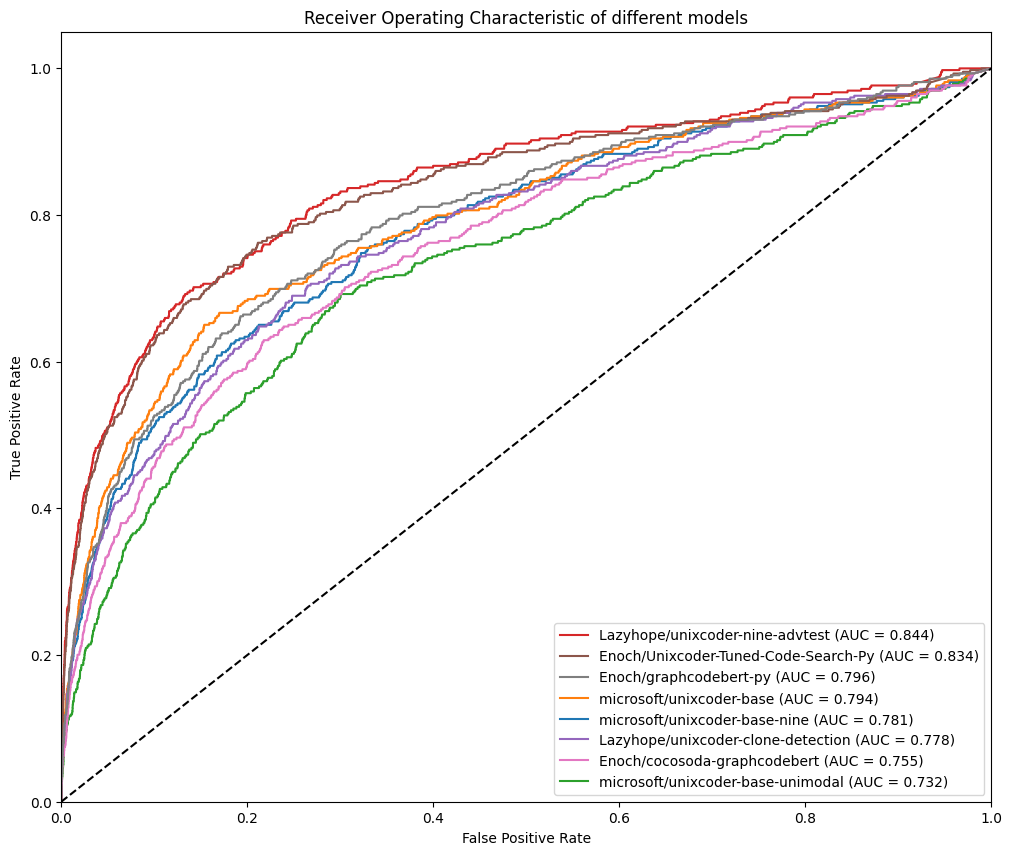

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

model_auc = {}
y_true = df['topic1'] == df['topic2']
fig = plt.figure(figsize=(12, 10))


def roc(model_name):
    y_score = df[model_name]
    fpr, tpr, thresholds = roc_curve(y_true, y_score)
    roc_auc = auc(fpr, tpr)
    model_auc[model_name] = roc_auc
    plt.plot(fpr, tpr, label=model_name)


for model in model_names:
    roc(model)

# Order labels by each model's auc score
handles, labels = plt.gca().get_legend_handles_labels()
order = sorted(range(len(labels)), key=lambda k: -model_auc[labels[k]])
ordered_handles = [handles[idx] for idx in order]
ordered_labels = [f'{labels[idx]} (AUC = {model_auc[labels[idx]]:.3f})' for idx in order]
plt.legend(ordered_handles, ordered_labels, loc="lower right")

plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'Receiver Operating Characteristic of different models')
plt.savefig('roc_code_evaluation_train_315.png')
plt.show()

In [ ]:
model_auc

{'microsoft/unixcoder-base-nine': 0.781207502569637,
 'microsoft/unixcoder-base': 0.794400730424473,
 'microsoft/unixcoder-base-unimodal': 0.7324477559454918,
 'Lazyhope/unixcoder-nine-advtest': 0.8436015635868777,
 'Lazyhope/unixcoder-clone-detection': 0.7775346975873227,
 'Enoch/Unixcoder-Tuned-Code-Search-Py': 0.8340845640441773,
 'Enoch/cocosoda-graphcodebert': 0.7553527803191247,
 'Enoch/graphcodebert-py': 0.7956534789541765}